# PHÂN TÍCH CHẤT LƯỢNG KHÔNG KHÍ

Thành viên:
- 23C24004 - Lê Nhựt Nam
- 23C24005 - Phạm Thừa Tiểu Thành

## Giới thiệu chung

Trong lĩnh vực khoa học dữ liệu và mô hình hóa thống kê, việc xử lý dữ liệu cao chiều (high-dimensional data) với đa cộng tuyến giữa các biến dự báo là một thách thức phổ biến. Các kỹ thuật hồi quy truyền thống thường gặp khó khăn trong các tình huống như vậy, dẫn đến ước tính không ổn định và hiệu suất dự báo kém. Để giải quyết các vấn đề này, các kỹ thuật giảm chiều như Hồi quy thành phần chính (Principal Component Regression - PCR) và Hồi quy bình phương tối tiểu riêng phần (Partial Least Squares Regression - PLS) được sử dụng. Trong đồ án này, chúng tôi thực nghiệm nghiên cứu và áp dụng hai kỹ thuật này thông qua bộ dữ liệu thực tế về đánh giá chất lượng không khí.

## Phát biểu bài toán

Trong đồ án này, chúng tôi quan tâm đến vấn đề chất lượng không khí mà trong đó chúng tôi quan tâm đến nồng độ chất C6H6 (benzene), được ký hiệu trong dữ liệu là C6H6(GT) dựa trên ý nghĩa của nó đối với sức khỏe cộng đồng và môi trường môi sinh. Benzen là một chất gây ô nhiễm chính, được phân loại là chất gây ung thư và sự hiện diện của nó trong khí quyển có liên quan chặt chẽ đến nhiều nguy cơ sức khỏe, bao gồm cả tỷ lệ ung thư gia tăng. Ngoài ra, nồng độ benzen đóng vai trò là chỉ số về khí thải từ phương tiện giao thông và công nghiệp, đây là những mối quan tâm chính trong quản lý ô nhiễm đô thị.

Ý nghĩa của đồ án này nằm ở việc phân tích và đưa ra các thông tin hữu ích có giá trị từ khảo sát dữ liệu chất lượng không khí, từ đó giúp người quản lý có thể đưa ra những chiến lược phù hợp nhằm cải thiện chất lượng không khí.

## Giới thiệu về dữ liệu

Bộ dữ liệu này, The Air Quality Dataset, được lấy từ UCI Machine Learning Repository, chứa các chỉ số đo đạt các chất gây ô nhiễm không khí và các biến số khí tượng khác nhau được thu thập tại một trạm giám sát của Ý. Bộ dữ liệu bao gồm các phép đo hàng ngày về các chất gây ô nhiễm như ôzôn, nitơ điôxít và cacbon monoxit, cũng như các biến số khí tượng như nhiệt độ, tốc độ gió và độ ẩm. Với hơn 9.000 quan trắc, bộ dữ liệu này cung cấp một nguồn dữ liệu phong phú để phân tích.

Trong đồ án này, biến mục tiêu là một trong những chất gây ô nhiễm, cho phép sử dụng các mô hình hồi quy như PCR và PLS để dự đoán chất lượng không khí dựa trên các yếu tố dự báo sẵn có.

## Import thư viện

In [2]:
library(dplyr)
library(tidyr)
library(car)
library(readxl)
library(mice)
library(VIM)
library(grid)
library(ggplot2)
library(cowplot)
library(missMDA)
library(FactoMineR)
library(TidyDensity)
library(MASS)
library(leaps)
library(lmtest)
library(Metrics)

library(pls)
# library(caret)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep



== Welcome to TidyDensity ===========================================================================
If you find this package useful, please leave a star: 
   https://github.com/spsanderson/TidyDensity'

If you enco

## Hàm phụ trợ

In [3]:
remove_high_vif <- function(regr_variable, data, threshold = 5) {      
    stop <- FALSE
    while(stop == FALSE) {
        # Tính VIF cho các biến độc lập
        model <- lm(as.formula(paste(regr_variable, "~ .")), data = data)
        vif_values <- vif(model)
        # Tìm các biến có VIF cao hơn ngưỡng
        high_vif <- which(vif_values > threshold)
        
        if (length(high_vif) > 0) {
            # Loại bỏ các biến có VIF cao
            remove_index <- which.max(high_vif)
            rm_names <- names(data[, !names(data) %in% regr_variable])
            rm_name <- rm_names[remove_index]
            data <- data[, !names(data) %in% rm_name]
        } else {
            stop <- TRUE
        }
    }
    return(data)
}

response_variable = 1 

# Hàm tiền xử lý dữ liệu với box-cox
bc_transform <- function(df) {
    col.names <- names(df)

    transformed_df <- df
    
    for (name in names(df))
    {
        col.name <- name

        print(col.name)

        # Rút trích biến phản hồi
        response_variable <- df[[col.name]]
        
        if (!is.numeric(response_variable)) {
            print(col.name)
            stop("The column to be transformed must be numeric.")
        }
        
        if (any(response_variable <= 0)) {
            # Shift the values to be positive
            shift_value <- abs(min(response_variable)) + 1
            response_variable <- response_variable + shift_value
        }
        
        # Áp dụng box-cox transform để tìm lambda tối ưu
        boxcox_result <- boxcox(lm(response_variable ~ 1), plotit = FALSE)
        optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
        print(paste("Optimal lambda:", optimal_lambda))
        
        # Sử dụng lambda tối ưu để biến đổi dữ liệu
        if (optimal_lambda == 0) {
            transformed_response <- log(response_variable)
        } else {
            transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
        }
        
        # Gán biến đã được biến đổi
        transformed_df[[col.name]] <- transformed_response
    }
    
    return(transformed_df)
}

indicator <- function(model, y_pred, y_true) {
     adj.r.sq <- summary(model)$adj.r.squared
     mse <- MSE(y_pred, y_true)
     rmse <- RMSE(y_pred, y_true)
     mae <- MAE(y_pred, y_true)
     print(paste0("Adjusted R-squared: ", round(adj.r.sq, 4)))
     print(paste0("MSE: ", round(mse, 4)))
     print(paste0("RMSE: ", round(rmse, 4)))
     print(paste0("MAE: ", round(mae, 4)))
}


metrics <- function(y_pred, y_true){
     mse <- MSE(y_pred, y_true)
     rmse <- RMSE(y_pred, y_true)
     mae <- MAE(y_pred, y_true)
     print(paste0("MSE: ", round(mse, 6)))
     print(paste0("RMSE: ", round(rmse, 6)))
     print(paste0("MAE: ", round(mae, 6)))
     corPredAct <- cor(y_pred, y_true)
     print(paste0("Correlation: ", round(corPredAct, 6)))
     print(paste0("R^2 between y_pred & y_true: ", round(corPredAct^2, 6)))
}

CheckNormal <- function(model) {
    if (length(model$residuals) < 4997)
    {
        hist(model$residuals, breaks = 30)
        shaptest <- shapiro.test(model$residuals)
        print(shaptest)
        if (shaptest$p.value <= 0.05) {
            print("H0 rejected: the residuals are NOT distributed normally")
        } else {
            print("H0 failed to reject: the residuals ARE distributed normally")
        }
    } else {
        hist(model$residuals, breaks = 30)
        shaptest <- shapiro.test(model$residuals[3:5000])
        print(shaptest)
        if (shaptest$p.value <= 0.05) {
            print("H0 rejected: the residuals are NOT distributed normally")
        } else {
            print("H0 failed to reject: the residuals ARE distributed normally")
        }
    }
}

CheckHomos <- function(model){
     plot(model$fitted.values, model$residuals)
     abline(h = 0, col = "red")
     BP <- bptest(model)
     print(BP)
     if (BP$p.value <= 0.05) {
          print("H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)")
     } else {
          print("H0 failed to reject: Error variance spreads CONSTANTLY (Homoscedasticity)")
     }
}

## Đọc dữ liệu

In [4]:
# Đọc dữ liệu từ tập tin
raw_data = read_excel("../../data/part2/air+quality/AirQualityUCI.xlsx", sheet = 1)
str(raw_data)

tibble [9,357 × 15] (S3: tbl_df/tbl/data.frame)
 $ Date         : POSIXct[1:9357], format: "2004-03-10" "2004-03-10" ...
 $ Time         : POSIXct[1:9357], format: "1899-12-31 18:00:00" "1899-12-31 19:00:00" ...
 $ CO(GT)       : num [1:9357] 2.6 2 2.2 2.2 1.6 1.2 1.2 1 0.9 0.6 ...
 $ PT08.S1(CO)  : num [1:9357] 1360 1292 1402 1376 1272 ...
 $ NMHC(GT)     : num [1:9357] 150 112 88 80 51 38 31 31 24 19 ...
 $ C6H6(GT)     : num [1:9357] 11.88 9.4 9 9.23 6.52 ...
 $ PT08.S2(NMHC): num [1:9357] 1046 955 939 948 836 ...
 $ NOx(GT)      : num [1:9357] 166 103 131 172 131 89 62 62 45 -200 ...
 $ PT08.S3(NOx) : num [1:9357] 1056 1174 1140 1092 1205 ...
 $ NO2(GT)      : num [1:9357] 113 92 114 122 116 96 77 76 60 -200 ...
 $ PT08.S4(NO2) : num [1:9357] 1692 1559 1554 1584 1490 ...
 $ PT08.S5(O3)  : num [1:9357] 1268 972 1074 1203 1110 ...
 $ T            : num [1:9357] 13.6 13.3 11.9 11 11.2 ...
 $ RH           : num [1:9357] 48.9 47.7 54 60 59.6 ...
 $ AH           : num [1:9357] 0.758 0.72

## Khám phá và tiền xử lý dữ liệu

### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [5]:
# Kích thước của dữ liệu
# Ta thấy dữ liệu có 231 dòng và 14 cột
dim(raw_data)

[1] 9357   15

In [6]:
head(raw_data)

Date       Time                CO(GT) PT08.S1(CO) NMHC(GT) C6H6(GT) 
1 2004-03-10 1899-12-31 18:00:00 2.6    1360.00     150      11.881723
2 2004-03-10 1899-12-31 19:00:00 2.0    1292.25     112       9.397165
3 2004-03-10 1899-12-31 20:00:00 2.2    1402.00      88       8.997817
4 2004-03-10 1899-12-31 21:00:00 2.2    1375.50      80       9.228796
5 2004-03-10 1899-12-31 22:00:00 1.6    1272.25      51       6.518224
6 2004-03-10 1899-12-31 23:00:00 1.2    1197.00      38       4.741012
  PT08.S2(NMHC) NOx(GT) PT08.S3(NOx) NO2(GT) PT08.S4(NO2) PT08.S5(O3) T     
1 1045.50       166     1056.25      113     1692.00      1267.50     13.600
2  954.75       103     1173.75       92     1558.75       972.25     13.300
3  939.25       131     1140.00      114     1554.50      1074.00     11.900
4  948.25       172     1092.00      122     1583.75      1203.25     11.000
5  835.50       131     1205.00      116     1490.00      1110.00     11.150
6  750.25        89     1336.50       96     1393.00       949.25     11.175
  RH     AH       
1 48.875 0.7577538
2 47.700 0.7254874
3 53.975 0.7502391
4 60.000 0.7867125
5 59.575 0.7887942
6 59.175 0.7847717

### Mỗi dòng có ý nghĩa gì? Liệu có tồn tại dòng nào mà mang ý nghĩa khác với các dòng còn lại không?

Dựa trên thông tin của tập dữ liệu, ta thấy mỗi dòng mang ý nghĩa khác nhau, tức là mỗi quan trắc độc lập nhau.

### Dữ liệu có bị trùng lặp không?

In [7]:
# Kiểm tra dữ liệu trùng lặp
duplicates <- raw_data[duplicated(raw_data), ]
duplicate_counts <- table(raw_data[duplicated(raw_data), ])
duplicates # Không có dữ liệu trùng lặp

Date Time CO(GT) PT08.S1(CO) NMHC(GT) C6H6(GT) PT08.S2(NMHC) NOx(GT)
     PT08.S3(NOx) NO2(GT) PT08.S4(NO2) PT08.S5(O3) T RH AH

### Mỗi cột mang ý nghĩa gì?

In [8]:
# Đầu tiên, ta xem xét một số quan trắc
str(raw_data)

tibble [9,357 × 15] (S3: tbl_df/tbl/data.frame)
 $ Date         : POSIXct[1:9357], format: "2004-03-10" "2004-03-10" ...
 $ Time         : POSIXct[1:9357], format: "1899-12-31 18:00:00" "1899-12-31 19:00:00" ...
 $ CO(GT)       : num [1:9357] 2.6 2 2.2 2.2 1.6 1.2 1.2 1 0.9 0.6 ...
 $ PT08.S1(CO)  : num [1:9357] 1360 1292 1402 1376 1272 ...
 $ NMHC(GT)     : num [1:9357] 150 112 88 80 51 38 31 31 24 19 ...
 $ C6H6(GT)     : num [1:9357] 11.88 9.4 9 9.23 6.52 ...
 $ PT08.S2(NMHC): num [1:9357] 1046 955 939 948 836 ...
 $ NOx(GT)      : num [1:9357] 166 103 131 172 131 89 62 62 45 -200 ...
 $ PT08.S3(NOx) : num [1:9357] 1056 1174 1140 1092 1205 ...
 $ NO2(GT)      : num [1:9357] 113 92 114 122 116 96 77 76 60 -200 ...
 $ PT08.S4(NO2) : num [1:9357] 1692 1559 1554 1584 1490 ...
 $ PT08.S5(O3)  : num [1:9357] 1268 972 1074 1203 1110 ...
 $ T            : num [1:9357] 13.6 13.3 11.9 11 11.2 ...
 $ RH           : num [1:9357] 48.9 47.7 54 60 59.6 ...
 $ AH           : num [1:9357] 0.758 0.72

### Có cột nào có kiểu dữ liệu chưa phù hợp? Nếu có, cần chuyển đổi sang kiểu phù hợp

| Tên biến      | Vai trò | Phân loại               | Mô tả                                                                                                                             | Đơn vị     | Missing Values |
| ------------- | ------- | ----------------------- | --------------------------------------------------------------------------------------------------------------------------------- | ---------- | -------------- |
| Date          | Feature | Date (Ngày tháng năm)   | Ngày tháng mà các giá trị độ đo được thu thập.                                                                                    |            | Không          |
| Time          | Feature | Categorical (Phân loại) | Thời gian mà các giá trị độ đo được thu thập.                                                                                     |            | Không          |
| CO(GT)        | Feature | Integer (Nguyên)        | Nồng độ CO (carbon monoxide) trung bình thực tế theo giờ tính bằng mg/m^3 (máy phân tích tham chiếu)                              | mg/m^3     | Không          |
| PT08.S1(CO)   | Feature | Categorical (Phân loại) | (Trung bình theo giờ) Phản hồi cảm biến (PPM) của cảm biến hồng ngoại không phân tán (NDIR) đối với carbon monoxide.              |            | Không          |
| NMHC(GT)      | Feature | Integer (Nguyên)        | Nồng độ Non Metanic HydroCarbons trong không khí (đơn vị microg/m^3/ trung bình theo giờ/ dựa trên máy phân tích tham chiếu)      | microg/m^3 | Không          |
| C6H6(GT)      | Feature | Continuous              | Nồng độ trung bình Benzene trong không khí (đơn vị microg/m^3/ trung bình theo giờ/ dựa trên máy phân tích tham chiếu)            | microg/m^3 | Không          |
| PT08.S2(NMHC) | Feature | Categorical (Phân loại) | (Trung bình theo giờ) Phản hồi cảm biến (PPM) của cảm biến hồng ngoại không phân tán (NDIR) đối với Non Metanic HydroCarbons      |            | Không          |
| NOx(GT)       | Feature | Integer (Nguyên)        | Nồng độ trung bình NOx (oxit nitơ) trong không khí (đơn vị PPB/ trung bình theo giờ/ dựa trên máy phân tích tham chiếu)           | ppb        | Không          |
| PT08.S3(NOx)  | Feature | Categorical (Phân loại) | (Trung bình theo giờ) Phản hồi cảm biến (PPM) của cảm biến hồng ngoại không phân tán (NDIR) đối với NOx (oxit nitơ)               |            | Không          |
| NO2(GT)       | Feature | Integer (Nguyên)        | Nồng độ trung bình NO2 (nitơ dioxit) trong không khí (đơn vị microg/m^3 / trung bình theo giờ/ dựa trên máy phân tích tham chiếu) | microg/m^3 | Không          |
| PT08.S4(NO2)  | Feature | Categorical (Phân loại) | (Trung bình theo giờ) Phản hồi cảm biến (PPM) của cảm biến hồng ngoại không phân tán (NDIR) đối với NO2 (nitơ dioxit)             |            | Không          |
| PT08.S5(O3)   | Feature | Categorical (Phân loại) | (Trung bình theo giờ) Phản hồi cảm biến (PPM) của cảm biến hồng ngoại không phân tán (NDIR) đối với O3                            |            | Không          |
| T             | Feature | Continuous (Liên tục)   | Nhiệt độ (Thang độ Celsius)                                                                                                       | °C         | Không          |
| RH            | Feature | Continuous (Liên tục)   | Độ ẩm tương đối (Relative Humidity)                                                                                               | %          | Không          |
| AH            | Feature | Continuous (Liên tục)   | Độ ẩm tuyệt đối (Absolute Humidity)                                                                                               |            | Không          |


In [9]:
# 1. Time
is.factor(raw_data$Time) #False 

# 2. PT08.S1(CO)
is.factor(raw_data$`PT08.S1(CO)`) # False

# 3. PT08.S2(NMHC)
is.factor(raw_data$`PT08.S2(NMHC)`) # False

# 4. PT08.S3(NOx)
is.factor(raw_data$`PT08.S3(NOx)`) # False

# 5. PT08.S4(NO2)
is.factor(raw_data$`PT08.S4(NO2)`) # False

# 6. PT08.S5(O3)
is.factor(raw_data$`PT08.S5(O3)`) # False

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

In [10]:
# Convert character columns to numeric, except for Date and Time
cols_to_convert <- setdiff(names(raw_data), c("Date", "Time"))

In [11]:
# Use mutate to convert columns to numeric
air_quality <- raw_data %>% mutate(across(all_of(cols_to_convert), ~ as.numeric(gsub(",", ".", .))))
head(air_quality)

Date       Time                CO(GT) PT08.S1(CO) NMHC(GT) C6H6(GT) 
1 2004-03-10 1899-12-31 18:00:00 2.6    1360.00     150      11.881723
2 2004-03-10 1899-12-31 19:00:00 2.0    1292.25     112       9.397165
3 2004-03-10 1899-12-31 20:00:00 2.2    1402.00      88       8.997817
4 2004-03-10 1899-12-31 21:00:00 2.2    1375.50      80       9.228796
5 2004-03-10 1899-12-31 22:00:00 1.6    1272.25      51       6.518224
6 2004-03-10 1899-12-31 23:00:00 1.2    1197.00      38       4.741012
  PT08.S2(NMHC) NOx(GT) PT08.S3(NOx) NO2(GT) PT08.S4(NO2) PT08.S5(O3) T     
1 1045.50       166     1056.25      113     1692.00      1267.50     13.600
2  954.75       103     1173.75       92     1558.75       972.25     13.300
3  939.25       131     1140.00      114     1554.50      1074.00     11.900
4  948.25       172     1092.00      122     1583.75      1203.25     11.000
5  835.50       131     1205.00      116     1490.00      1110.00     11.150
6  750.25        89     1336.50       96     1393.00       949.25     11.175
  RH     AH       
1 48.875 0.7577538
2 47.700 0.7254874
3 53.975 0.7502391
4 60.000 0.7867125
5 59.575 0.7887942
6 59.175 0.7847717

In [12]:
# # Modifications
# raw_data$Time <- as.factor(raw_data$Time)
# raw_data$`PT08.S1(CO)` <- as.factor(raw_data$`PT08.S1(CO)`)
# raw_data$`PT08.S2(NMHC)` <- as.factor(raw_data$`PT08.S2(NMHC)`)
# raw_data$`PT08.S3(NOx)` <- as.factor(raw_data$`PT08.S3(NOx)`)
# raw_data$`PT08.S4(NO2)` <- as.factor(raw_data$`PT08.S4(NO2)`)
# raw_data$`PT08.S5(O3)` <- as.factor(raw_data$`PT08.S5(O3)`)

### Các cột với kiểu dữ liệu số phân bố như thế nào?

In [13]:
# Hàm tính toán tỷ lệ missing values
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Hàm tính toán trung vị (median)
median_custom <- function(df) {
  round(quantile(df, 0.5, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 25% (Q1)
lower_quartile <- function(df) {
  round(quantile(df, 0.25, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 75% (Q3)
upper_quartile <- function(df) {
  round(quantile(df, 0.75, na.rm = TRUE), 1)
}

In [14]:
# Lựa chọn các kiểu số
num_col_info_df <- as.data.frame(air_quality) %>% select_if(is.numeric)

# Tổng hợp thông tin thống kê mô tả
num_col_info_df <- as.data.frame(air_quality) %>%
  select_if(is.numeric) %>%
  summarise(
    across(everything(), list(
      missing_ratio = ~ missing_ratio(.),
      min = ~ min(., na.rm = TRUE),
      lower_quartile = ~ lower_quartile(.),
      median = ~ median_custom(.),
      upper_quartile = ~ upper_quartile(.),
      max = ~ max(., na.rm = TRUE)
    ))
  )

num_col_info_df <- num_col_info_df %>%
  pivot_longer(
    cols = everything(),
    names_to = c("variable", ".value"),
    names_sep = "_"
  )

print(num_col_info_df)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 39 rows [1, 3, 5, 7, 9, 11,
13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, ...].”


# A tibble: 13 × 7
   variable      missing   min  lower median  upper     max
   <chr>           <dbl> <dbl>  <dbl>  <dbl>  <dbl>   <dbl>
 1 CO(GT)              0  -200    0.6    1.5    2.6   11.9 
 2 PT08.S1(CO)         0  -200  921   1052.  1221.  2040.  
 3 NMHC(GT)            0  -200 -200   -200   -200   1189   
 4 C6H6(GT)            0  -200    4      7.9   13.6   63.7 
 5 PT08.S2(NMHC)       0  -200  711    894.  1105.  2214   
 6 NOx(GT)             0  -200   50    141    284.  1479   
 7 PT08.S3(NOx)        0  -200  637    794.   960.  2683.  
 8 NO2(GT)             0  -200   53     96    133    340.  
 9 PT08.S4(NO2)        0  -200 1185.  1446.  1662   2775   
10 PT08.S5(O3)         0  -200  700.   942   1255.  2523.  
11 T                   0  -200   10.9   17.2   24.1   44.6 
12 RH                  0  -200   34.1   48.6   61.9   88.7 
13 AH                  0  -200    0.7    1      1.3    2.23


**Nhận xét**
- Dữ liệu không có hiện tượng missing values. 
- Dữ liệu có giá trị âm đối với các cột có kiểu số, các giá trị này thể hiện các giá trị bị thiếu.

In [15]:
print(summary(as.data.frame(air_quality) %>% select_if(is.numeric)))

     CO(GT)         PT08.S1(CO)      NMHC(GT)         C6H6(GT)       
 Min.   :-200.00   Min.   :-200   Min.   :-200.0   Min.   :-200.000  
 1st Qu.:   0.60   1st Qu.: 921   1st Qu.:-200.0   1st Qu.:   4.005  
 Median :   1.50   Median :1052   Median :-200.0   Median :   7.887  
 Mean   : -34.21   Mean   :1049   Mean   :-159.1   Mean   :   1.866  
 3rd Qu.:   2.60   3rd Qu.:1221   3rd Qu.:-200.0   3rd Qu.:  13.636  
 Max.   :  11.90   Max.   :2040   Max.   :1189.0   Max.   :  63.741  
 PT08.S2(NMHC)       NOx(GT)        PT08.S3(NOx)       NO2(GT)       
 Min.   :-200.0   Min.   :-200.0   Min.   :-200.0   Min.   :-200.00  
 1st Qu.: 711.0   1st Qu.:  50.0   1st Qu.: 637.0   1st Qu.:  53.00  
 Median : 894.5   Median : 141.0   Median : 794.2   Median :  96.00  
 Mean   : 894.5   Mean   : 168.6   Mean   : 794.9   Mean   :  58.14  
 3rd Qu.:1104.8   3rd Qu.: 284.2   3rd Qu.: 960.2   3rd Qu.: 133.00  
 Max.   :2214.0   Max.   :1479.0   Max.   :2682.8   Max.   : 339.70  
  PT08.S4(NO2)   PT0

In [16]:
# # Gán các giá trị bé hơn 0, bằng 0
replace_negatives <- function(x) {
  x[x == -200] <- NA
  return(x)
}

air_quality <- as.data.frame(lapply(air_quality, replace_negatives))

### Xử lý các giá trị bị thiếu

Do ta có missing value ở tất cả các cột nên ta sẽ điền các giá trị bị thiếu bằng trung bình của các cột.

In [17]:
tmp <- air_quality[, -c(1, 2)]

In [18]:
# using colMeans()
mean_val <- colMeans(tmp, na.rm = TRUE)
 
# replacing NA with mean value of each column
for(i in colnames(tmp))
  tmp[,i][is.na(tmp[,i])] <- mean_val[i]

tmp$Date <- air_quality$Date
tmp$Time <- air_quality$Time
air_quality <- tmp

In [19]:
print(summary(as.data.frame(air_quality) %>% select_if(is.numeric)))

     CO.GT.        PT08.S1.CO.        NMHC.GT.         C6H6.GT.     
 Min.   : 0.100   Min.   : 647.2   Min.   :   7.0   Min.   : 0.149  
 1st Qu.: 1.200   1st Qu.: 941.2   1st Qu.: 218.8   1st Qu.: 4.591  
 Median : 2.153   Median :1074.5   Median : 218.8   Median : 8.593  
 Mean   : 2.153   Mean   :1099.7   Mean   : 218.8   Mean   :10.083  
 3rd Qu.: 2.600   3rd Qu.:1221.2   3rd Qu.: 218.8   3rd Qu.:13.636  
 Max.   :11.900   Max.   :2039.8   Max.   :1189.0   Max.   :63.741  
 PT08.S2.NMHC.       NOx.GT.        PT08.S3.NOx.       NO2.GT.     
 Min.   : 383.2   Min.   :   2.0   Min.   : 322.0   Min.   :  2.0  
 1st Qu.: 742.5   1st Qu.: 112.0   1st Qu.: 665.5   1st Qu.: 85.9  
 Median : 923.2   Median : 229.0   Median : 817.5   Median :113.1  
 Mean   : 939.0   Mean   : 246.9   Mean   : 835.4   Mean   :113.1  
 3rd Qu.:1104.8   3rd Qu.: 284.2   3rd Qu.: 960.2   3rd Qu.:133.0  
 Max.   :2214.0   Max.   :1479.0   Max.   :2682.8   Max.   :339.7  
  PT08.S4.NO2.   PT08.S5.O3.           T 

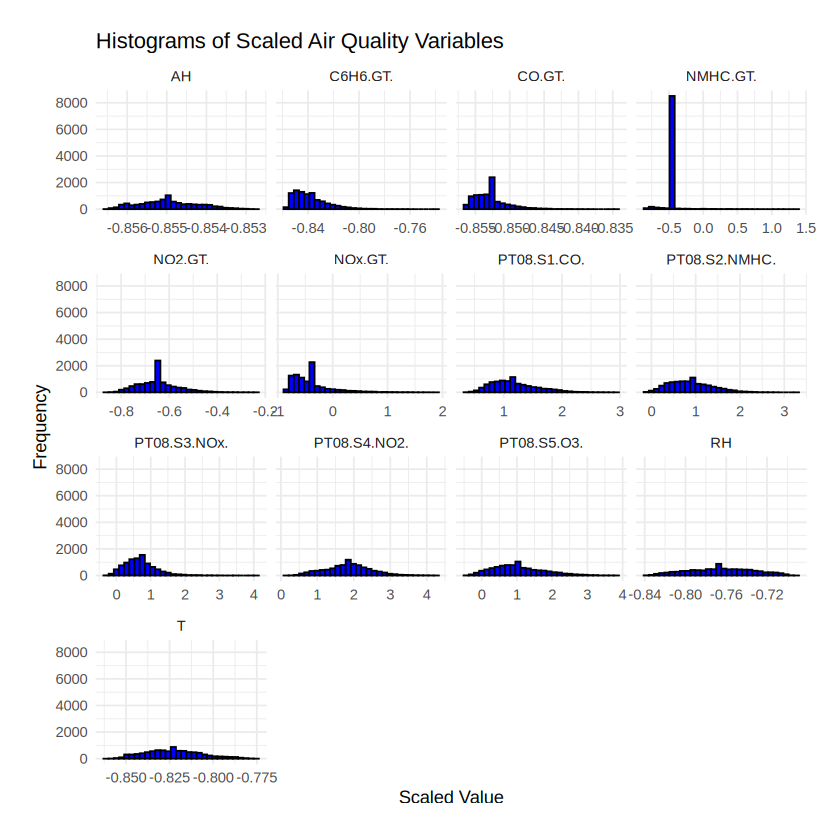

In [20]:
# Converting data to long format and scaling the values
air_quality_long <- air_quality %>%
  pivot_longer(cols = -c(Date, Time), names_to = "variable", values_to = "value") %>%
  mutate(value = scale(value))  # Scale the data

# 1. Histograms of Scaled Data
ggplot(air_quality_long, aes(x = value)) +
  geom_histogram(bins = 30, fill = "blue", color = "black") +
  facet_wrap(~ variable, scales = "free_x") +
  theme_minimal() +
  theme(plot.margin = margin(20, 20, 20, 20)) +
  labs(title = "Histograms of Scaled Air Quality Variables",
       x = "Scaled Value",
       y = "Frequency")

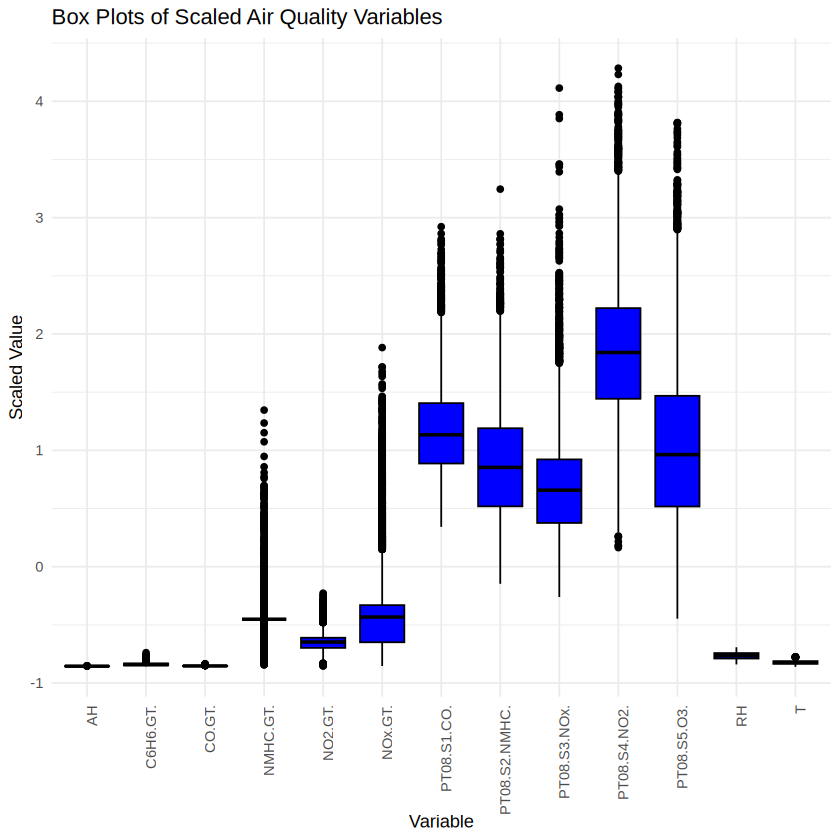

In [21]:
# 2. Box Plots of Scaled Data
ggplot(air_quality_long, aes(x = variable, y = value)) +
  geom_boxplot(fill = "blue", color = "black") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(title = "Box Plots of Scaled Air Quality Variables",
       x = "Variable",
       y = "Scaled Value")

## Phân tích đơn biến

In [22]:
names(air_quality)

[1] "CO.GT."        "PT08.S1.CO."   "NMHC.GT."      "C6H6.GT."     
 [5] "PT08.S2.NMHC." "NOx.GT."       "PT08.S3.NOx."  "NO2.GT."      
 [9] "PT08.S4.NO2."  "PT08.S5.O3."   "T"             "RH"           
[13] "AH"            "Date"          "Time"

### 1. CO(GT): Carbon monoxide concentration (mg/m³)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


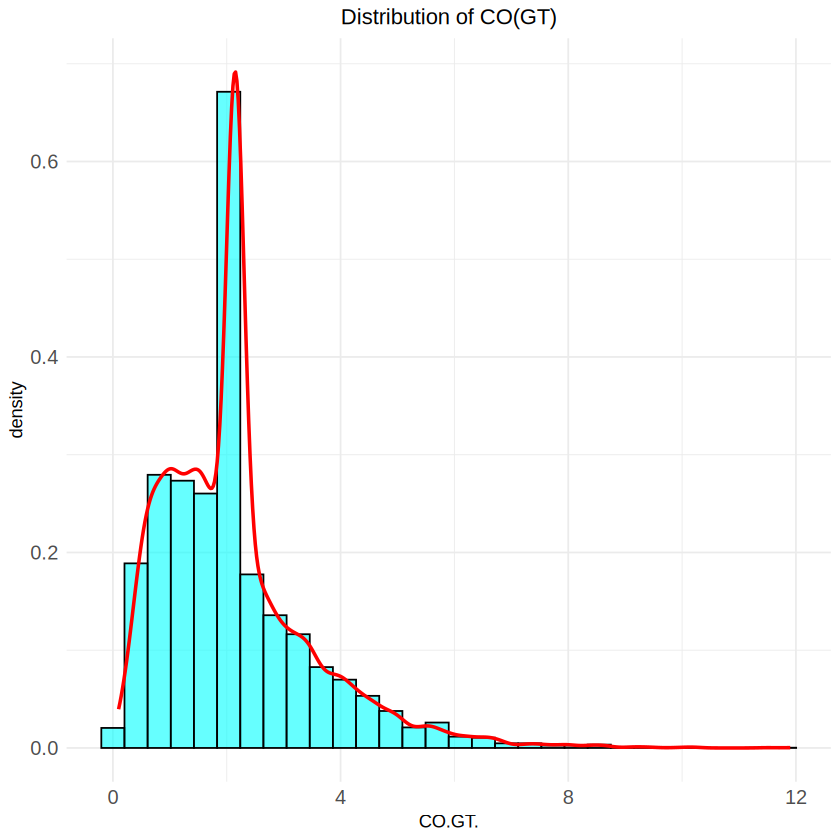

In [23]:
ggplot(air_quality, aes(x = `CO.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of CO(GT)") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

**Nhận xét**:
- Nhìn vào biểu đồ, ta thấy phân phối của biến `CO.GT.` bị lệch phải.

Ta thử sử dụng log-transform nó.

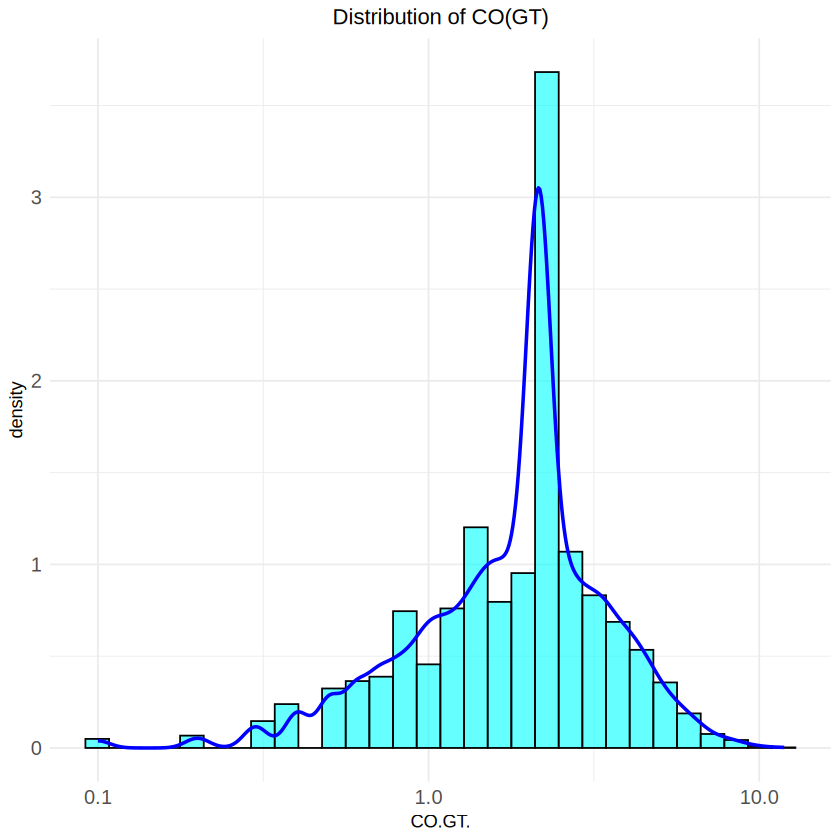

In [24]:
ggplot(air_quality, aes(x = `CO.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of CO(GT)") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.343434343434343"


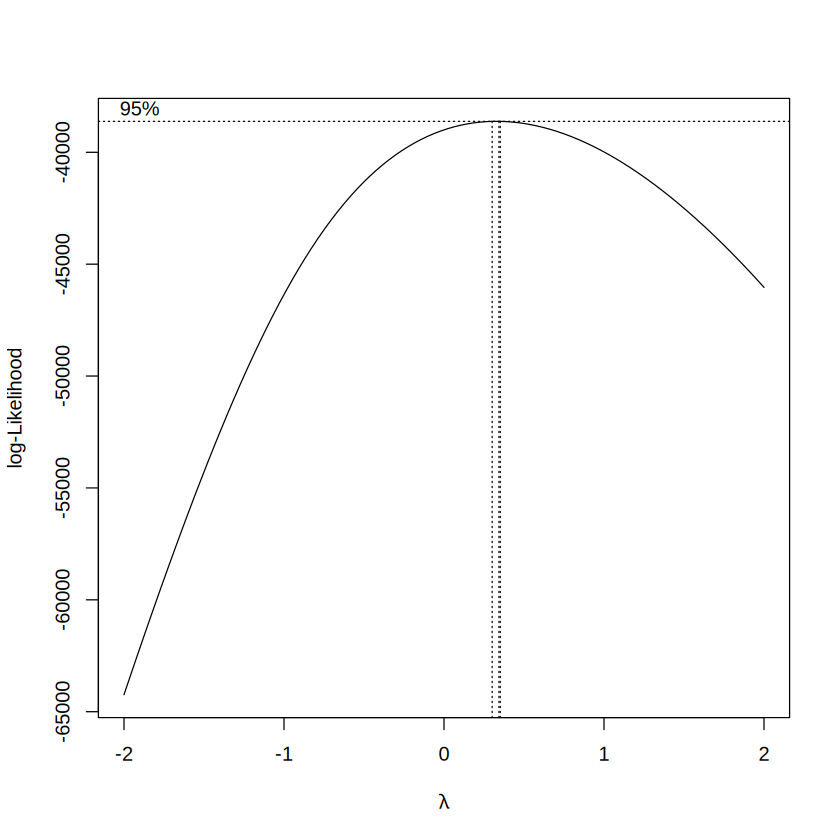

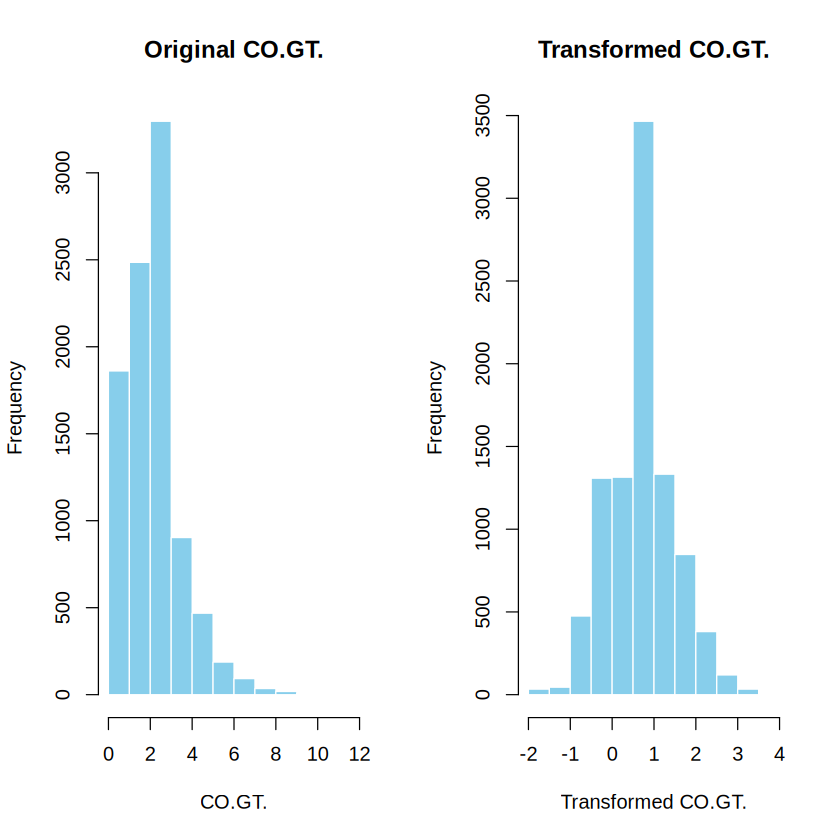

In [25]:
response_variable <- air_quality$`CO.GT.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original CO.GT.", xlab = "CO.GT.", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed CO.GT.", xlab = "Transformed CO.GT.", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

Ta có được giá trị lambda tối ưu là 0.33 và sử dụng giá trị này để biến đổi biến `CO(GT)`. Biểu đồ histogram phía bên dưới thể hiện phân phối của biến này trước và sau khi biến đổi. Dễ dàng thấy được, sau khi biến đổi, biến này đã tương đối chuẩn hơn.

### 2. PT08.S1(CO): Sensor response for CO

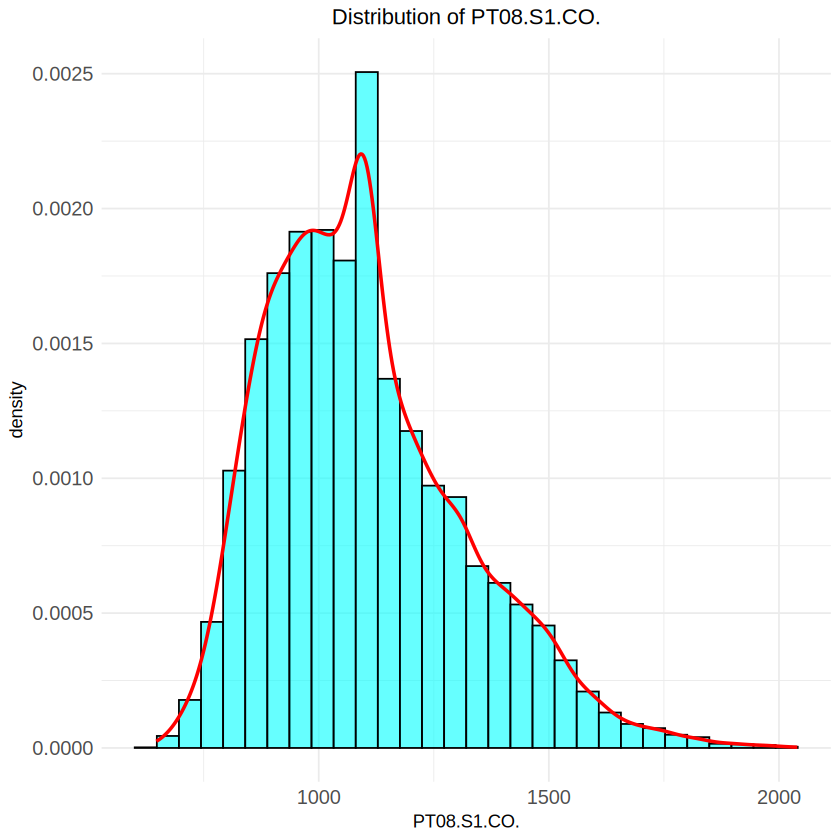

In [26]:
ggplot(air_quality, aes(x = `PT08.S1.CO.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of PT08.S1.CO.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

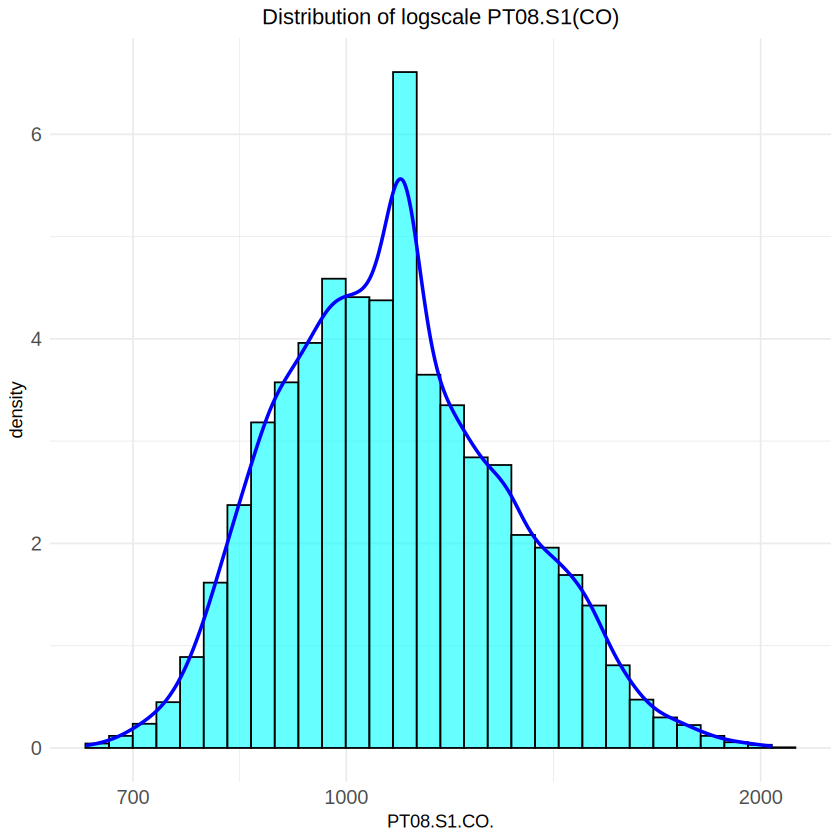

In [27]:
ggplot(air_quality, aes(x = `PT08.S1.CO.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale PT08.S1(CO)") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  -0.626262626262626"


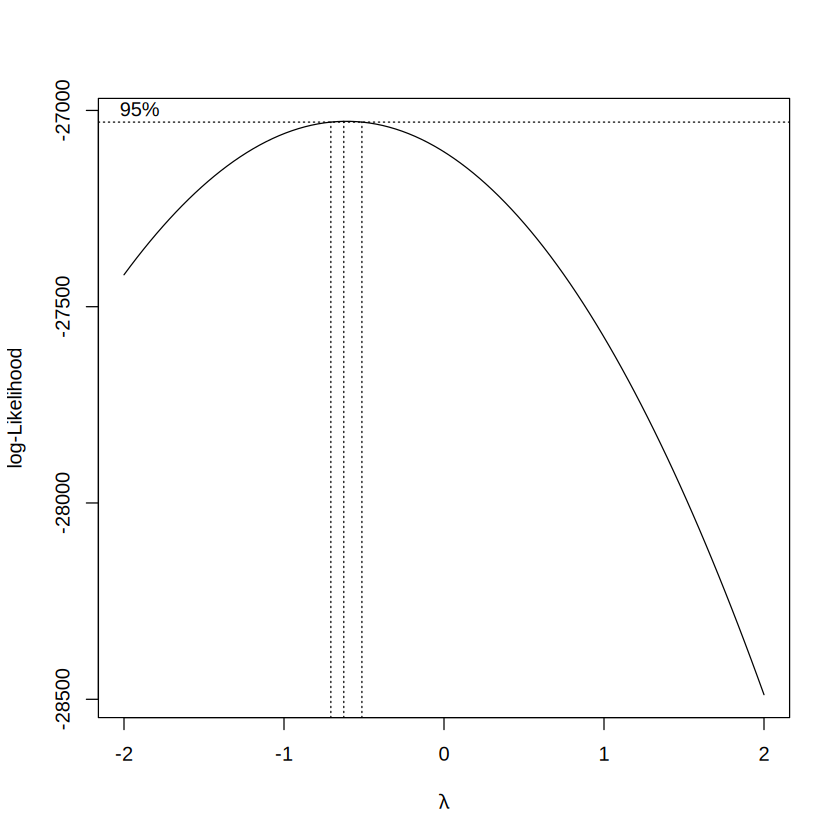

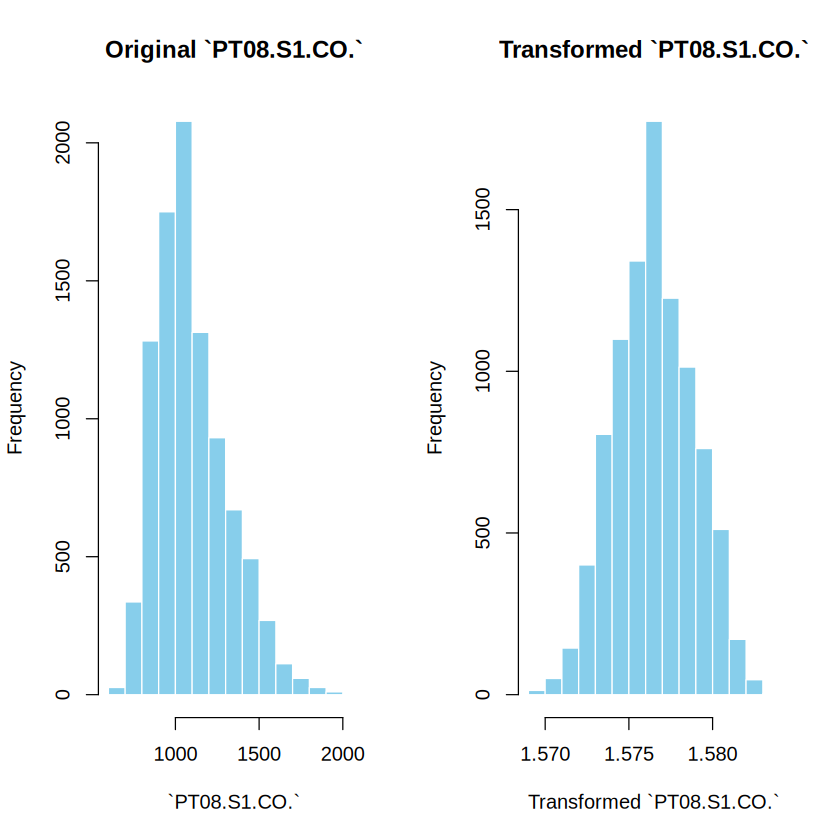

In [28]:
response_variable <- air_quality$`PT08.S1.CO.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `PT08.S1.CO.`", xlab = "`PT08.S1.CO.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `PT08.S1.CO.`", xlab = "Transformed `PT08.S1.CO.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### 3. NMHC(GT): Non-methane hydrocarbons concentration (μg/m³)

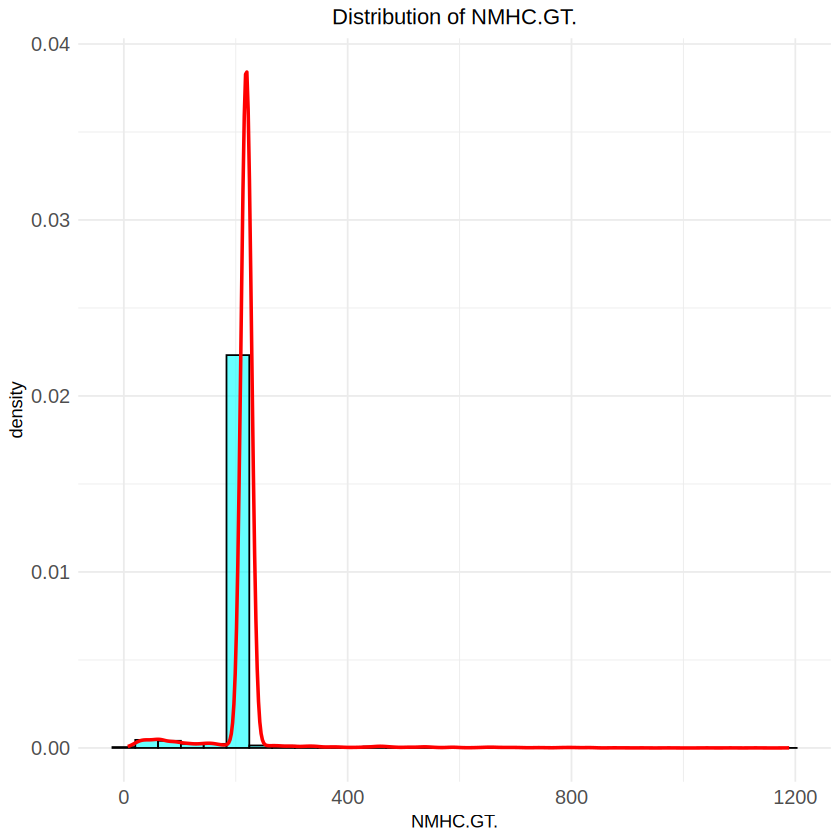

In [29]:
ggplot(air_quality, aes(x = `NMHC.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of NMHC.GT.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

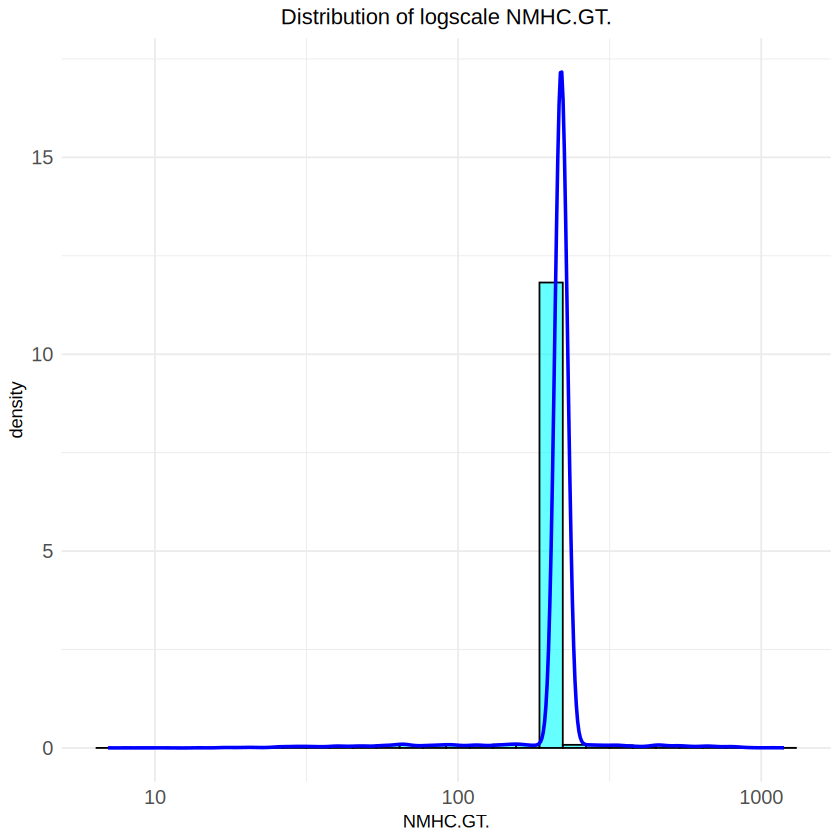

In [30]:
ggplot(air_quality, aes(x = `NMHC.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale NMHC.GT.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.585858585858586"


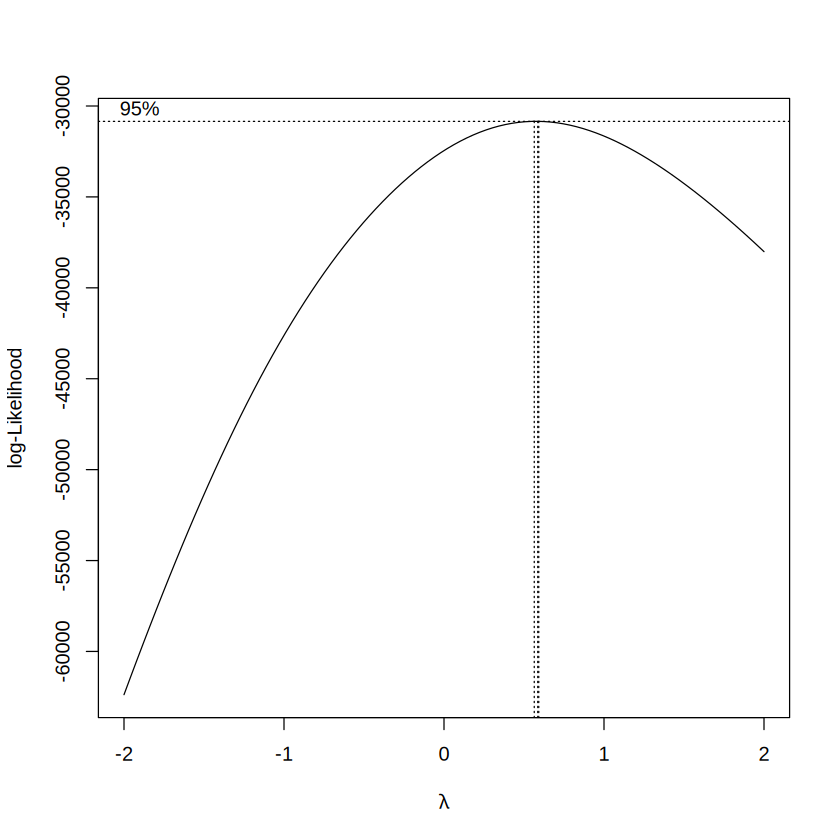

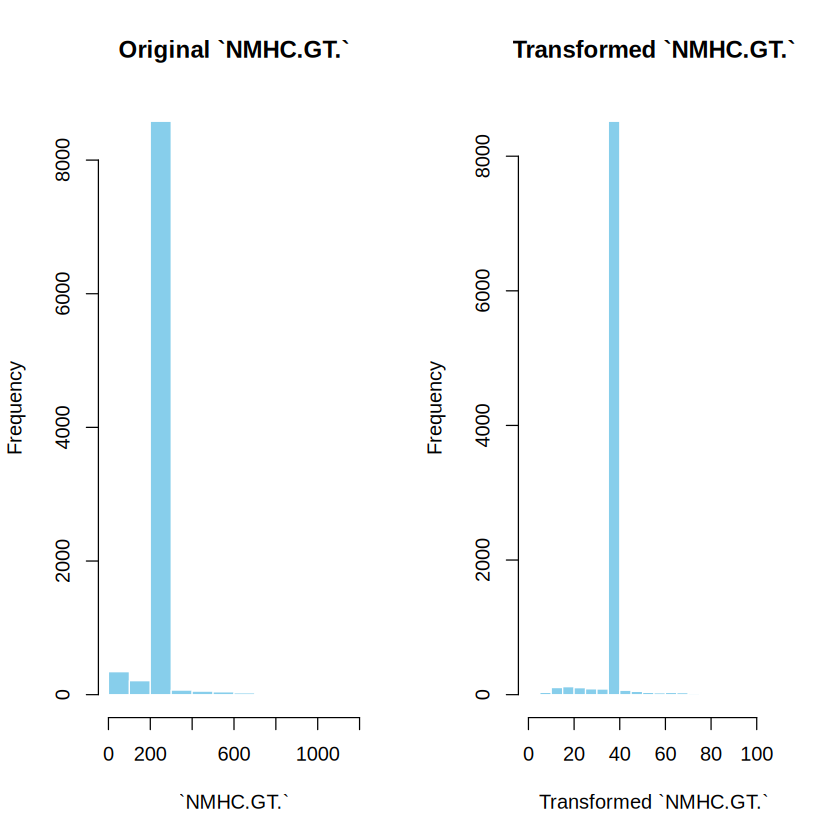

In [31]:
response_variable <- air_quality$`NMHC.GT.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `NMHC.GT.`", xlab = "`NMHC.GT.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `NMHC.GT.`", xlab = "Transformed `NMHC.GT.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### 4. C6H6(GT): Benzene concentration (μg/m³)

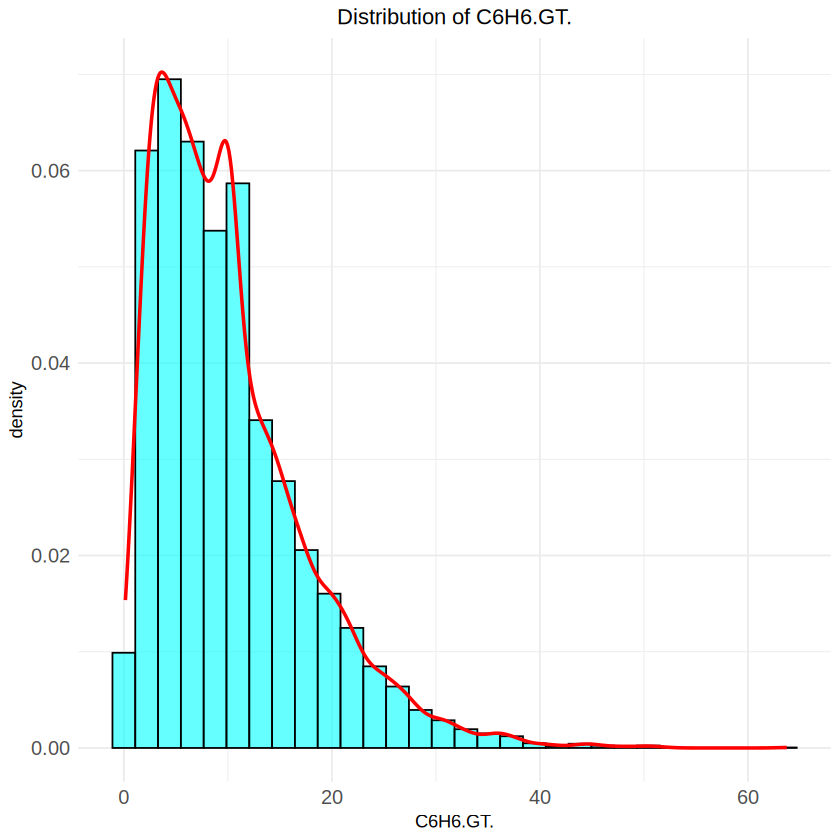

In [32]:
ggplot(air_quality, aes(x = `C6H6.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of C6H6.GT.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

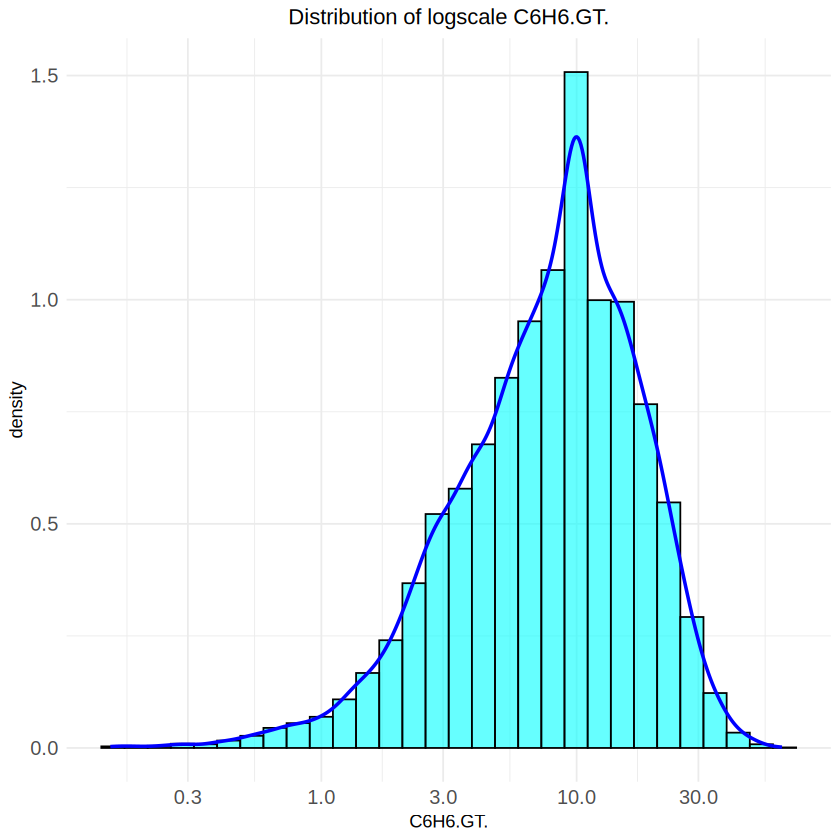

In [33]:
ggplot(air_quality, aes(x = `C6H6.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale C6H6.GT.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.303030303030303"


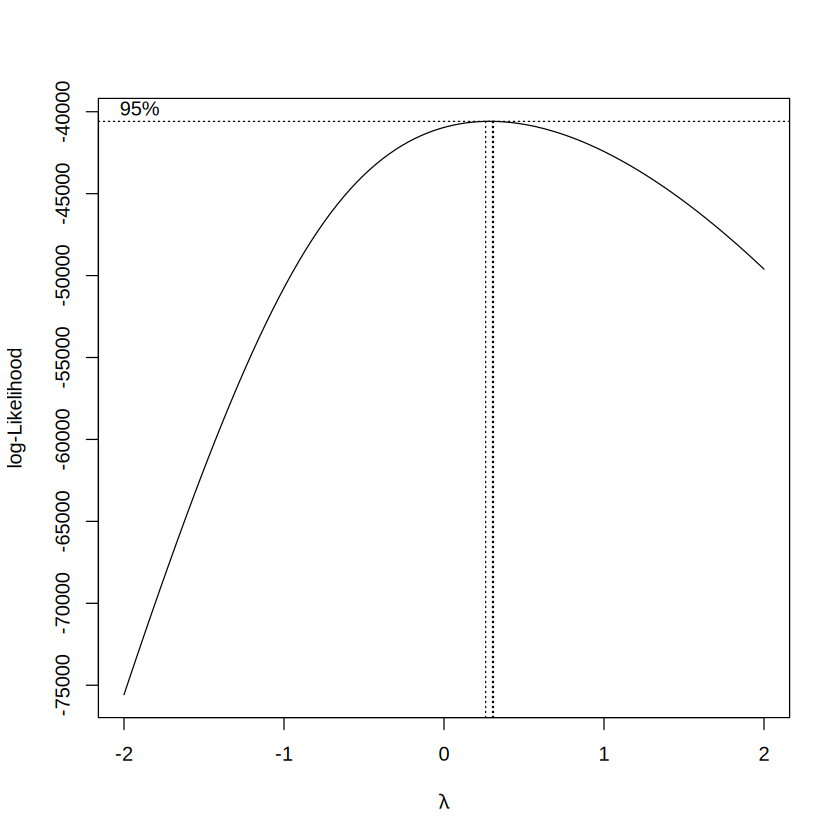

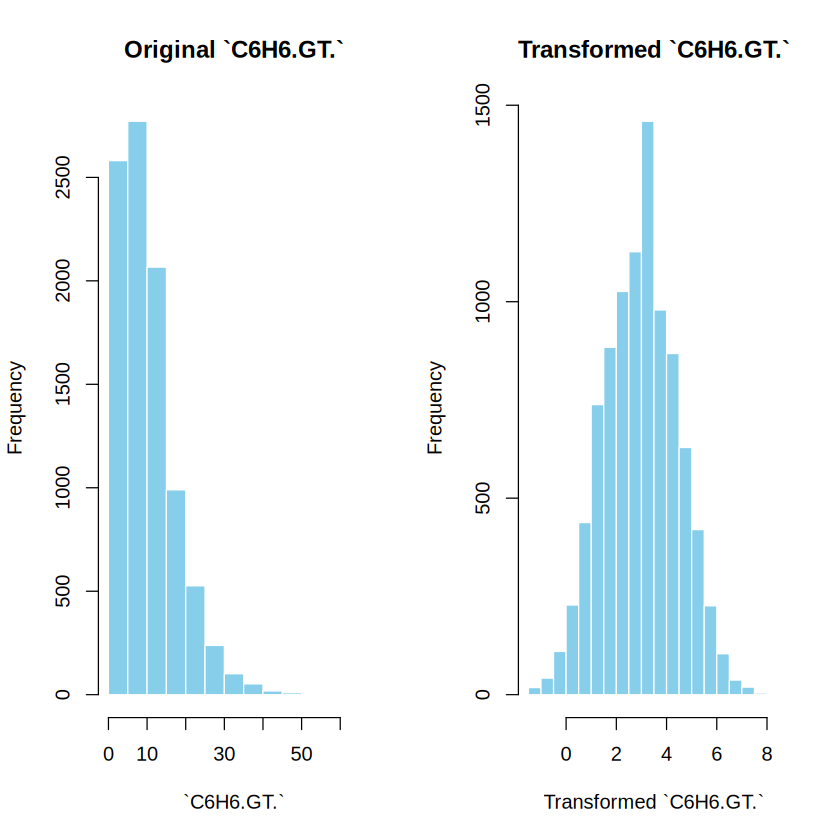

In [34]:
response_variable <- air_quality$`C6H6.GT.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `C6H6.GT.`", xlab = "`C6H6.GT.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `C6H6.GT.`", xlab = "Transformed `C6H6.GT.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### 5. PT08.S2(NMHC): Sensor response for NMHC

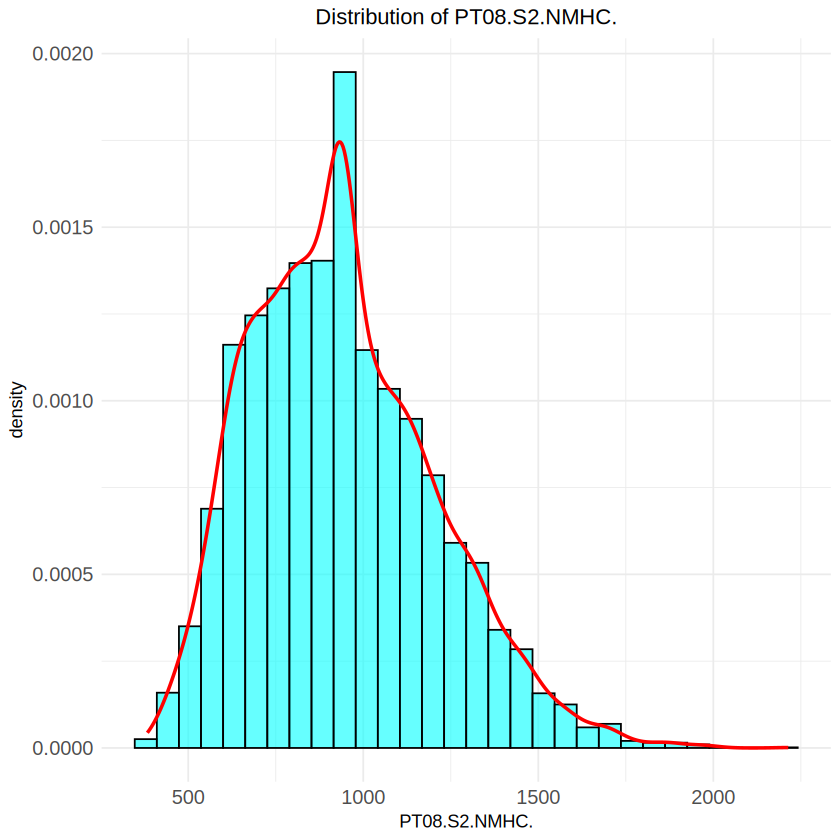

In [35]:
ggplot(air_quality, aes(x = `PT08.S2.NMHC.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of PT08.S2.NMHC.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

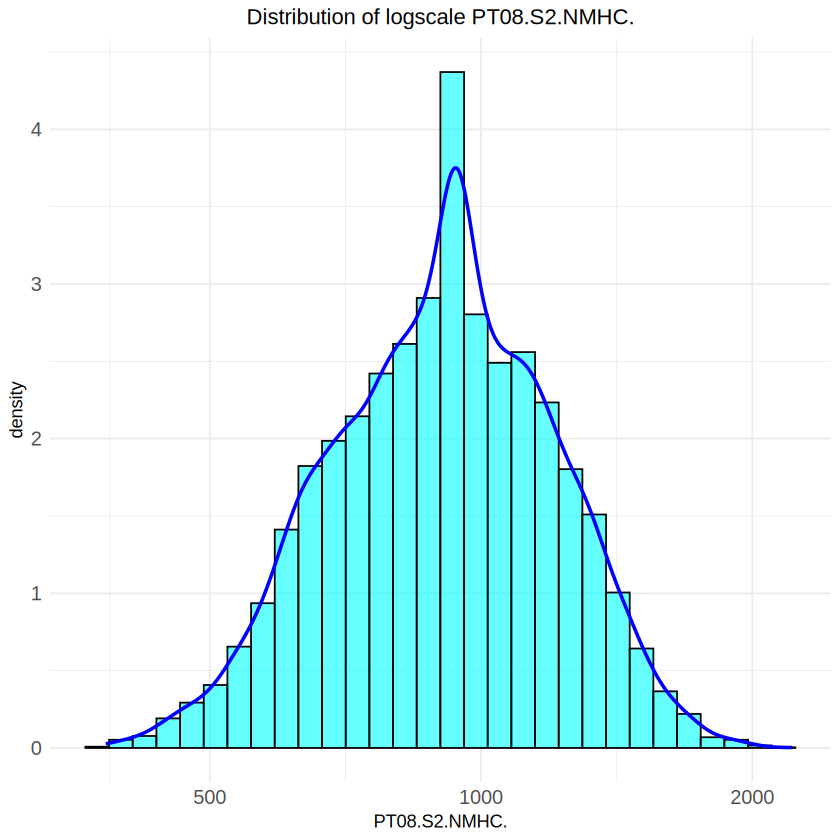

In [36]:
ggplot(air_quality, aes(x = `PT08.S2.NMHC.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale PT08.S2.NMHC.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.181818181818182"


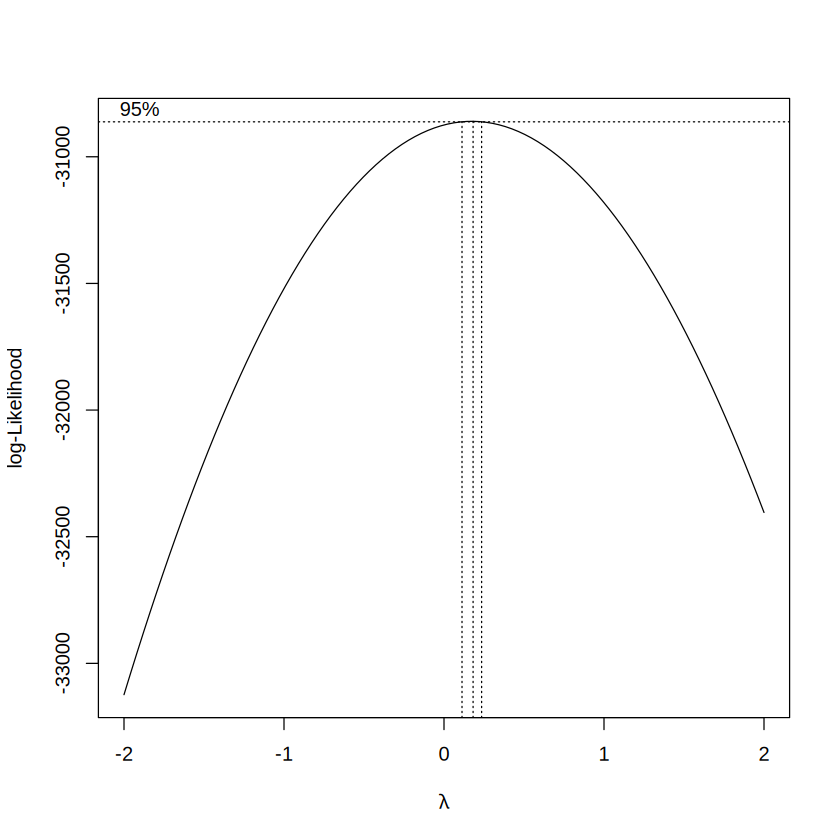

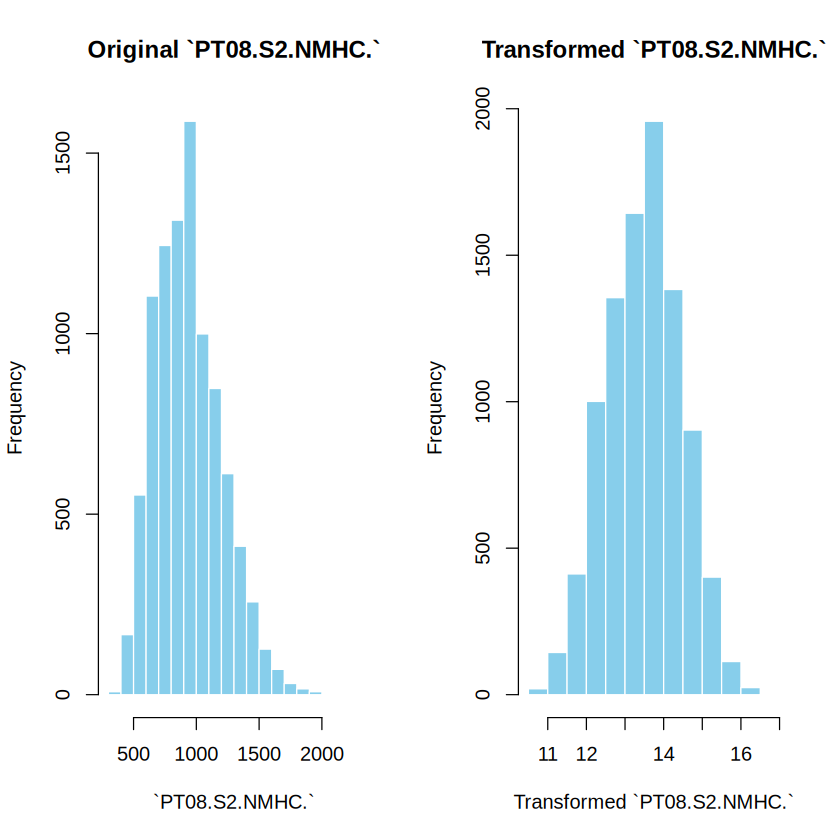

In [37]:
response_variable <- air_quality$`PT08.S2.NMHC.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `PT08.S2.NMHC.`", xlab = "`PT08.S2.NMHC.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `PT08.S2.NMHC.`", xlab = "Transformed `PT08.S2.NMHC.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### 6. NOx(GT): Nitrogen oxides concentration (ppb)

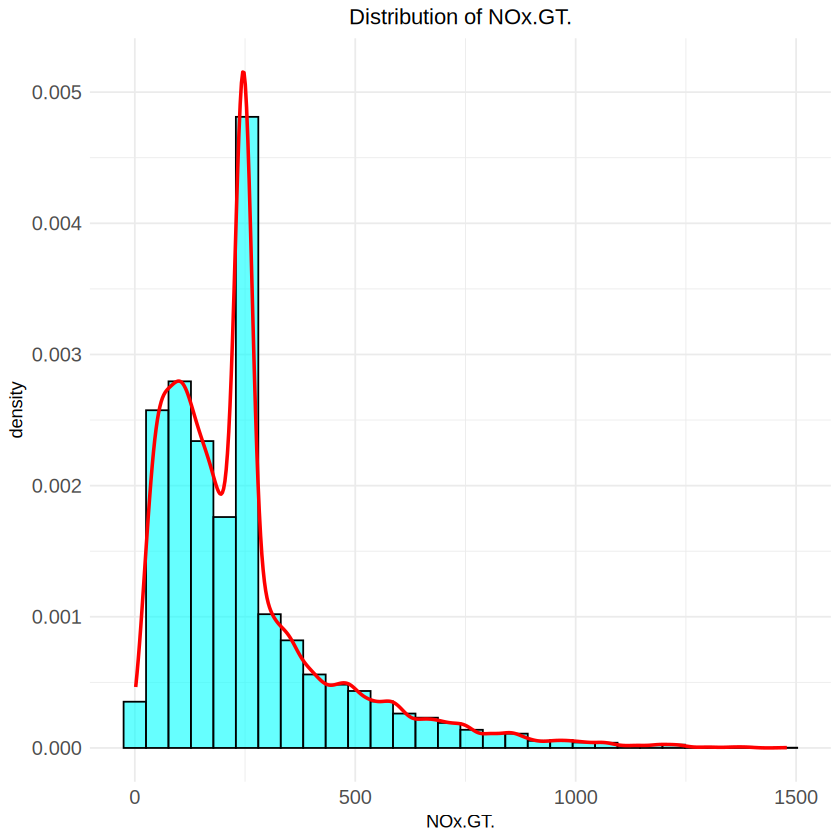

In [38]:
ggplot(air_quality, aes(x = `NOx.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of NOx.GT.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

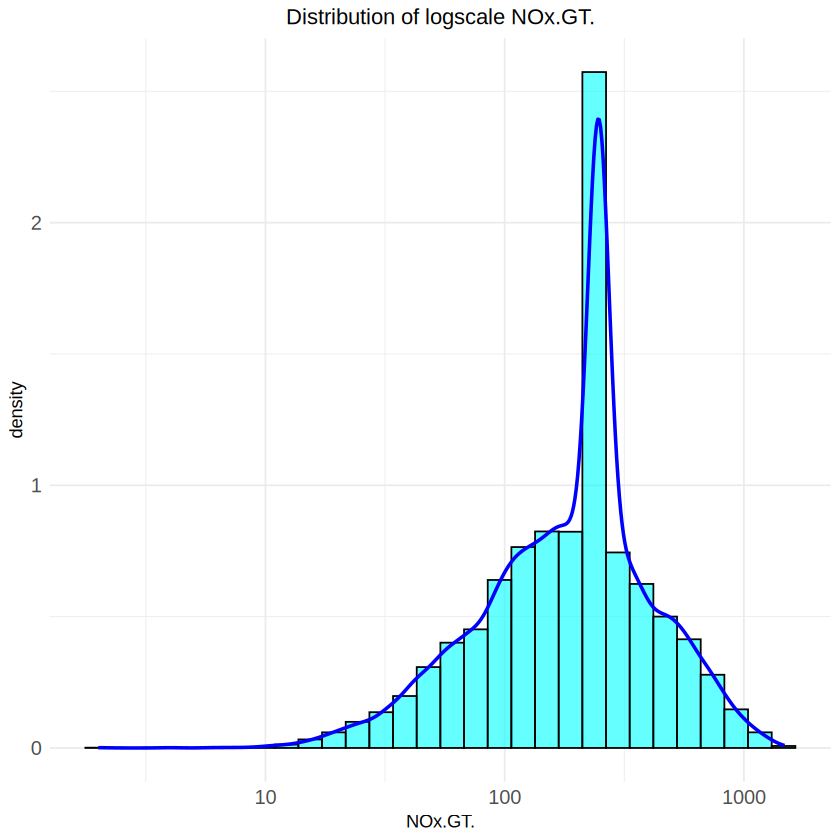

In [39]:
ggplot(air_quality, aes(x = `NOx.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale NOx.GT.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.222222222222222"


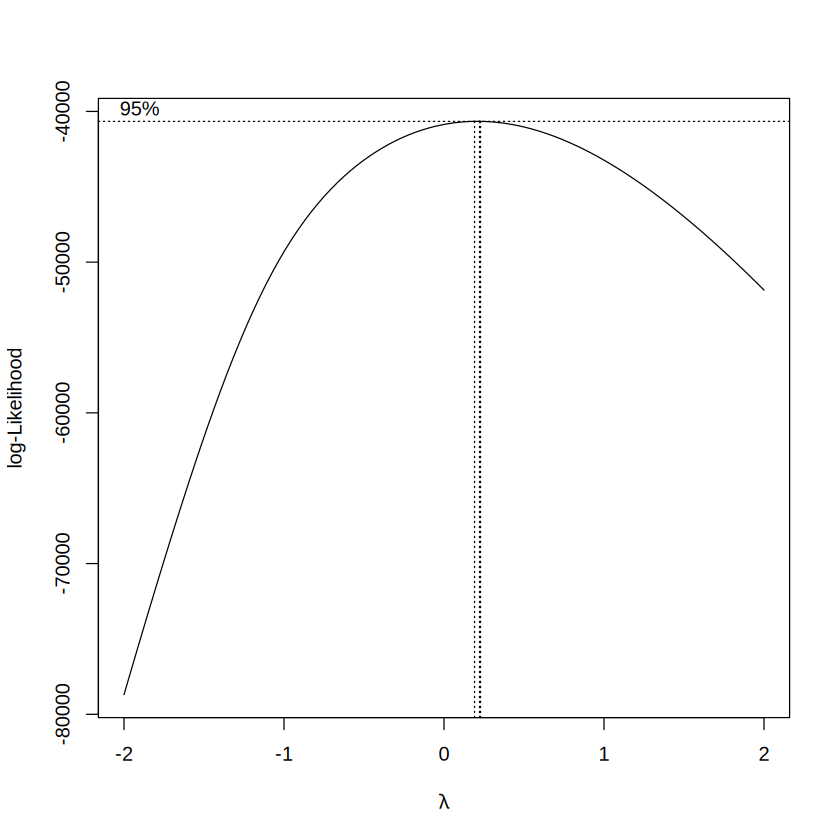

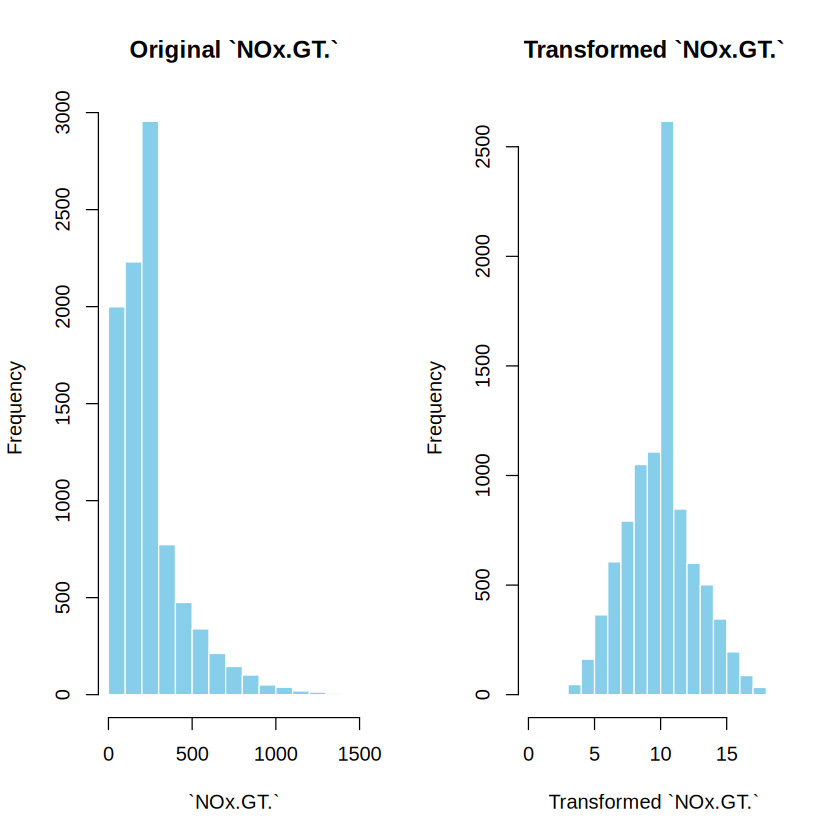

In [40]:
response_variable <- air_quality$`NOx.GT.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `NOx.GT.`", xlab = "`NOx.GT.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `NOx.GT.`", xlab = "Transformed `NOx.GT.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### 7. PT08.S3(NOx): Sensor response for NOx

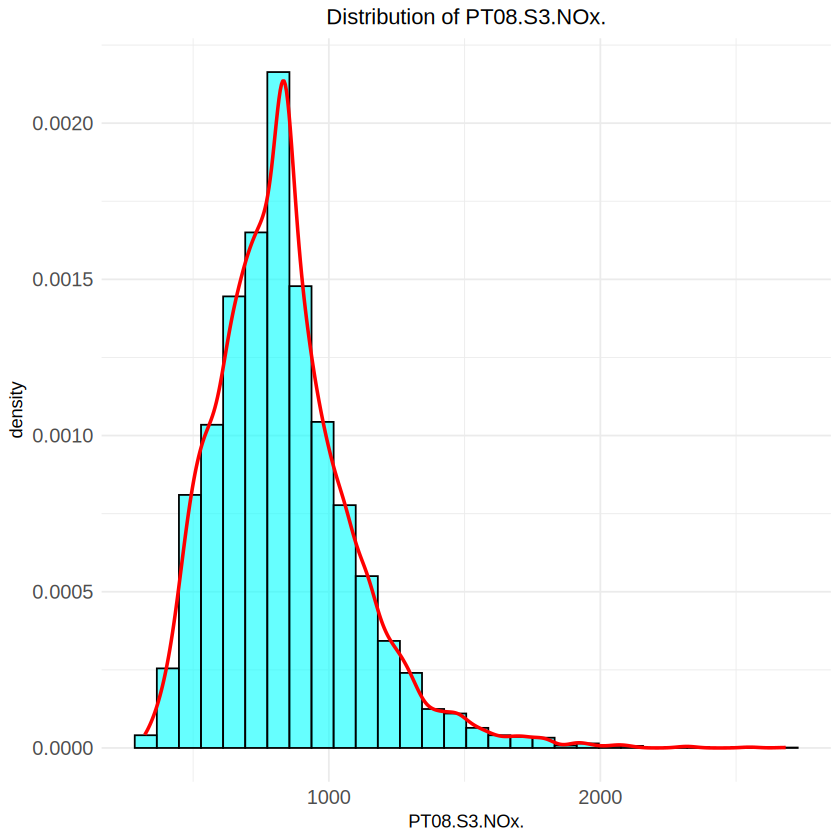

In [41]:
ggplot(air_quality, aes(x = `PT08.S3.NOx.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of PT08.S3.NOx.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

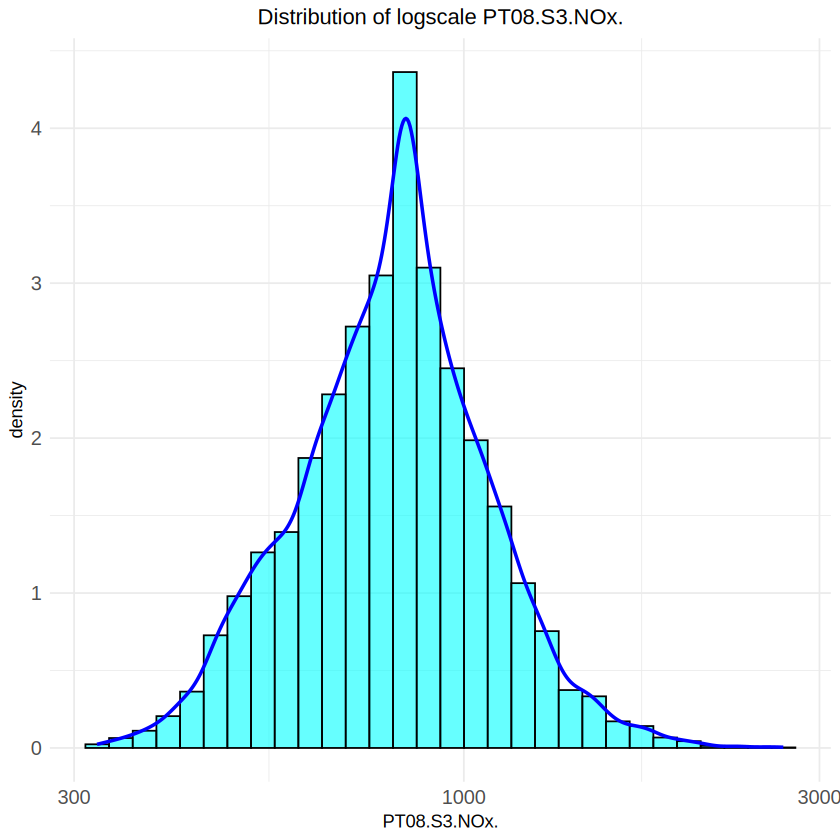

In [42]:
ggplot(air_quality, aes(x = `PT08.S3.NOx.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale PT08.S3.NOx.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  -0.0202020202020201"


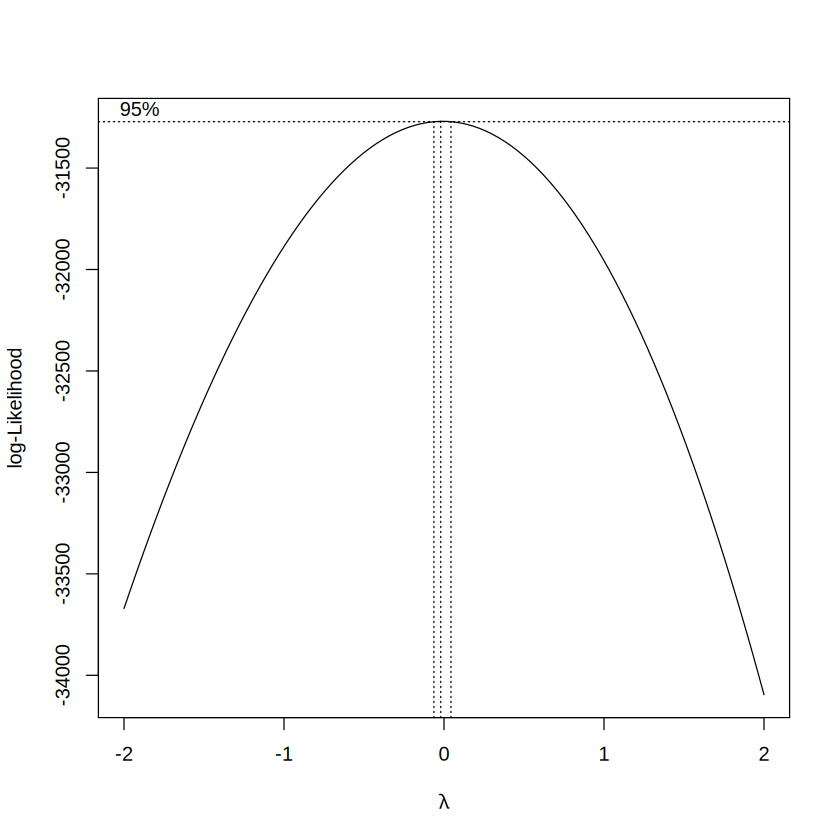

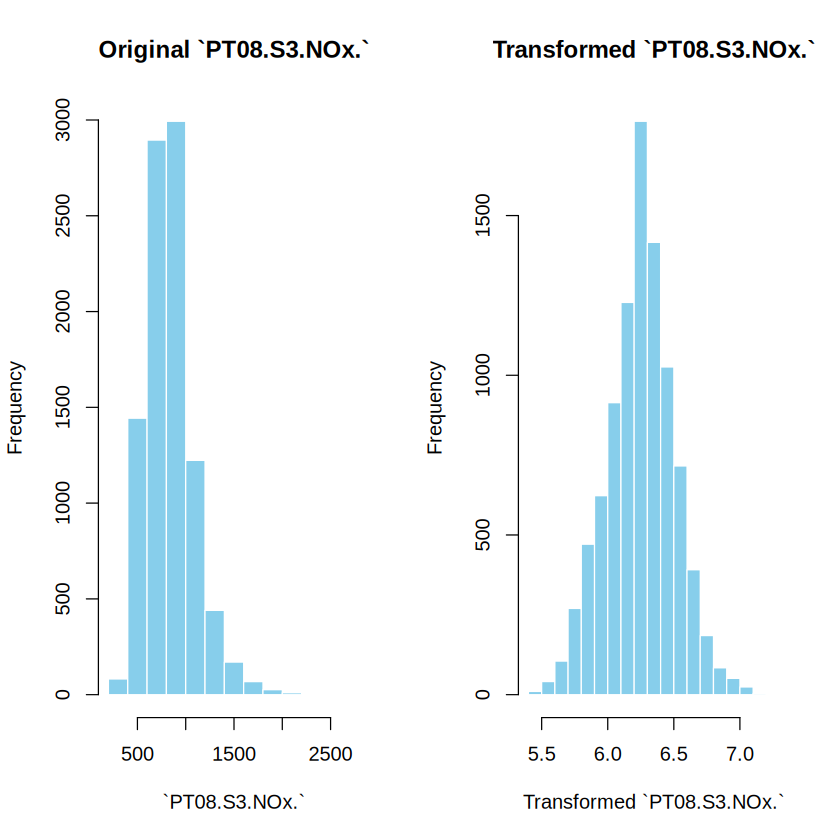

In [43]:
response_variable <- air_quality$`PT08.S3.NOx.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `PT08.S3.NOx.`", xlab = "`PT08.S3.NOx.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `PT08.S3.NOx.`", xlab = "Transformed `PT08.S3.NOx.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### 8. NO2(GT): Nitrogen dioxide concentration (μg/m³)

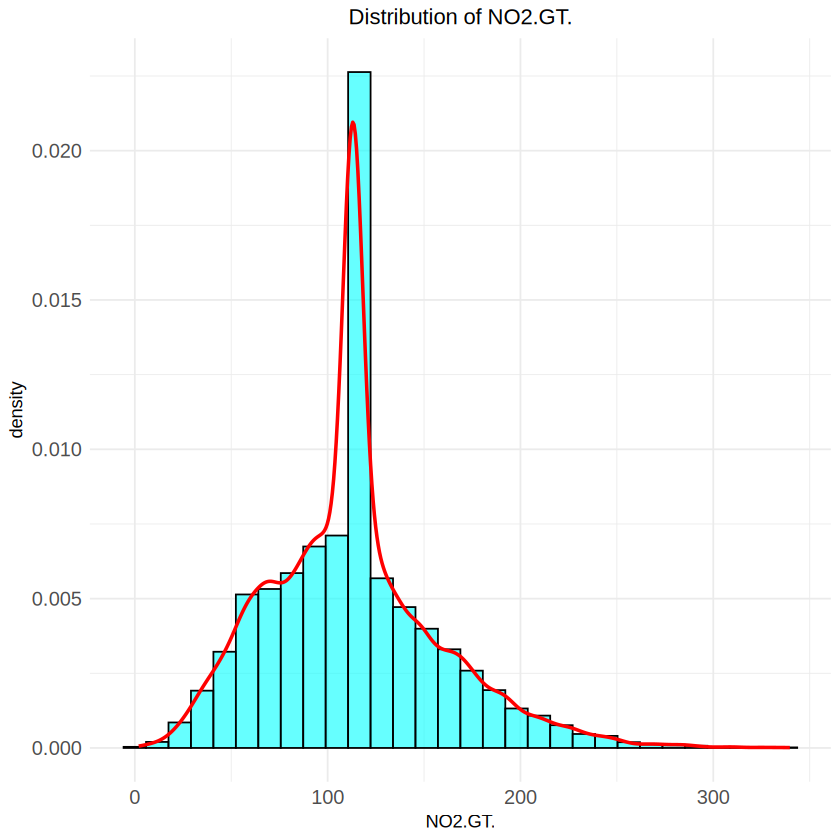

In [44]:
ggplot(air_quality, aes(x = `NO2.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of NO2.GT.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

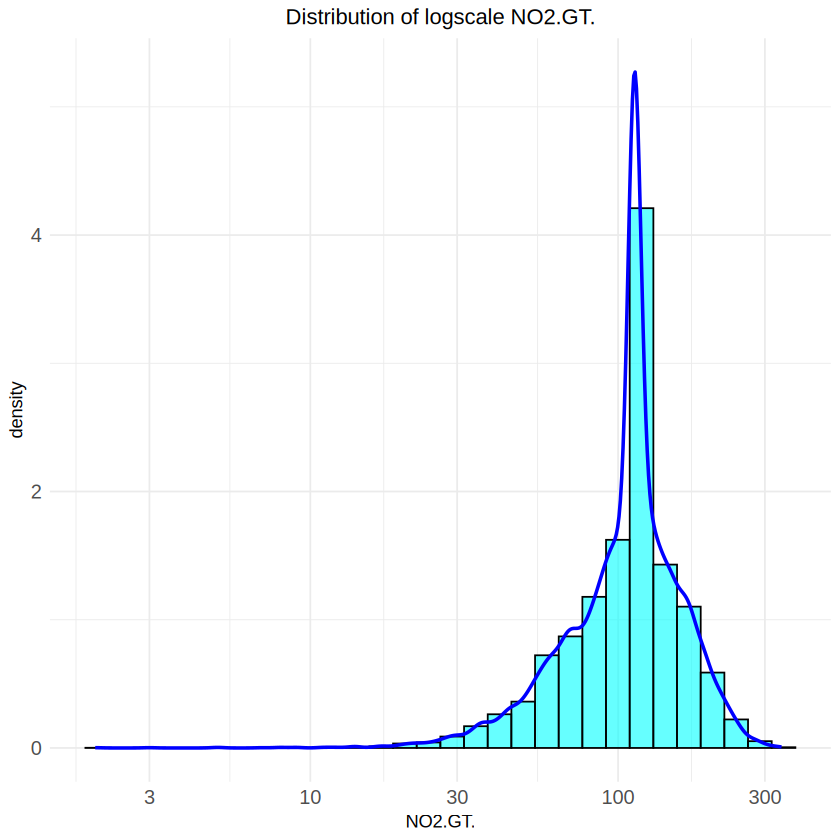

In [45]:
ggplot(air_quality, aes(x = `NO2.GT.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale NO2.GT.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.585858585858586"


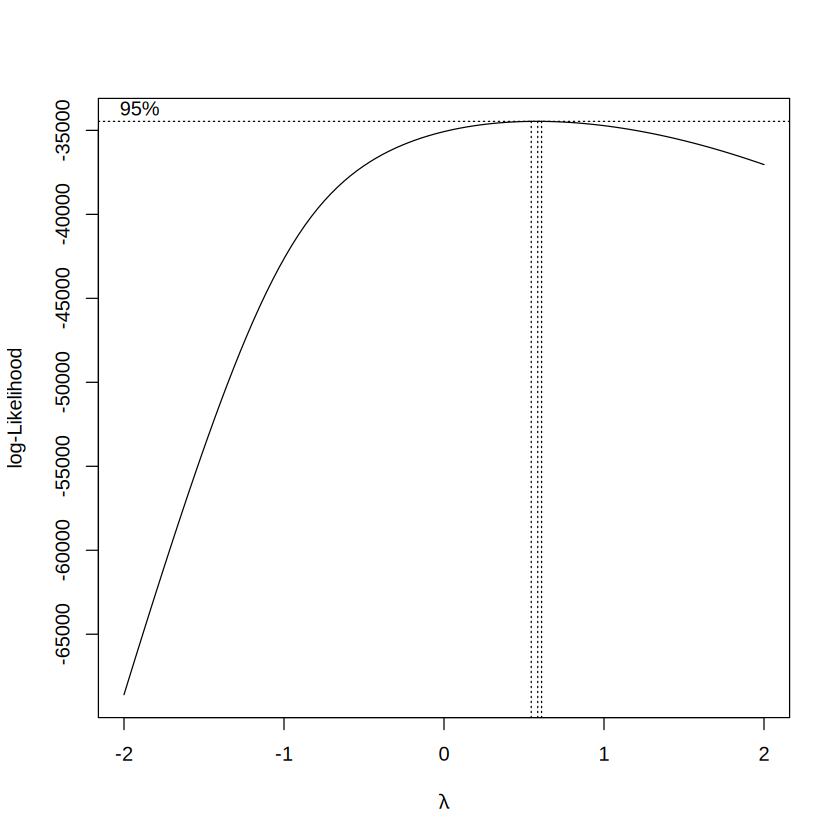

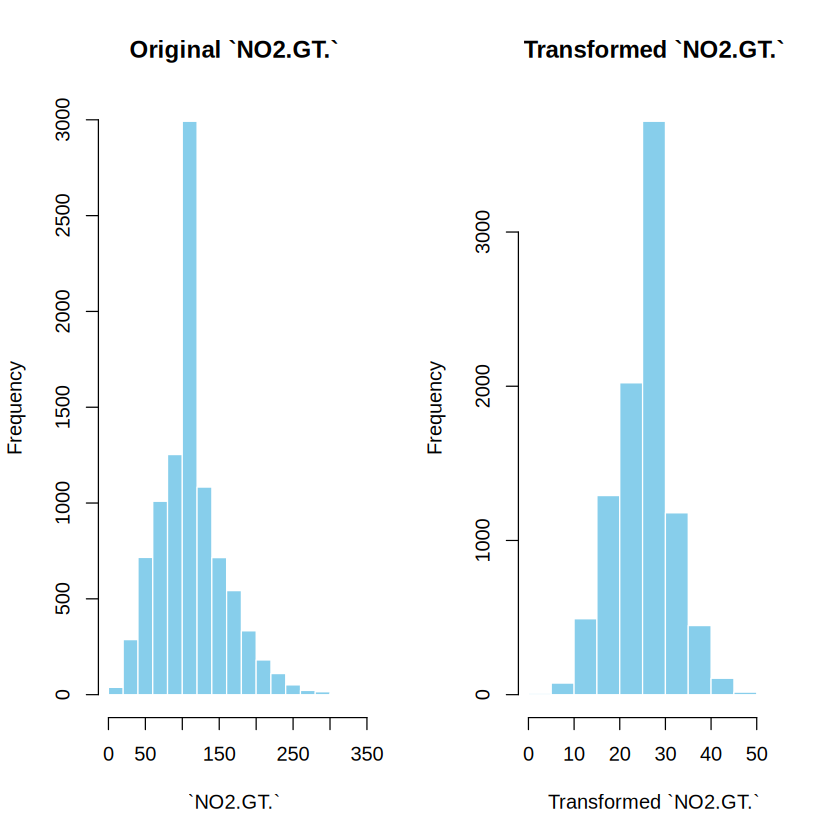

In [46]:
response_variable <- air_quality$`NO2.GT.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `NO2.GT.`", xlab = "`NO2.GT.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `NO2.GT.`", xlab = "Transformed `NO2.GT.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### 9. PT08.S4(NO2): Sensor response for NO2

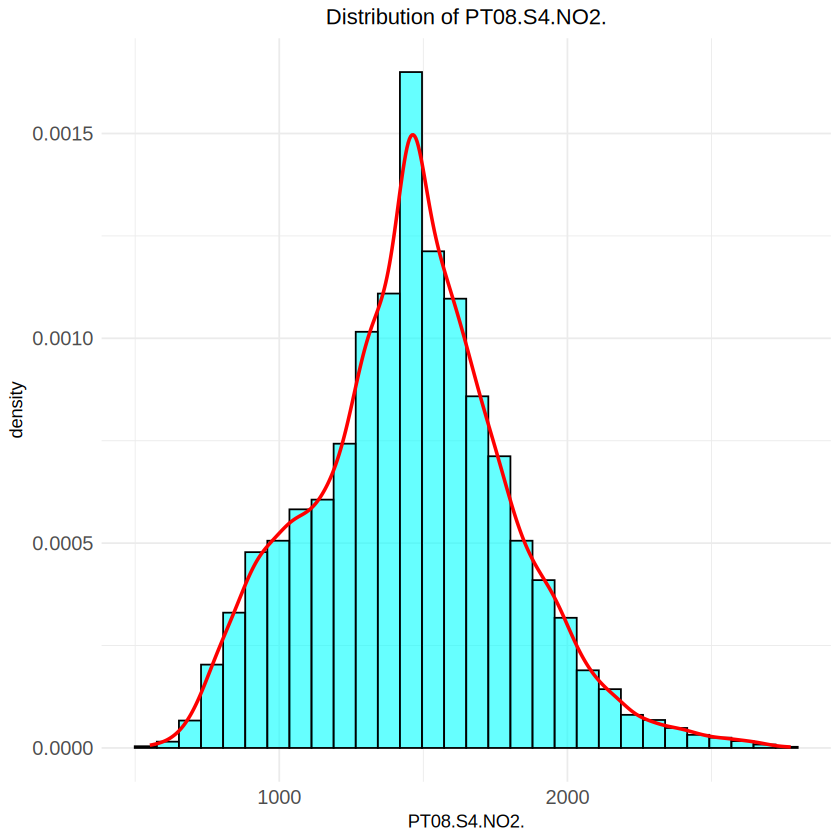

In [47]:
ggplot(air_quality, aes(x = `PT08.S4.NO2.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of PT08.S4.NO2.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

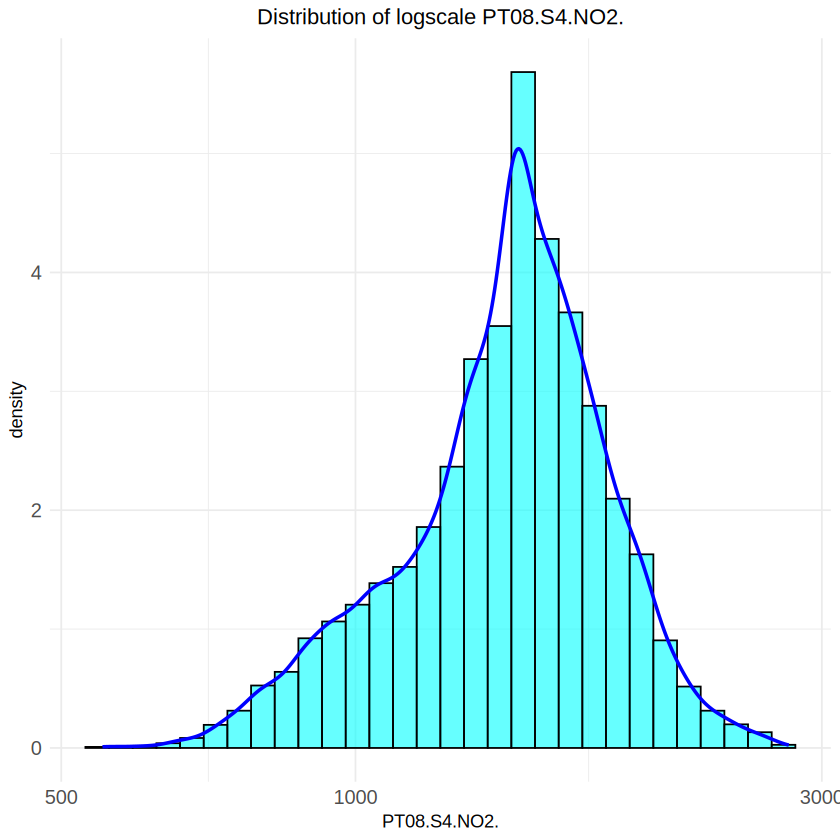

In [48]:
ggplot(air_quality, aes(x = `PT08.S4.NO2.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale PT08.S4.NO2.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.707070707070707"


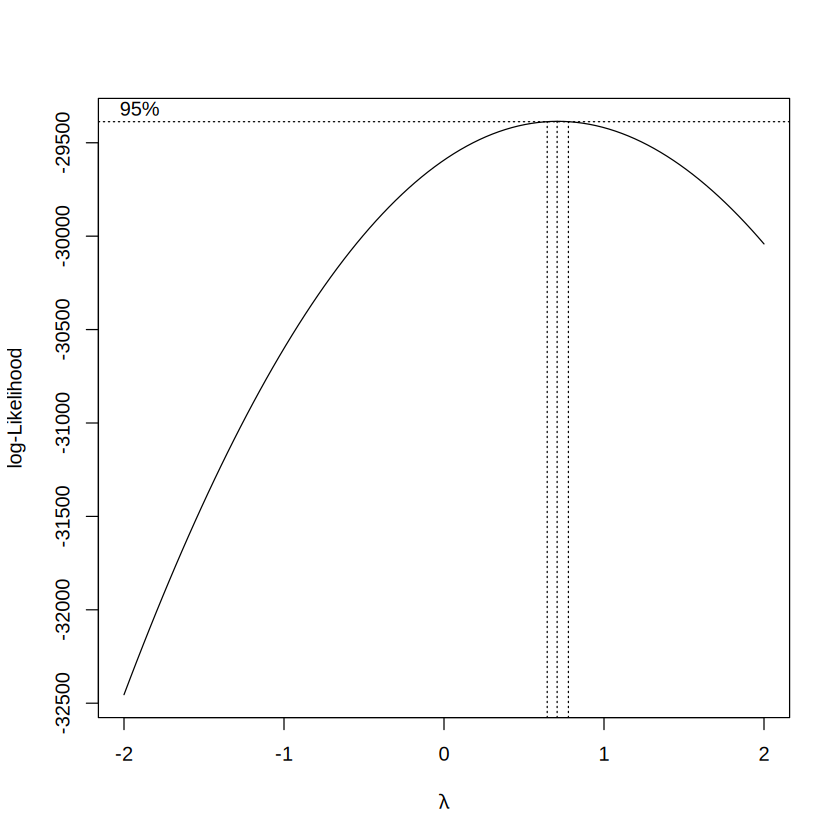

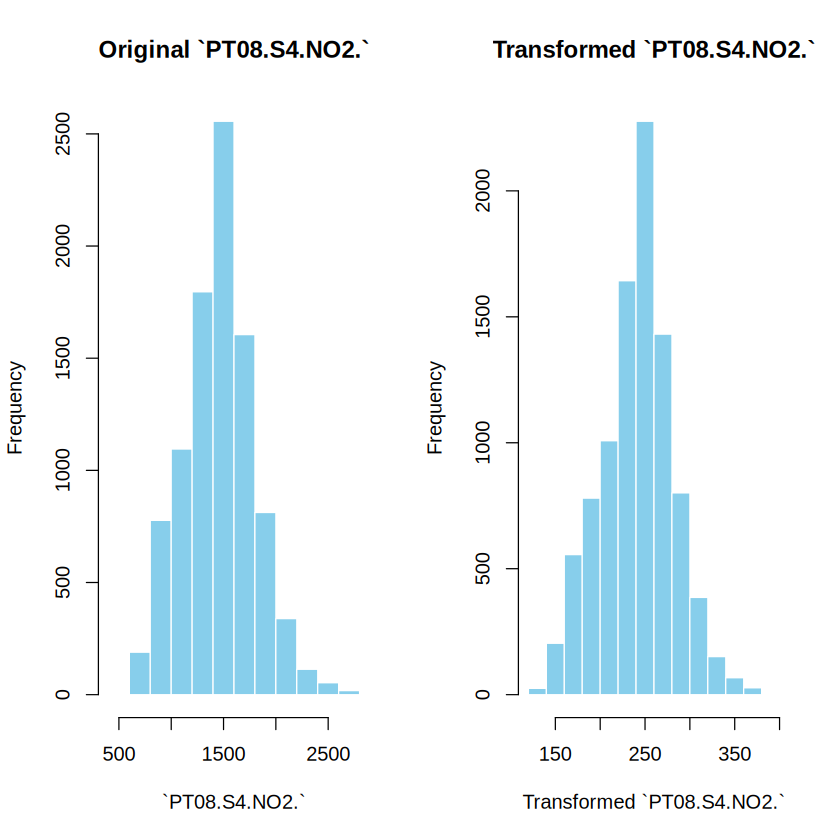

In [49]:
response_variable <- air_quality$`PT08.S4.NO2.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `PT08.S4.NO2.`", xlab = "`PT08.S4.NO2.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `PT08.S4.NO2.`", xlab = "Transformed `PT08.S4.NO2.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### 10. PT08.S5(O3): Sensor response for ozone

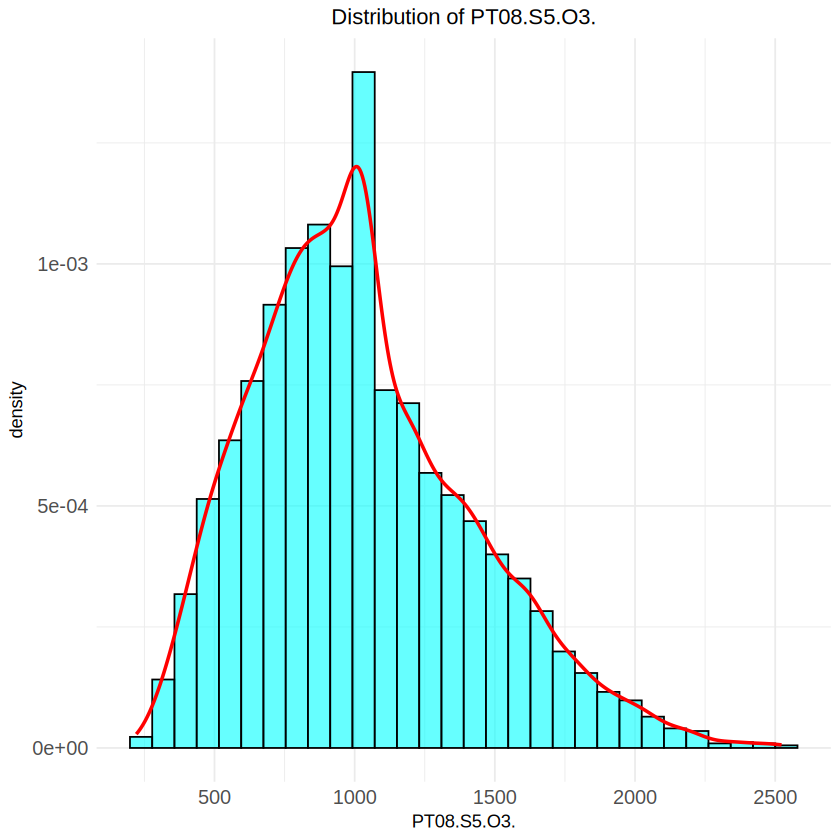

In [50]:
ggplot(air_quality, aes(x = `PT08.S5.O3.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of PT08.S5.O3.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

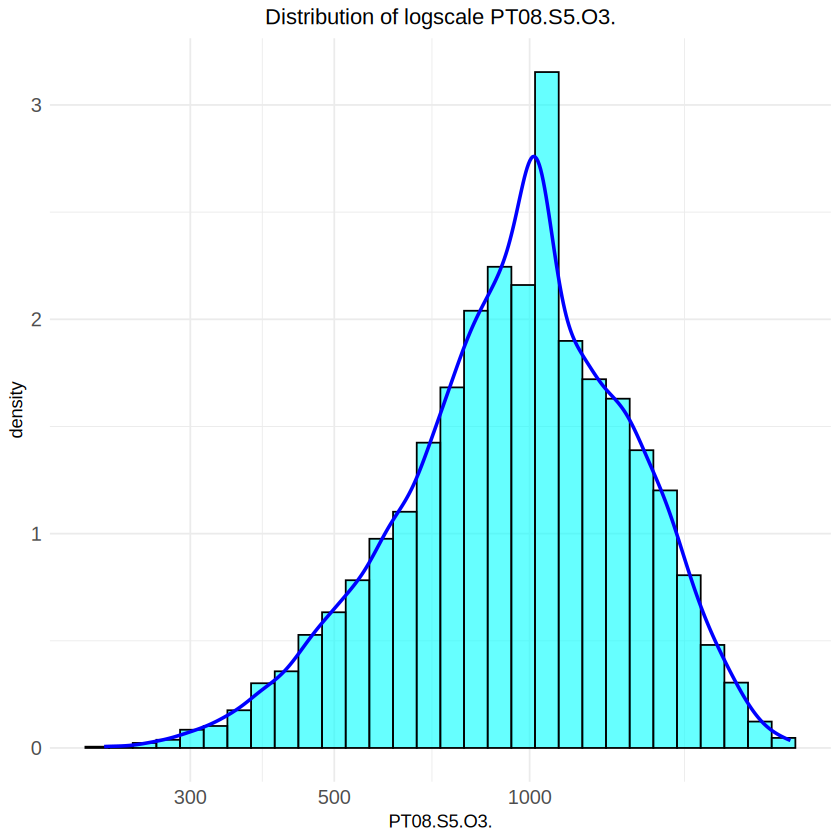

In [51]:
ggplot(air_quality, aes(x = `PT08.S5.O3.`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale PT08.S5.O3.") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.343434343434343"


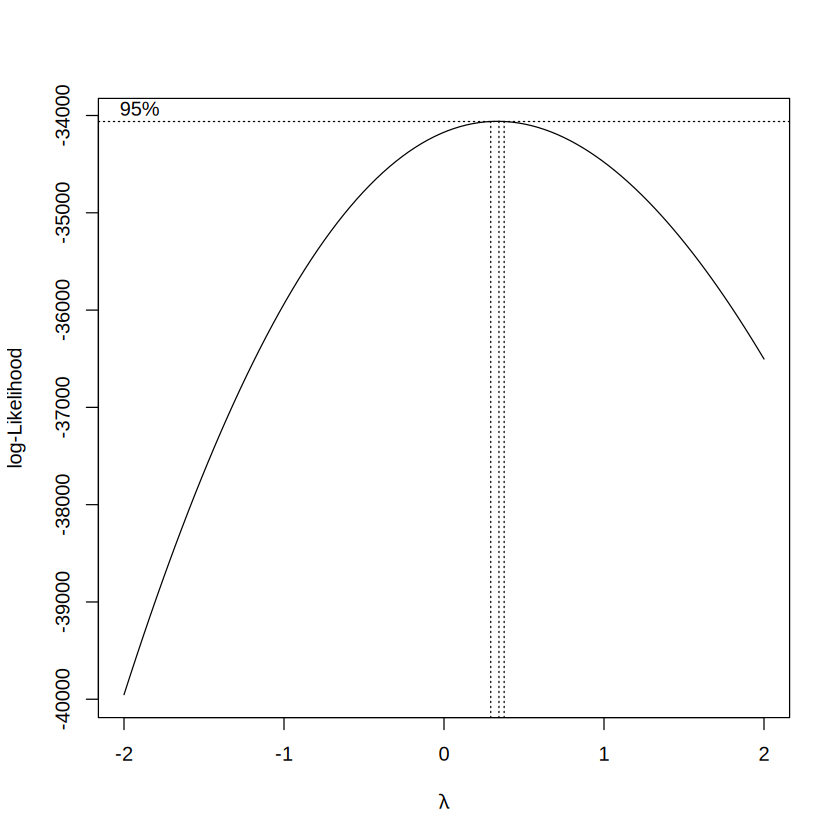

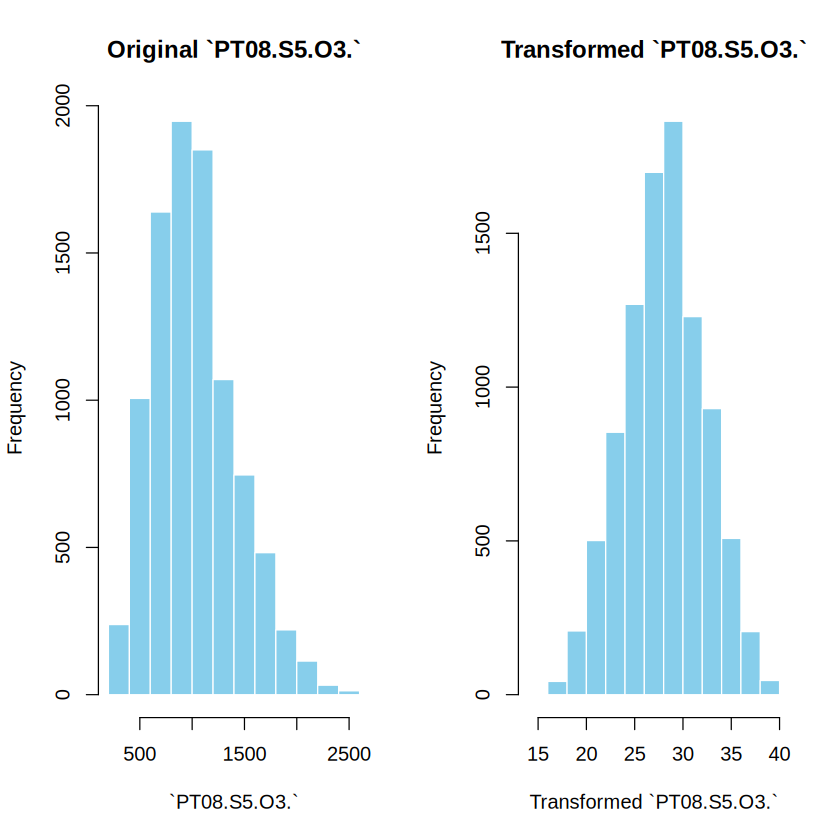

In [52]:
response_variable <- air_quality$`PT08.S5.O3.`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `PT08.S5.O3.`", xlab = "`PT08.S5.O3.`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `PT08.S5.O3.`", xlab = "Transformed `PT08.S5.O3.`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### 11. T: Temperature (°C)

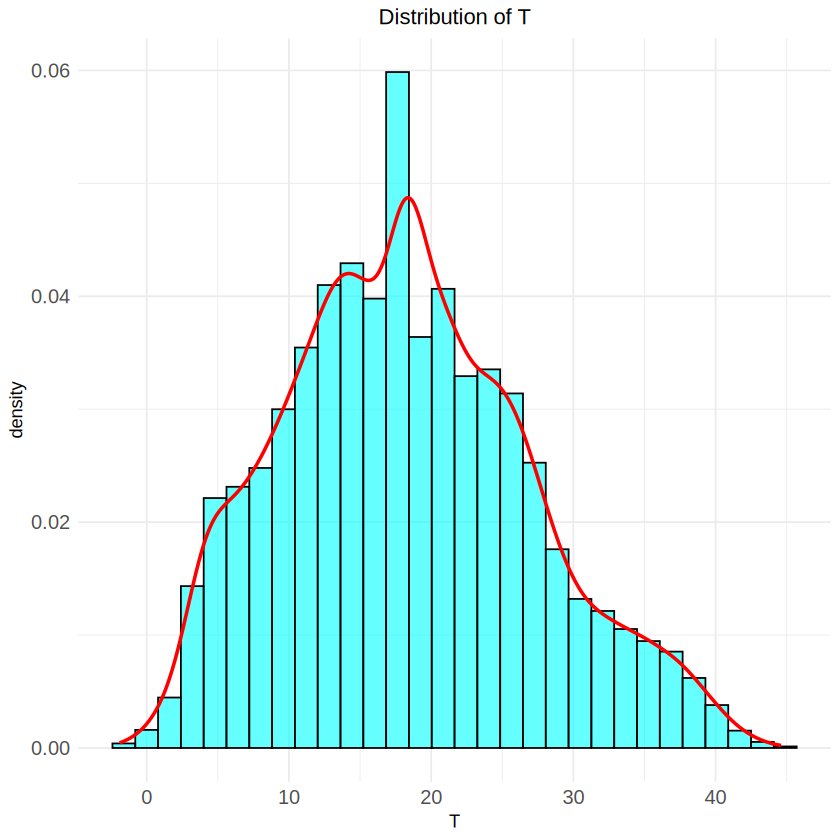

In [53]:
ggplot(air_quality, aes(x = `T`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of T") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

Warning message in transformation$transform(x):
“NaNs produced”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in transformation$transform(x):
“NaNs produced”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 14 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 14 rows containing non-finite outside the scale range
(`stat_density()`).”


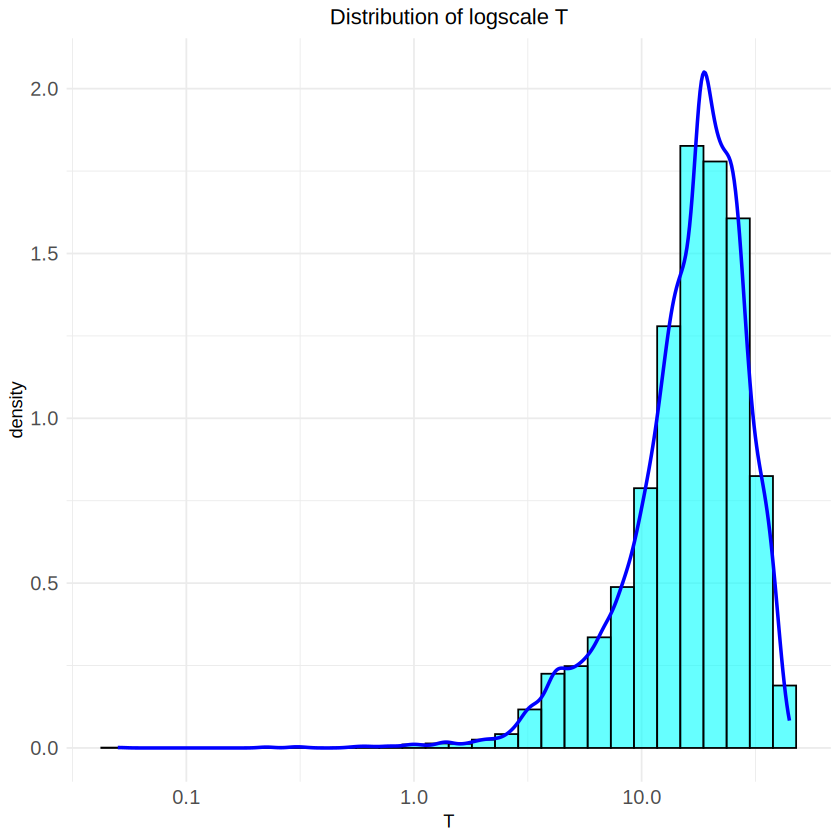

In [54]:
ggplot(air_quality, aes(x = `T`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale T") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.626262626262626"


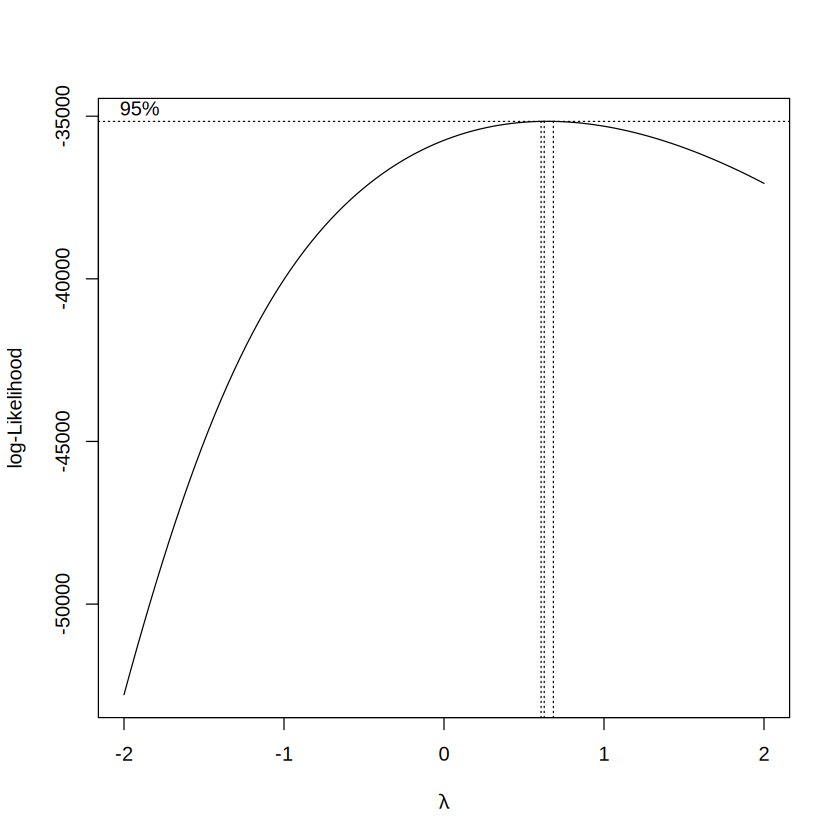

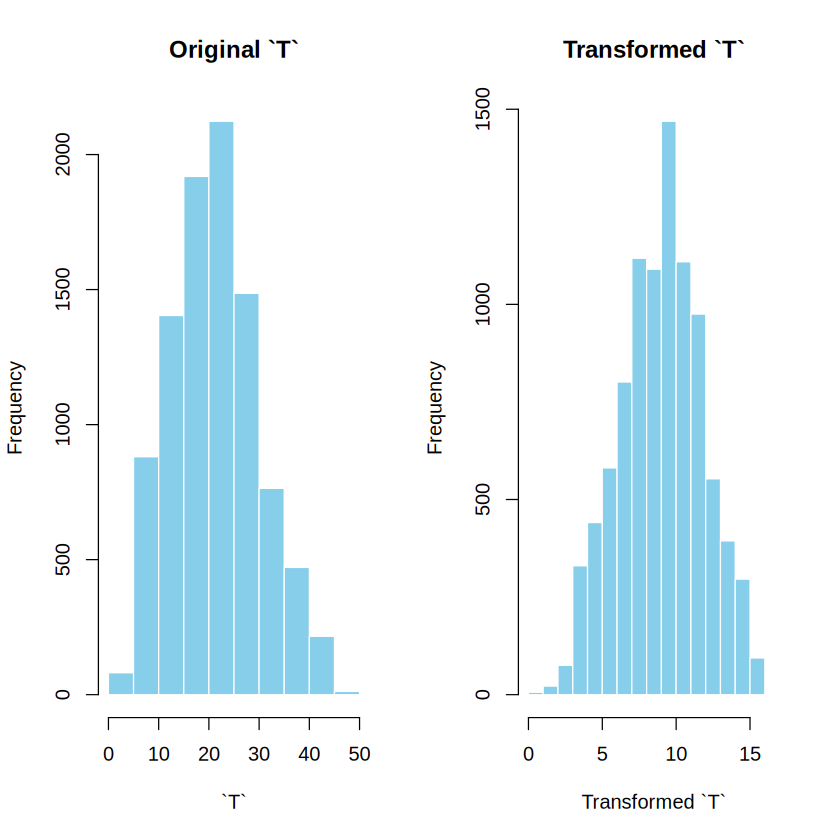

In [55]:
response_variable <- air_quality$`T`

shift_value <- abs(min(response_variable)) + 1
response_variable <- response_variable + shift_value

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `T`", xlab = "`T`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `T`", xlab = "Transformed `T`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### 12. RH: Relative humidity (%)

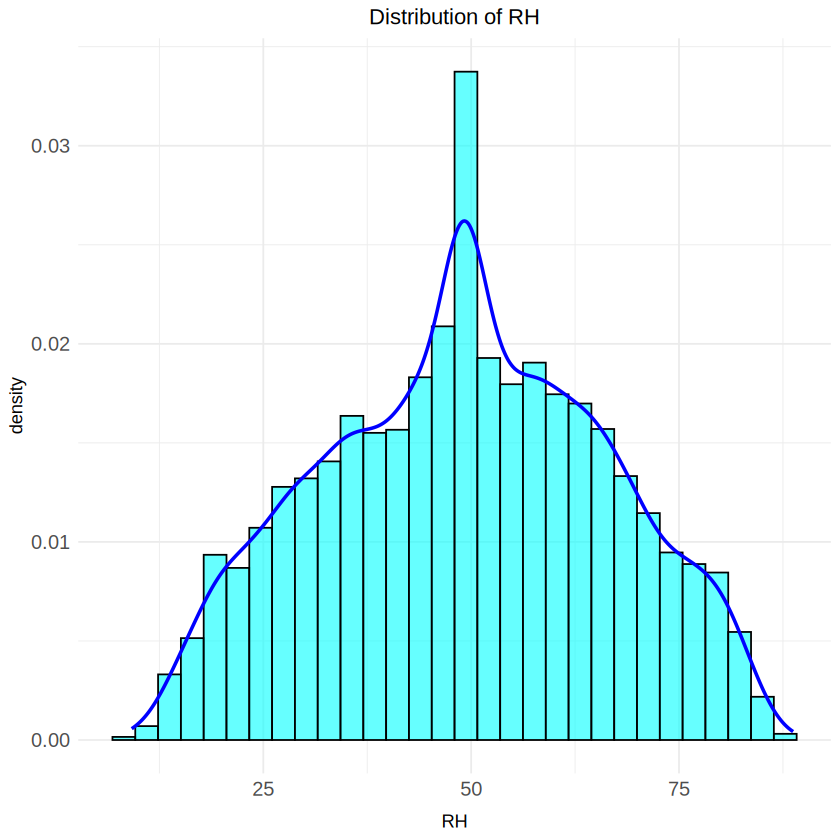

In [56]:
ggplot(air_quality, aes(x = `RH`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of RH") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

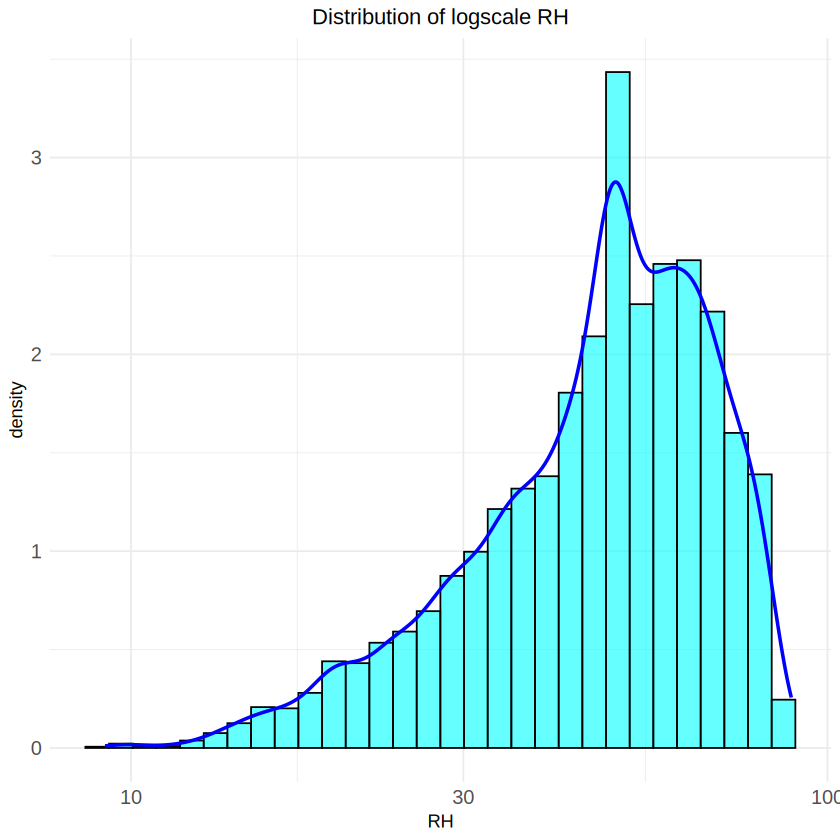

In [57]:
ggplot(air_quality, aes(x = `RH`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale RH") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.909090909090909"


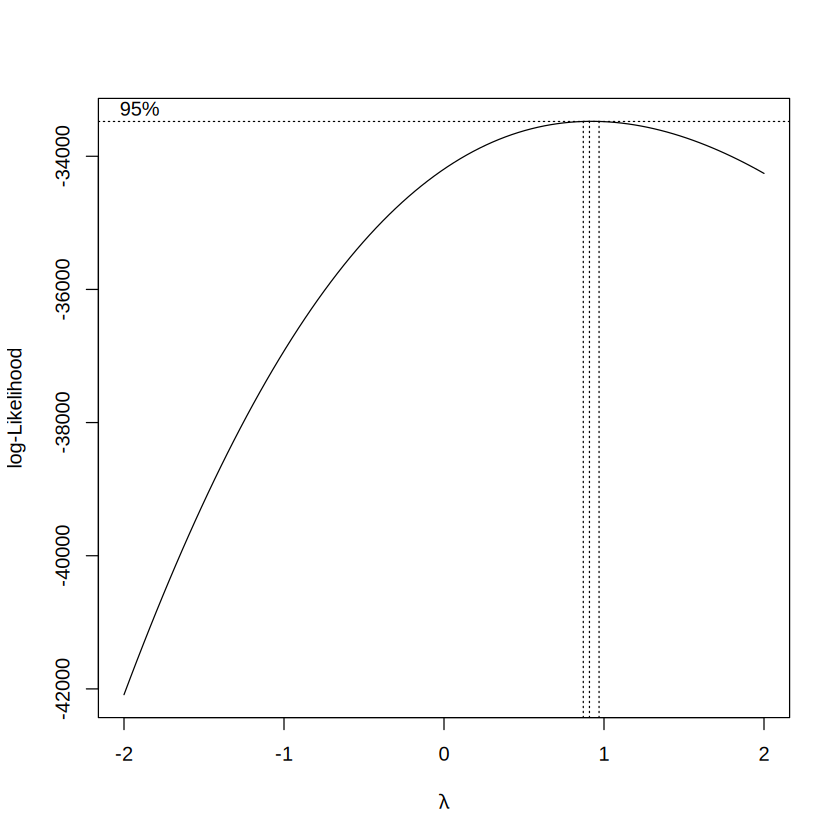

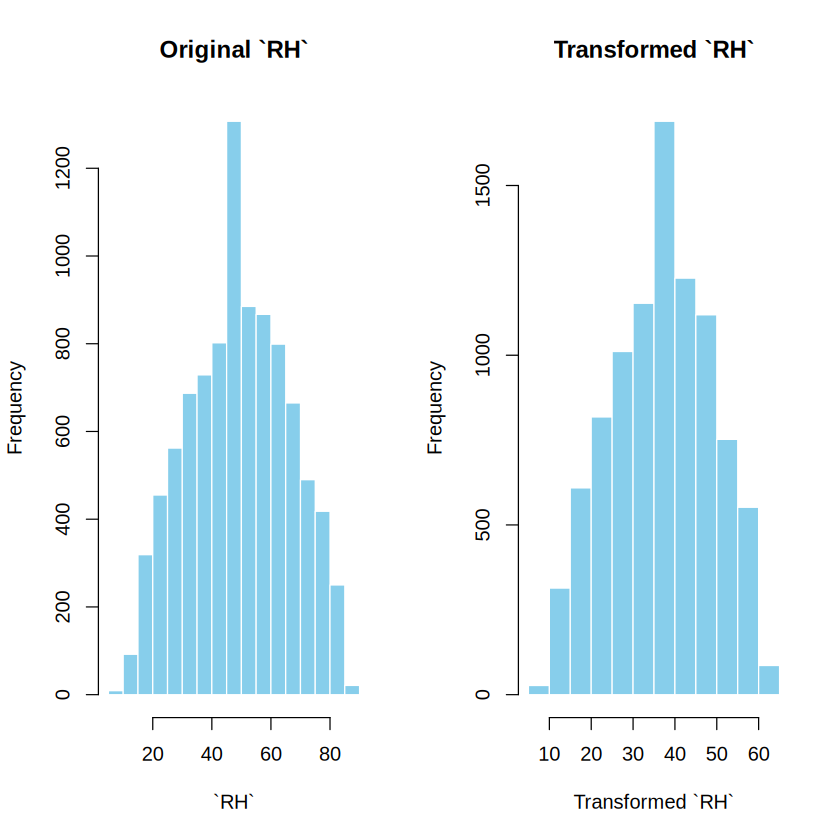

In [58]:
response_variable <- air_quality$`RH`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `RH`", xlab = "`RH`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `RH`", xlab = "Transformed `RH`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### 13. AH: Absolute humidity (g/m³)

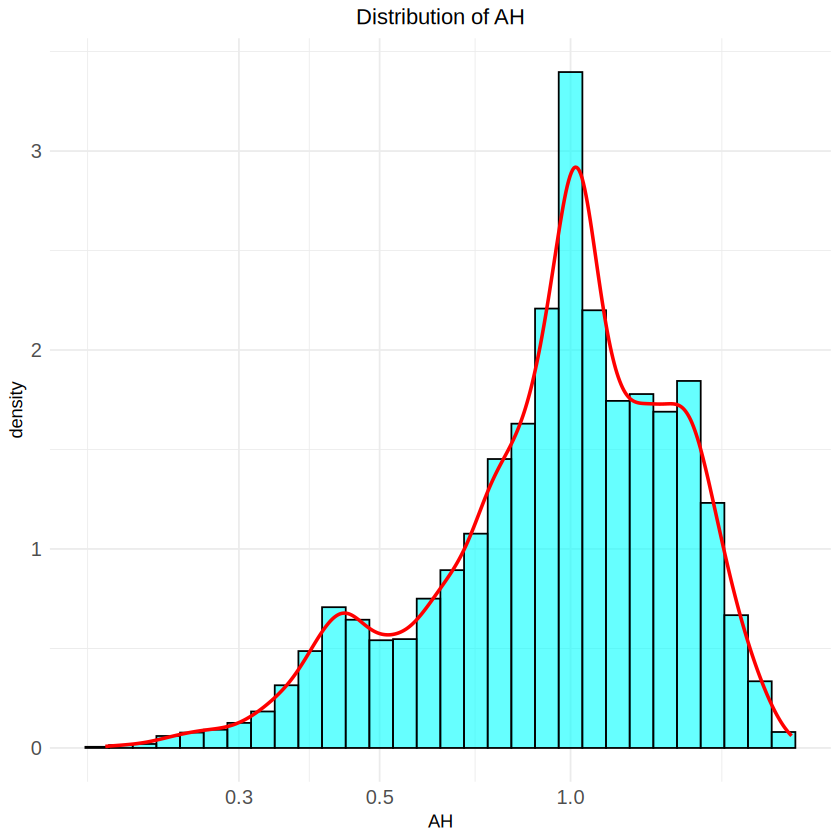

In [59]:
ggplot(air_quality, aes(x = `AH`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of AH") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

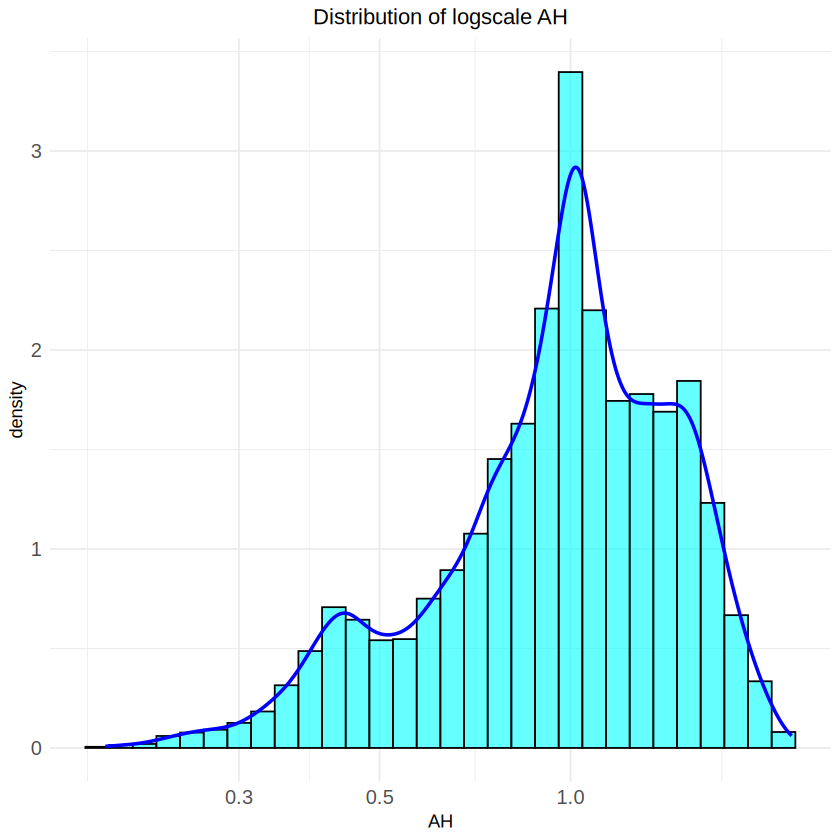

In [60]:
ggplot(air_quality, aes(x = `AH`)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale AH") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.666666666666667"


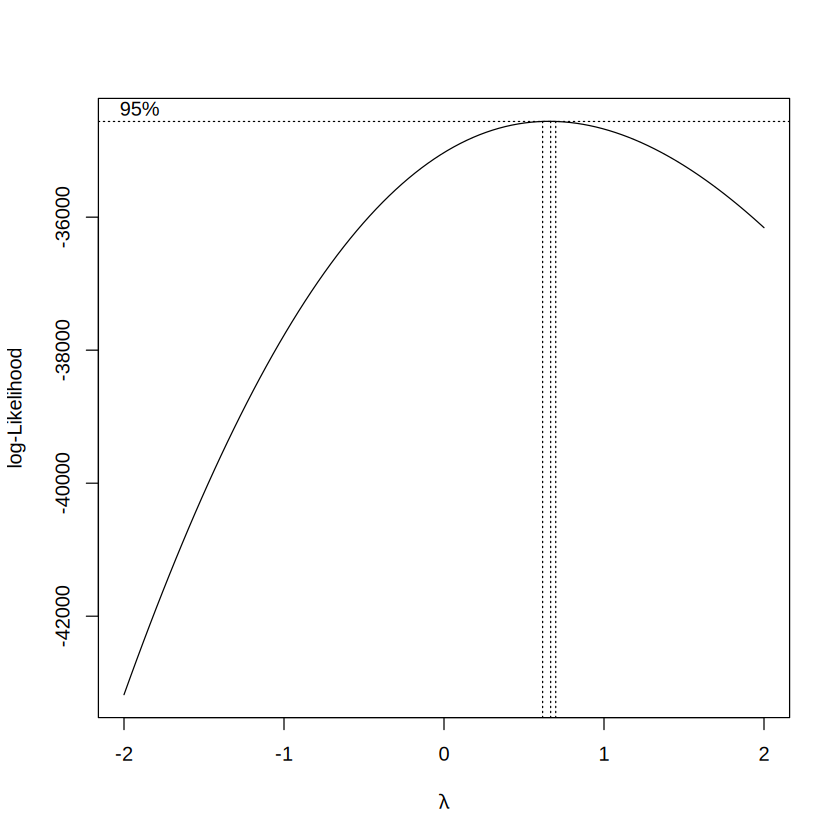

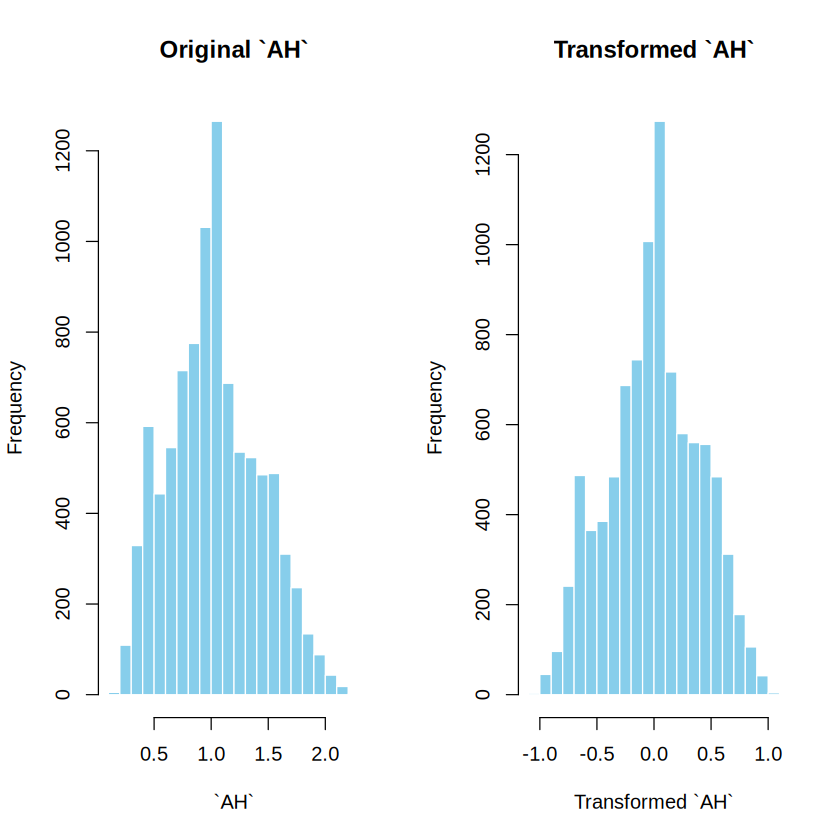

In [61]:
response_variable <- air_quality$`AH`

response_variable <- ifelse(response_variable == 0, response_variable + 1, response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original `AH`", xlab = "`AH`", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed `AH`", xlab = "Transformed `AH`", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

## Phân tích đa biến

### Tương quan giữa các biến

In [62]:
cor_matrix <- cor(air_quality[, -c(14, 15)])
cor_matrix

CO.GT.      PT08.S1.CO. NMHC.GT.    C6H6.GT.    PT08.S2.NMHC.
CO.GT.         1.00000000  0.7733943   0.28997516  0.81239231  0.79558637  
PT08.S1.CO.    0.77339429  1.0000000   0.27828805  0.88382089  0.89297245  
NMHC.GT.       0.28997516  0.2782880   1.00000000  0.28192285  0.27975111  
C6H6.GT.       0.81239231  0.8838209   0.28192285  1.00000000  0.98196203  
PT08.S2.NMHC.  0.79558637  0.8929724   0.27975111  0.98196203  1.00000000  
NOx.GT.        0.76229720  0.6159736   0.09818457  0.61687961  0.60181206  
PT08.S3.NOx.  -0.61387028 -0.7719181  -0.26198519 -0.73571121 -0.79668731  
NO2.GT.        0.64652757  0.5629969   0.15654891  0.53617833  0.56142083  
PT08.S4.NO2.   0.55822459  0.6828739   0.23298307  0.76571684  0.77723483  
PT08.S5.O3.    0.75902658  0.8993259   0.24059378  0.86572663  0.88059027  
T              0.02026043  0.0486276   0.06680899  0.19889091  0.24132968  
RH             0.04320350  0.1146073  -0.05279411 -0.06164347 -0.09035172  
AH             0.04327259  0.1353227   0.03717300  0.16790885  0.18690569  
              NOx.GT.     PT08.S3.NOx. NO2.GT.     PT08.S4.NO2. PT08.S5.O3.
CO.GT.         0.76229720 -0.61387028   0.64652757  0.55822459   0.75902658
PT08.S1.CO.    0.61597363 -0.77191812   0.56299691  0.68287389   0.89932594
NMHC.GT.       0.09818457 -0.26198519   0.15654891  0.23298307   0.24059378
C6H6.GT.       0.61687961 -0.73571121   0.53617833  0.76571684   0.86572663
PT08.S2.NMHC.  0.60181206 -0.79668731   0.56142083  0.77723483   0.88059027
NOx.GT.        1.00000000 -0.56325927   0.76313286  0.20552565   0.68821380
PT08.S3.NOx.  -0.56325927  1.00000000  -0.56953458 -0.53846012  -0.79655364
NO2.GT.        0.76313286 -0.56953458   1.00000000  0.14093950   0.62956418
PT08.S4.NO2.   0.20552565 -0.53846012   0.14093950  1.00000000   0.59113739
PT08.S5.O3.    0.68821380 -0.79655364   0.62956418  0.59113739   1.00000000
T             -0.23565652 -0.14513301  -0.16531710  0.56133337  -0.02719336
RH             0.19257781 -0.05672984  -0.08064472 -0.03218809   0.12495163
AH            -0.12683093 -0.23202063  -0.29119971  0.62964357   0.07073801
              T           RH          AH         
CO.GT.         0.02026043  0.04320350  0.04327259
PT08.S1.CO.    0.04862760  0.11460732  0.13532268
NMHC.GT.       0.06680899 -0.05279411  0.03717300
C6H6.GT.       0.19889091 -0.06164347  0.16790885
PT08.S2.NMHC.  0.24132968 -0.09035172  0.18690569
NOx.GT.       -0.23565652  0.19257781 -0.12683093
PT08.S3.NOx.  -0.14513301 -0.05672984 -0.23202063
NO2.GT.       -0.16531710 -0.08064472 -0.29119971
PT08.S4.NO2.   0.56133337 -0.03218809  0.62964357
PT08.S5.O3.   -0.02719336  0.12495163  0.07073801
T              1.00000000 -0.57856879  0.65647138
RH            -0.57856879  1.00000000  0.16797092
AH             0.65647138  0.16797092  1.00000000

corrplot 0.92 loaded


Attaching package: ‘corrplot’


The following object is masked from ‘package:pls’:

    corrplot




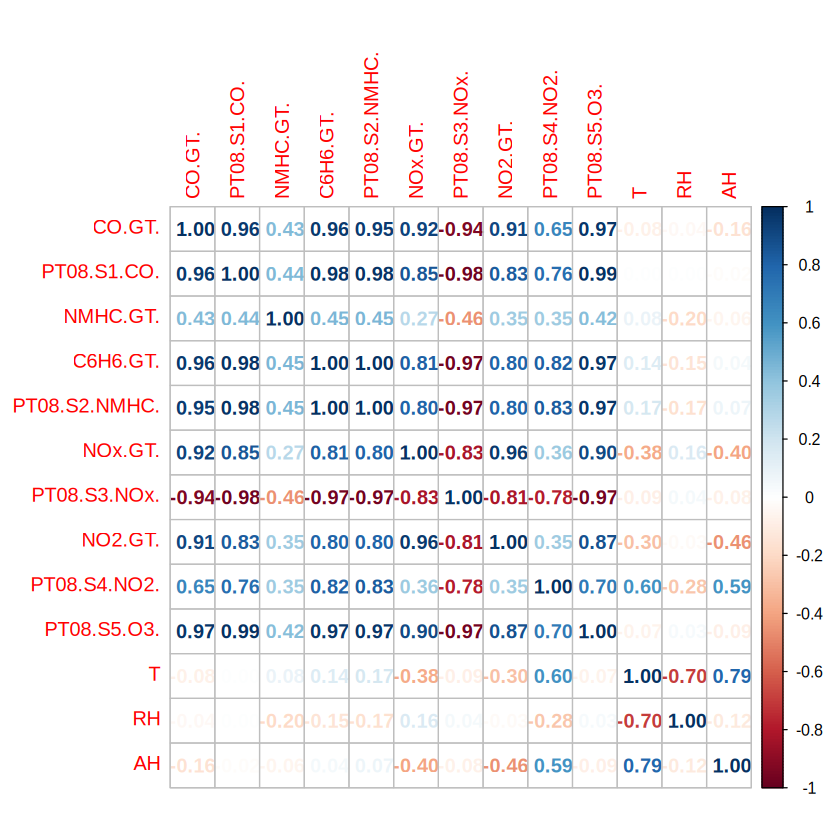

In [63]:
library(corrplot)
corrplot(round(cor(cor_matrix), 2), method="number")

In [64]:
threshold <- 0.7
high_cor_pairs <- list()

for(i in 1:(nrow(cor_matrix)-1)) {
  for(j in (i+1):ncol(cor_matrix)) {
    if(abs(cor_matrix[i, j]) > threshold) {
      high_cor_pairs <- rbind(high_cor_pairs, 
                              data.frame(Var1 = rownames(cor_matrix)[i], 
                                         Var2 = colnames(cor_matrix)[j], 
                                         value = cor_matrix[i, j]))
    }
  }
}

print(high_cor_pairs)

            Var1          Var2      value
1         CO.GT.   PT08.S1.CO.  0.7733943
2         CO.GT.      C6H6.GT.  0.8123923
3         CO.GT. PT08.S2.NMHC.  0.7955864
4         CO.GT.       NOx.GT.  0.7622972
5         CO.GT.   PT08.S5.O3.  0.7590266
6    PT08.S1.CO.      C6H6.GT.  0.8838209
7    PT08.S1.CO. PT08.S2.NMHC.  0.8929724
8    PT08.S1.CO.  PT08.S3.NOx. -0.7719181
9    PT08.S1.CO.   PT08.S5.O3.  0.8993259
10      C6H6.GT. PT08.S2.NMHC.  0.9819620
11      C6H6.GT.  PT08.S3.NOx. -0.7357112
12      C6H6.GT.  PT08.S4.NO2.  0.7657168
13      C6H6.GT.   PT08.S5.O3.  0.8657266
14 PT08.S2.NMHC.  PT08.S3.NOx. -0.7966873
15 PT08.S2.NMHC.  PT08.S4.NO2.  0.7772348
16 PT08.S2.NMHC.   PT08.S5.O3.  0.8805903
17       NOx.GT.       NO2.GT.  0.7631329
18  PT08.S3.NOx.   PT08.S5.O3. -0.7965536


Nhận xét:
- Trong dữ liệu, các biến có sự tương quan mạnh với nhau.
- Ta dễ dàng thấy được, đa số cặp tương quan đều có chỉ số cao hơn 0.7
- Điều này giúp chúng ta định hướng được nên sử dụng các mô hình có khả năng xử lý hiện tượng đa cộng tuyến cao trong dữ liệu.

In [65]:
threshold <- 0

neg_cor_pairs <- list()

for(i in 1:(nrow(cor_matrix)-1)) {
  for(j in (i+1):ncol(cor_matrix)) {
    if(cor_matrix[i, j] < threshold) {
      neg_cor_pairs <- rbind(neg_cor_pairs, 
                             data.frame(Var1 = rownames(cor_matrix)[i], 
                                        Var2 = colnames(cor_matrix)[j], 
                                        value = cor_matrix[i, j]))
    }
  }
}

print(neg_cor_pairs)

            Var1         Var2       value
1         CO.GT. PT08.S3.NOx. -0.61387028
2    PT08.S1.CO. PT08.S3.NOx. -0.77191812
3       NMHC.GT. PT08.S3.NOx. -0.26198519
4       NMHC.GT.           RH -0.05279411
5       C6H6.GT. PT08.S3.NOx. -0.73571121
6       C6H6.GT.           RH -0.06164347
7  PT08.S2.NMHC. PT08.S3.NOx. -0.79668731
8  PT08.S2.NMHC.           RH -0.09035172
9        NOx.GT. PT08.S3.NOx. -0.56325927
10       NOx.GT.            T -0.23565652
11       NOx.GT.           AH -0.12683093
12  PT08.S3.NOx.      NO2.GT. -0.56953458
13  PT08.S3.NOx. PT08.S4.NO2. -0.53846012
14  PT08.S3.NOx.  PT08.S5.O3. -0.79655364
15  PT08.S3.NOx.            T -0.14513301
16  PT08.S3.NOx.           RH -0.05672984
17  PT08.S3.NOx.           AH -0.23202063
18       NO2.GT.            T -0.16531710
19       NO2.GT.           RH -0.08064472
20       NO2.GT.           AH -0.29119971
21  PT08.S4.NO2.           RH -0.03218809
22   PT08.S5.O3.            T -0.02719336
23             T           RH -0.5

Nhận xét:
- Chúng ta cũng rút ra kết luận tương tự.

## Khảo sát ngoại lai

In [66]:
# Identify outliers using the IQR method
Q1 <- quantile(air_quality$'C6H6(GT)', 0.25)
Q3 <- quantile(air_quality$'C6H6(GT)', 0.75)
IQR <- Q3 - Q1
lower_bound <- Q1 - 1.5 * IQR
upper_bound <- Q3 + 1.5 * IQR
outliers <- which(air_quality$'C6H6(GT)' < lower_bound | air_quality$'C6H6(GT)' > upper_bound)

print(length(outliers))

lower_bound <- Q1 - 3 * IQR
upper_bound <- Q3 + 3 * IQR
extreme_outliers <- which(air_quality$'C6H6(GT)' < lower_bound | air_quality$'C6H6(GT)' > upper_bound)
print(length(extreme_outliers))

[1] 0
[1] 0


In [67]:
summary(air_quality)

     CO.GT.        PT08.S1.CO.        NMHC.GT.         C6H6.GT.     
 Min.   : 0.100   Min.   : 647.2   Min.   :   7.0   Min.   : 0.149  
 1st Qu.: 1.200   1st Qu.: 941.2   1st Qu.: 218.8   1st Qu.: 4.591  
 Median : 2.153   Median :1074.5   Median : 218.8   Median : 8.593  
 Mean   : 2.153   Mean   :1099.7   Mean   : 218.8   Mean   :10.083  
 3rd Qu.: 2.600   3rd Qu.:1221.2   3rd Qu.: 218.8   3rd Qu.:13.636  
 Max.   :11.900   Max.   :2039.8   Max.   :1189.0   Max.   :63.741  
 PT08.S2.NMHC.       NOx.GT.        PT08.S3.NOx.       NO2.GT.     
 Min.   : 383.2   Min.   :   2.0   Min.   : 322.0   Min.   :  2.0  
 1st Qu.: 742.5   1st Qu.: 112.0   1st Qu.: 665.5   1st Qu.: 85.9  
 Median : 923.2   Median : 229.0   Median : 817.5   Median :113.1  
 Mean   : 939.0   Mean   : 246.9   Mean   : 835.4   Mean   :113.1  
 3rd Qu.:1104.8   3rd Qu.: 284.2   3rd Qu.: 960.2   3rd Qu.:133.0  
 Max.   :2214.0   Max.   :1479.0   Max.   :2682.8   Max.   :339.7  
  PT08.S4.NO2.   PT08.S5.O3.           T 

## Phân chia tập dữ liệu

In [68]:
tmp <- bc_transform(air_quality[, -c(14, 15)])
air_quality <- tmp

[1] "CO.GT."
[1] "Optimal lambda: 0.7"
[1] "PT08.S1.CO."
[1] "Optimal lambda: 0.7"
[1] "NMHC.GT."
[1] "Optimal lambda: 0.7"
[1] "C6H6.GT."
[1] "Optimal lambda: 0.7"
[1] "PT08.S2.NMHC."
[1] "Optimal lambda: 0.7"
[1] "NOx.GT."
[1] "Optimal lambda: 0.7"
[1] "PT08.S3.NOx."
[1] "Optimal lambda: 0.7"
[1] "NO2.GT."
[1] "Optimal lambda: 0.7"
[1] "PT08.S4.NO2."
[1] "Optimal lambda: 0.7"
[1] "PT08.S5.O3."
[1] "Optimal lambda: 0.7"
[1] "T"
[1] "Optimal lambda: 0.7"
[1] "RH"
[1] "Optimal lambda: 0.7"
[1] "AH"
[1] "Optimal lambda: 0.7"


In [69]:
split_ratio <- 0.7
split_index <- floor(nrow(air_quality) * split_ratio)

train = air_quality[1:split_index,]
test = air_quality[(split_index + 1):nrow(air_quality),]

In [70]:
# số chiều tập train
dim(train)
rownames(train) <- 1:nrow(train)

[1] 6549   13

In [71]:
# số chiều tập test
dim(test)
rownames(test) <- 1:nrow(test)

[1] 2808   13

In [72]:
# xem một số quan trắc của tập train
str(train)

'data.frame':	6549 obs. of  13 variables:
 $ CO.GT.       : num  1.36 0.892 1.052 1.052 0.557 ...
 $ PT08.S1.CO.  : num  222 214 226 223 211 ...
 $ NMHC.GT.     : num  46.2 37.4 31.4 29.3 21 ...
 $ C6H6.GT.     : num  6.65 5.43 5.22 5.34 3.88 ...
 $ PT08.S2.NMHC.: num  184 173 171 172 157 ...
 $ NOx.GT.      : num  49.7 35.2 41.9 51 41.9 ...
 $ PT08.S3.NOx. : num  185 200 196 190 203 ...
 $ NO2.GT.      : num  37.7 32.4 37.9 39.8 38.4 ...
 $ PT08.S4.NO2. : num  258 244 243 247 236 ...
 $ PT08.S5.O3.  : num  211 175 188 203 192 ...
 $ T            : num  8.74 8.61 7.99 7.59 7.66 ...
 $ RH           : num  20.3 19.9 21.9 23.7 23.5 ...
 $ AH           : num  -0.252 -0.287 -0.26 -0.221 -0.219 ...


## Mô hình hóa

### Mô hình đầy đủ

In [73]:
full.lm <- lm(`C6H6.GT.` ~ ., data = train)
print(summary(full.lm))


Call:
lm(formula = C6H6.GT. ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3855 -0.1963 -0.0553  0.1558  3.9380 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -1.423e+01  1.795e-01 -79.253  < 2e-16 ***
CO.GT.         4.689e-02  8.772e-03   5.346 9.32e-08 ***
PT08.S1.CO.   -1.518e-03  4.185e-04  -3.626 0.000290 ***
NMHC.GT.       1.064e-03  2.993e-04   3.556 0.000379 ***
PT08.S2.NMHC.  1.083e-01  5.774e-04 187.655  < 2e-16 ***
NOx.GT.        8.187e-03  2.838e-04  28.845  < 2e-16 ***
PT08.S3.NOx.   1.125e-02  3.328e-04  33.819  < 2e-16 ***
NO2.GT.       -1.848e-02  7.815e-04 -23.649  < 2e-16 ***
PT08.S4.NO2.   5.558e-03  3.845e-04  14.453  < 2e-16 ***
PT08.S5.O3.    1.357e-03  2.494e-04   5.443 5.44e-08 ***
T             -8.847e-02  7.468e-03 -11.846  < 2e-16 ***
RH            -4.064e-02  3.545e-03 -11.464  < 2e-16 ***
AH             5.389e-01  4.896e-02  11.008  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘

### Lựa chọn mô hình

In [74]:
# Mô hình chặn dưới
model.lb <- lm(`C6H6.GT.` ~ 1, data = train) 

In [75]:
# Mô hình chặn trên
model.up <- full.lm

In [76]:
step(full.lm, scope = list(lower = model.lb, upper = model.up), direction = "both", trace = FALSE)


Call:
lm(formula = C6H6.GT. ~ CO.GT. + PT08.S1.CO. + NMHC.GT. + PT08.S2.NMHC. + 
    NOx.GT. + PT08.S3.NOx. + NO2.GT. + PT08.S4.NO2. + PT08.S5.O3. + 
    T + RH + AH, data = train)

Coefficients:
  (Intercept)         CO.GT.    PT08.S1.CO.       NMHC.GT.  PT08.S2.NMHC.  
   -14.229708       0.046891      -0.001518       0.001064       0.108347  
      NOx.GT.   PT08.S3.NOx.        NO2.GT.   PT08.S4.NO2.    PT08.S5.O3.  
     0.008187       0.011255      -0.018483       0.005558       0.001357  
            T             RH             AH  
    -0.088472      -0.040642       0.538945  


In [77]:
air_models<- regsubsets(C6H6.GT. ~ CO.GT. + PT08.S1.CO. + NMHC.GT. + PT08.S2.NMHC. + 
    NOx.GT. + PT08.S3.NOx. + NO2.GT. + PT08.S4.NO2. + PT08.S5.O3. + 
    T + RH + AH, data = train)
summary.air<-summary(air_models)

In [78]:
# Lựa chọn mô hình tốt nhất từ reg subsets 
summary.air$which

(Intercept) CO.GT. PT08.S1.CO. NMHC.GT. PT08.S2.NMHC. NOx.GT. PT08.S3.NOx.
1 TRUE        FALSE  FALSE       FALSE    TRUE          FALSE   FALSE       
2 TRUE        FALSE  FALSE       FALSE    TRUE          FALSE    TRUE       
3 TRUE        FALSE  FALSE       FALSE    TRUE          FALSE    TRUE       
4 TRUE        FALSE  FALSE       FALSE    TRUE           TRUE    TRUE       
5 TRUE        FALSE  FALSE       FALSE    TRUE           TRUE    TRUE       
6 TRUE        FALSE  FALSE       FALSE    TRUE           TRUE    TRUE       
7 TRUE         TRUE  FALSE       FALSE    TRUE           TRUE    TRUE       
8 TRUE        FALSE  FALSE       FALSE    TRUE           TRUE    TRUE       
  NO2.GT. PT08.S4.NO2. PT08.S5.O3. T     RH    AH   
1 FALSE   FALSE        FALSE       FALSE FALSE FALSE
2 FALSE   FALSE        FALSE       FALSE FALSE FALSE
3 FALSE   FALSE        FALSE       FALSE  TRUE FALSE
4  TRUE   FALSE        FALSE       FALSE FALSE FALSE
5  TRUE    TRUE        FALSE       FALSE FALSE FALSE
6  TRUE    TRUE         TRUE       FALSE FALSE FALSE
7  TRUE    TRUE         TRUE       FALSE FALSE FALSE
8  TRUE    TRUE        FALSE        TRUE  TRUE  TRUE

Tiêu chí chọn mô hình tốt nhất 1: mô hình với $R^2$ lớn (tương ứng với MSE nhỏ)

In [79]:
summary.air$rsq

[1] 0.9881629 0.9896953 0.9905913 0.9914152 0.9920542 0.9921076 0.9921423
[8] 0.9922445

Tiêu chí chọn mô hình tốt nhất 2: mô hình với $R^2$ hiệu chỉnh lớn

In [80]:
# model with largest adjusted R^2 
summary.air$adjr2

[1] 0.9881611 0.9896922 0.9905870 0.9914100 0.9920481 0.9921003 0.9921339
[8] 0.9922350

Tiêu chí chọn mô hình tốt nhất 3: mô hình với Mallow's Cp nhỏ

In [81]:
# model with smallest Mallow's Cp
summary.air$cp

[1] 3546.95910 2242.41405 1480.54675  780.11063  237.31443  193.83177  166.17854
[8]   81.09075

Chọn mô hình tốt nhất dựa trên BIC

In [82]:
# Tiêu chí chọn mô hình tốt nhất 4: mô hình với BIC nhỏ
summary.air$bic

[1] -29037.15 -29936.36 -30523.28 -31114.66 -31612.44 -31647.77 -31667.91
[8] -31744.81

In [83]:
best_model_index <- which.min(summary.air$bic)
best_model <- summary.air$which[best_model_index, ]
print(best_model)
best_vars <- names(best_model[best_model])
best_vars <- best_vars[best_vars != "(Intercept)"]
print(best_vars)

  (Intercept)        CO.GT.   PT08.S1.CO.      NMHC.GT. PT08.S2.NMHC. 
         TRUE         FALSE         FALSE         FALSE          TRUE 
      NOx.GT.  PT08.S3.NOx.       NO2.GT.  PT08.S4.NO2.   PT08.S5.O3. 
         TRUE          TRUE          TRUE          TRUE         FALSE 
            T            RH            AH 
         TRUE          TRUE          TRUE 
[1] "PT08.S2.NMHC." "NOx.GT."       "PT08.S3.NOx."  "NO2.GT."      
[5] "PT08.S4.NO2."  "T"             "RH"            "AH"           


In [84]:
# Xây dựng mô hình tốt nhất
formula_str <- paste("C6H6.GT. ~", paste(best_vars, collapse = " + "))
best_model_air <- lm(as.formula(formula_str), data=train)

In [85]:
# Tóm tắt mô hình
summary(best_model_air)


Call:
lm(formula = as.formula(formula_str), data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3449 -0.1997 -0.0546  0.1609  3.8753 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -1.434e+01  1.717e-01  -83.53   <2e-16 ***
PT08.S2.NMHC.  1.091e-01  5.156e-04  211.67   <2e-16 ***
NOx.GT.        8.707e-03  2.648e-04   32.88   <2e-16 ***
PT08.S3.NOx.   1.081e-02  3.248e-04   33.27   <2e-16 ***
NO2.GT.       -1.743e-02  7.717e-04  -22.59   <2e-16 ***
PT08.S4.NO2.   5.917e-03  3.628e-04   16.31   <2e-16 ***
T             -9.191e-02  7.381e-03  -12.45   <2e-16 ***
RH            -4.096e-02  3.558e-03  -11.51   <2e-16 ***
AH             5.359e-01  4.887e-02   10.97   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3136 on 6540 degrees of freedom
Multiple R-squared:  0.9922,	Adjusted R-squared:  0.9922 
F-statistic: 1.046e+05 on 8 and 6540 DF,  p-value: < 2.2e-16


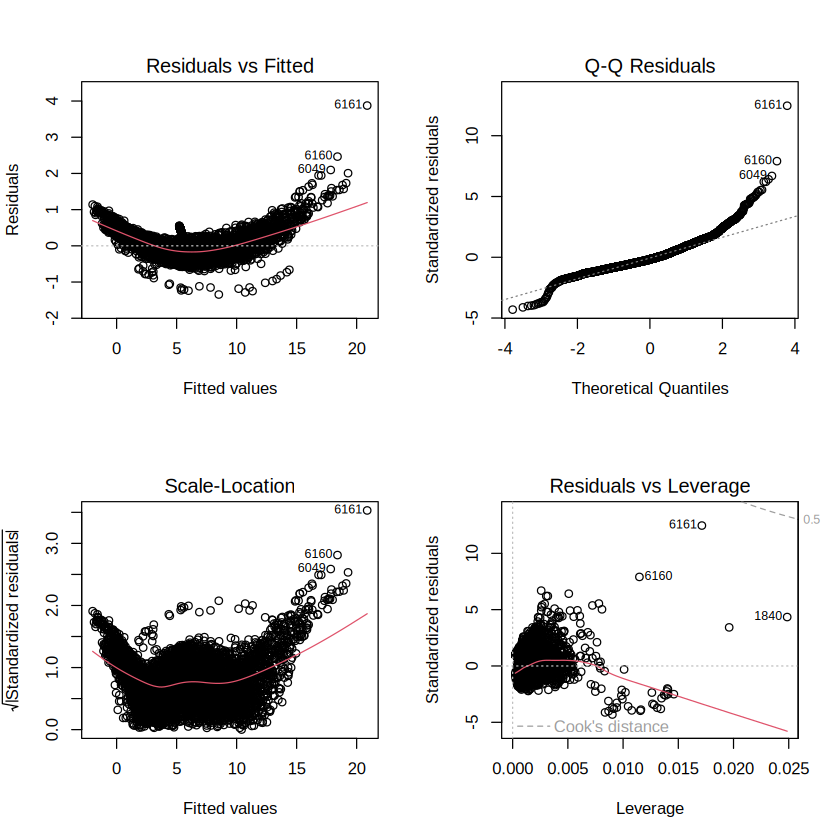

In [86]:
# Trực quan hóa
par(mfrow = c(2, 2))
plot(best_model_air)

#### Phân tích Residuals vs Fitted Plot

Biểu đồ **Residuals vs Fitted Plot** đưa ra dấu hiệu nếu có các mẫu phi tuyến tính. Để hồi quy tuyến tính chính xác, dữ liệu cần phải tuyến tính nên điều này sẽ kiểm tra xem điều kiện đó có được đáp ứng hay không.

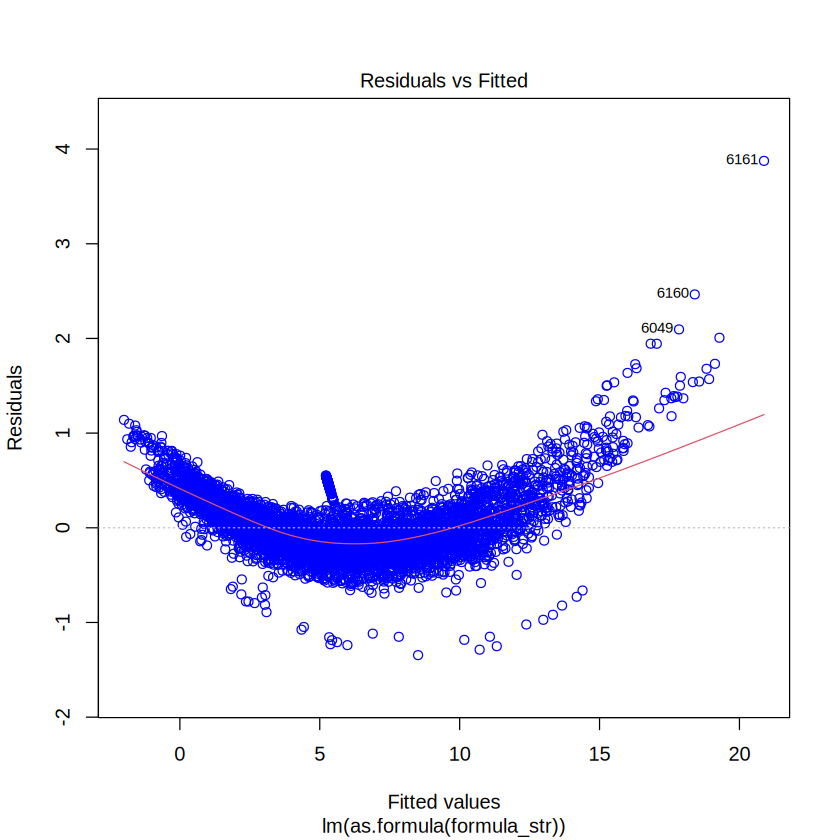

In [87]:
plot(best_model_air, which=1, col=c("blue")) # Residuals vs Fitted Plot

Dựa trên biểu đồ này, ta thấy đường cong màu đỏ có dáng chưa gần như một đường thẳng, và các phần tử trải dọc theo đường cong này một cách tương chưa đồng đều. Điều này chứng tỏ có quan hệ phi tuyến xuất hiện trong dữ liệu.

#### Phân tích Normal Q–Q (quantile-quantile) Plot

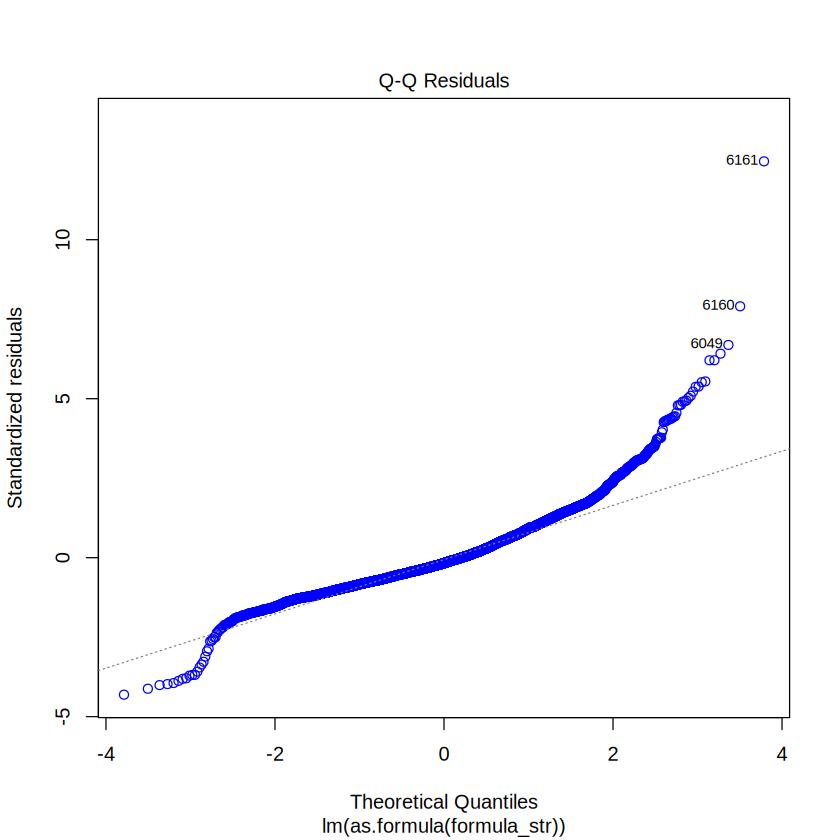

In [88]:
plot(best_model_air, which=2, col=c("blue")) # QQ Plot

Các giá trị thặng dư (residual) nên có phân phối chuẩn. Để kiểm tra điều này, chúng ta cần quan sát biểu đồ QQ Residuals plot, nếu các điểm được xếp thành một đường thẳng (hoặc gần như thẳng) thì chứng tỏ các giá trị thặng dư (residual) có phân phối chuẩn. Như hình vẽ kết quả ở trên, ta thấy rõ điều đó, residual có phân phối chuẩn.

Cẩn thận hơn, chúng ta thử dùng Shapiro–Wilk test để kiểm tra có đúng thật là các giá trị thặng dư có phân phối chuẩn hay không?
- H0: Biến thặng dư của mô hình phân phối chuẩn trong một số quần thể.
- H1: Biến thặng dư của mô hình không phân phối chuẩn trong một số quần thể.


	Shapiro-Wilk normality test

data:  model$residuals[3:5000]
W = 0.96092, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


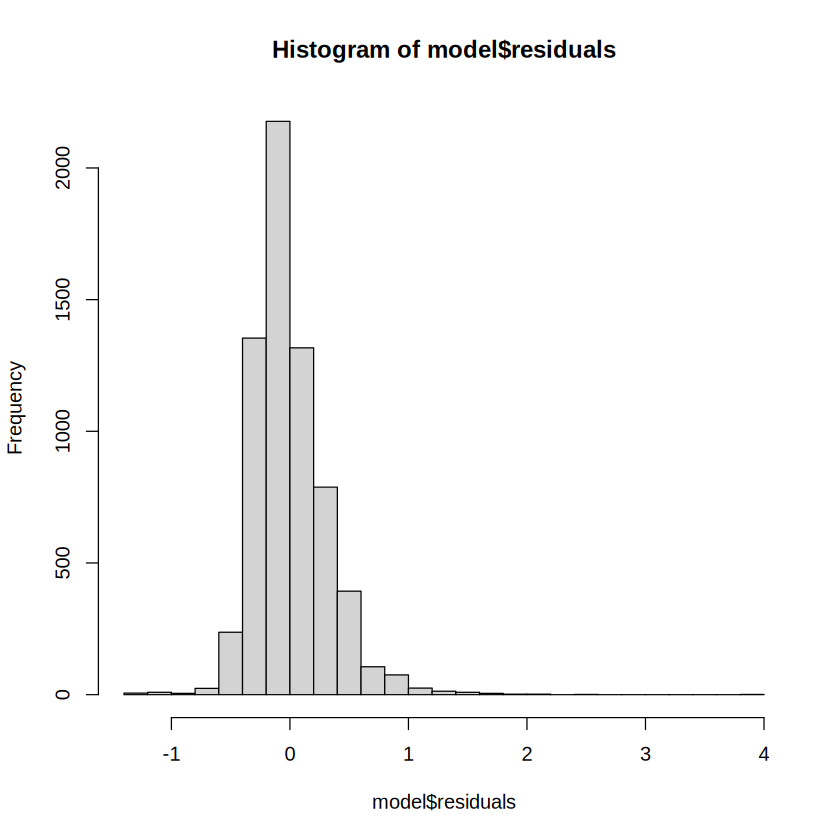

In [89]:
# Shapiro-Wilk normality test
# shapiro.test(residuals(best_model_air)[3:5000])
CheckNormal(best_model_air)

Kết quả cho thấy p-value bé hơn mức ý nghĩa alpha 0.05 nên ta có thể bác bỏ giả thhuyết H0, biến thặng dư của chúng ta không chuẩn trong một số quần thể. 

#### Phân tích Scale-Location

Biểu đồ scale-location kiểm định giả định hồi quy về phương sai bằng nhau (homoscedasticity), tức là giá trị thặng dư có phương sai bằng với đường hồi quy.

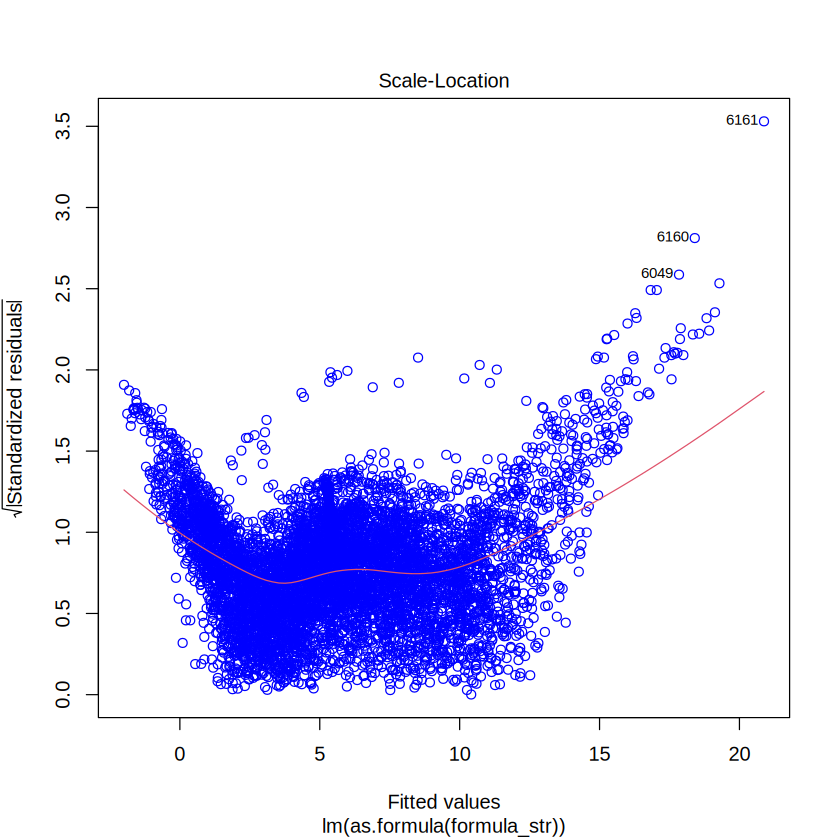

In [90]:
plot(best_model_air, which=3, col=c("blue")) # Scale-Location

Ta phát hiện:
- Đường màu đỏ gần bị lệch về phía dưới của biểu đồ. Nghĩa là, độ phân tán của giá trị thặng dư gần không bằng nhau ở tất cả các giá trị phù hợp.
- Các giá trị thặng dư được phân tán ngẫu nhiên xung quanh đường màu đỏ với độ biến thiên không bằng nhau ở tất cả các giá trị phù hợp.

Cẩn thận hơn, chúng ta sử dụng Breusch-Pagan test để kiểm tra có thật là như vậy không?
- H0: Các giá trị thặng dư là homoscedastic
- H1: Các giá trị thặng dư là heteroscedastic


	studentized Breusch-Pagan test

data:  model
BP = 1157, df = 8, p-value < 2.2e-16

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


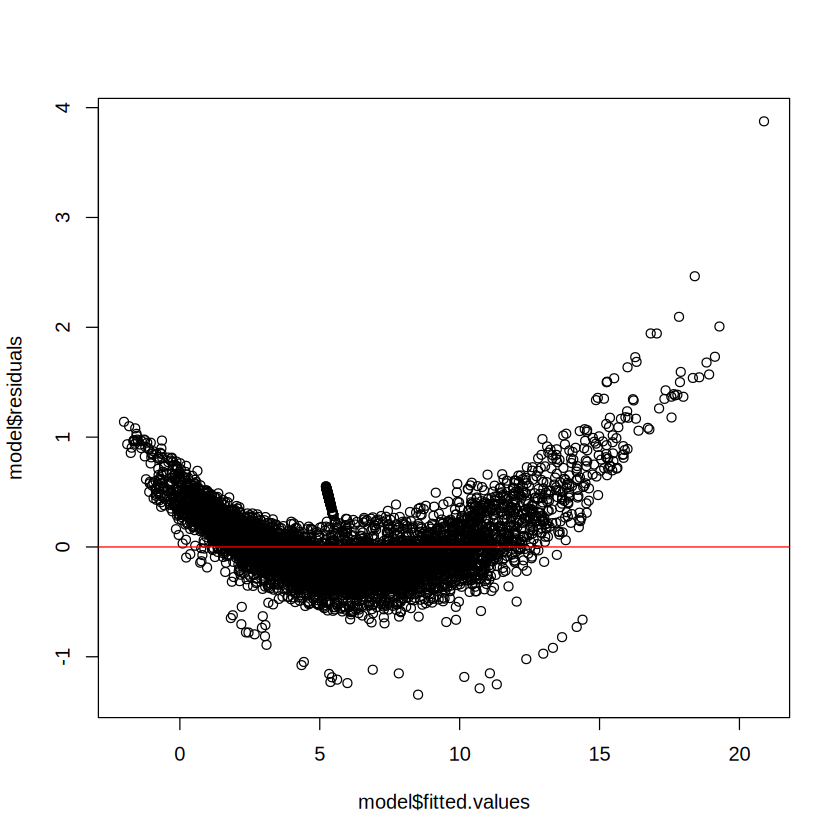

In [91]:
# Breusch-Pagan Test
# bptest(best_model_air)
CheckHomos(best_model_air)

Như vậy, ta thấy p-value nhỏ hơn múc ý nghĩa 0.05, ta đủ điều kiện bác bỏ H0. Vậy các giá trị thặng dư là heteroscedastic

#### Phân tích Residuals vs Leverage

Biểu đồ này có thể được sử dụng để tìm các trường hợp có ảnh hưởng trong tập dữ liệu. Một trường hợp có ảnh hưởng là một trường hợp mà nếu bị loại bỏ sẽ ảnh hưởng đến mô hình nên việc đưa vào hoặc loại trừ nó cần được xem xét.

Một trường hợp có ảnh hưởng có thể là một trường hợp ngoại lệ hoặc không và mục đích của biểu đồ này là xác định các trường hợp có ảnh hưởng lớn đến mô hình. Các ngoại lệ sẽ có xu hướng có giá trị cực cao hoặc cực thấp và do đó ảnh hưởng đến mô hình.

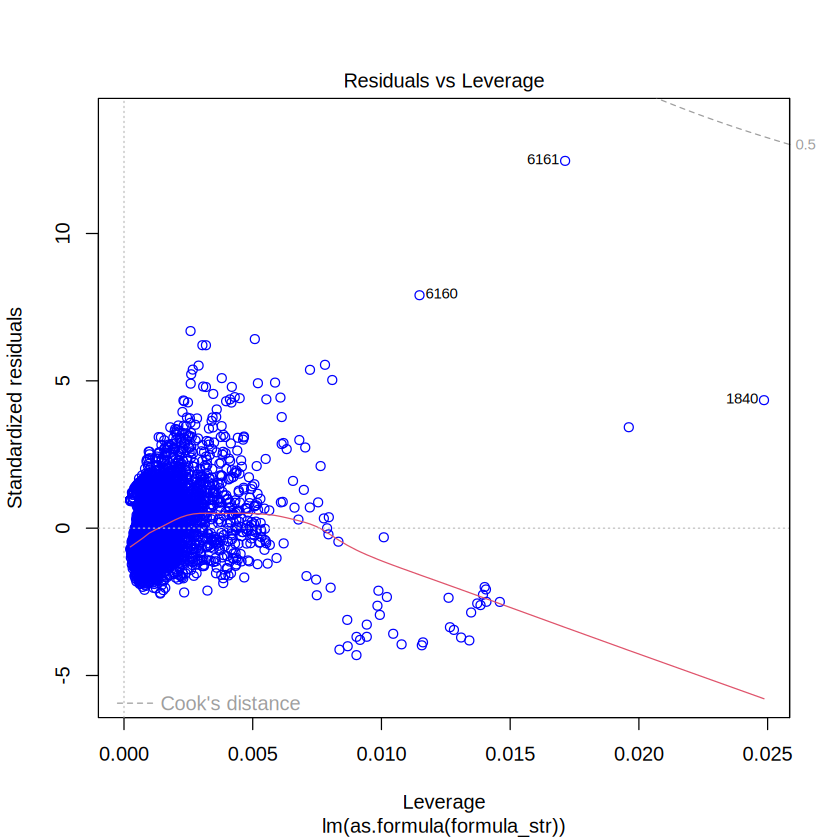

In [92]:
plot(best_model_air, which=5, col=c("blue")) # Residuals vs Leverage

Ta nhận thấy có một số giá trị ngoại lai ở cách xa đường thằng giữa. Ta có thể xem rõ hơn thông qua histogram của Cook's Distance

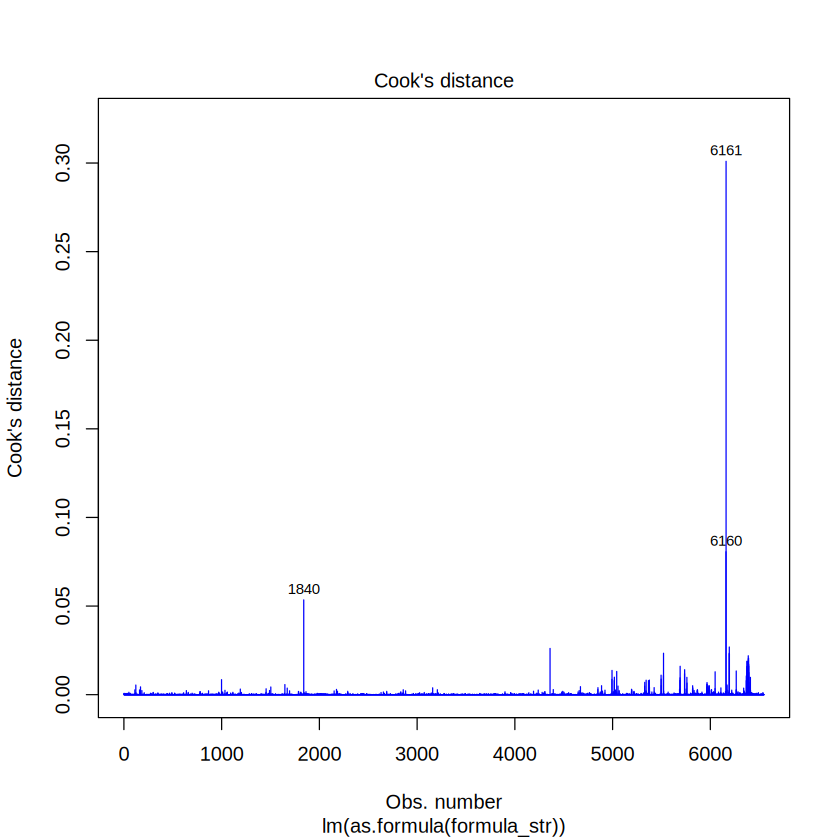

In [93]:
plot(best_model_air, which=4, col=c("blue"))

### Loại bỏ các điểm ảnh hưởng dựa trên Cook Distance

In [94]:
# Xây dựng ngưỡng cho Cook Distance
threshold <- 4 / nrow(train)
threshold

[1] 0.0006107803


Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56389 -0.15826 -0.04263  0.13520  0.80613 

Coefficients:
                Estimate Std. Error  t value Pr(>|t|)    
(Intercept)   -1.481e+01  1.445e-01 -102.490  < 2e-16 ***
PT08.S2.NMHC.  1.086e-01  4.857e-04  223.638  < 2e-16 ***
NOx.GT.        6.541e-03  2.133e-04   30.671  < 2e-16 ***
PT08.S3.NOx.   9.981e-03  3.296e-04   30.287  < 2e-16 ***
NO2.GT.       -1.143e-02  5.982e-04  -19.113  < 2e-16 ***
PT08.S4.NO2.   3.640e-03  3.127e-04   11.639  < 2e-16 ***
T             -3.867e-02  5.673e-03   -6.816 1.02e-11 ***
RH            -1.452e-02  2.750e-03   -5.278 1.35e-07 ***
AH             3.109e-01  3.802e-02    8.178 3.49e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2266 on 6160 degrees of freedom
Multiple R-squared:  0.9947,	Adjusted R-squared:  0.9947 
F-statistic: 1.449e+05 on 


	Shapiro-Wilk normality test

data:  model$residuals[3:5000]
W = 0.96912, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


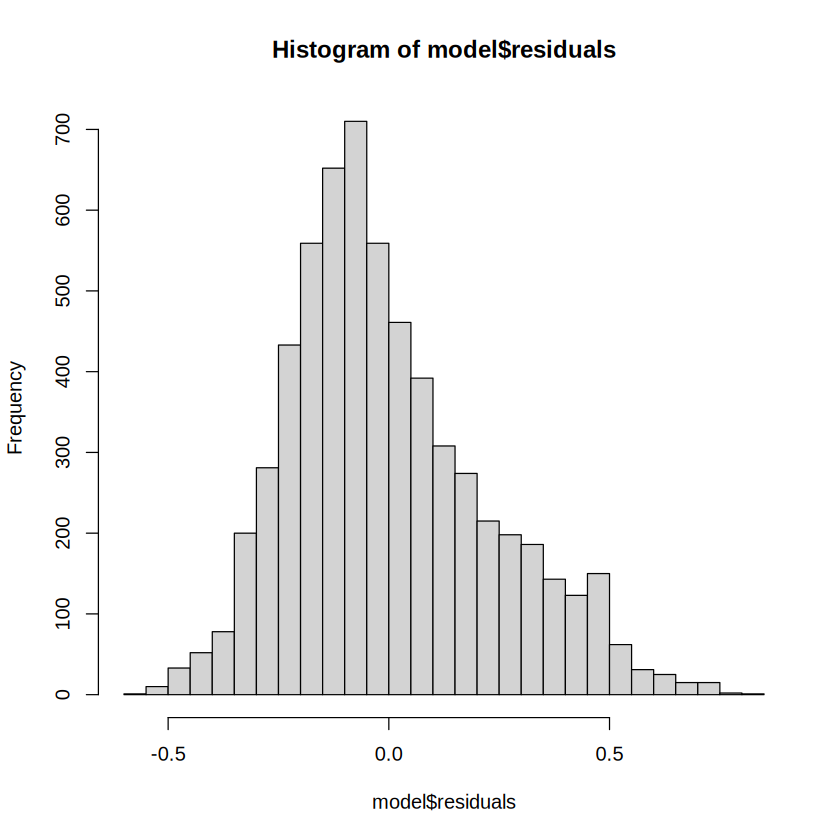


	studentized Breusch-Pagan test

data:  model
BP = 801.16, df = 8, p-value < 2.2e-16

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


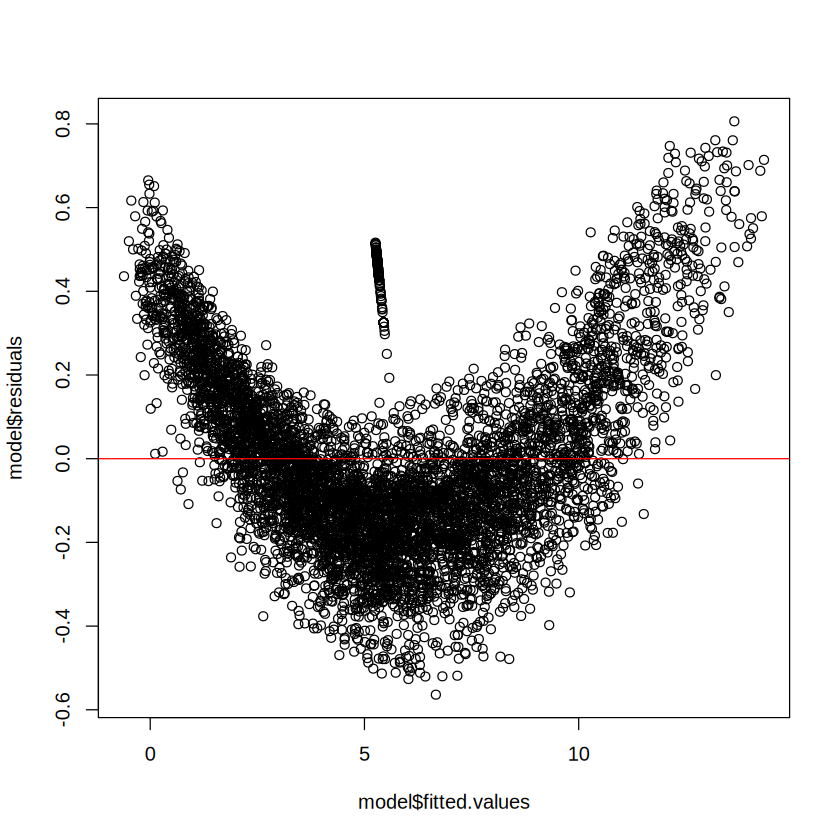

In [95]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_air)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_air.2 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_air.2)

# Shapiro-Wilk normality test
CheckNormal(best_model_air.2)

# Breusch-Pagan Test
CheckHomos(best_model_air.2)



Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3360 -0.1997 -0.0562  0.1612  3.8857 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -1.434e+01  1.766e-01  -81.18   <2e-16 ***
PT08.S2.NMHC.  1.089e-01  5.315e-04  204.97   <2e-16 ***
NOx.GT.        8.682e-03  2.730e-04   31.80   <2e-16 ***
PT08.S3.NOx.   1.064e-02  3.348e-04   31.79   <2e-16 ***
NO2.GT.       -1.733e-02  8.020e-04  -21.61   <2e-16 ***
PT08.S4.NO2.   5.936e-03  3.744e-04   15.86   <2e-16 ***
T             -8.964e-02  7.607e-03  -11.78   <2e-16 ***
RH            -3.969e-02  3.665e-03  -10.83   <2e-16 ***
AH             5.084e-01  5.031e-02   10.10   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3133 on 6095 degrees of freedom
Multiple R-squared:  0.9922,	Adjusted R-squared:  0.9922 
F-statistic: 9.736e+04 on 8 and 6095 DF,  p-va


	Shapiro-Wilk normality test

data:  model$residuals[3:5000]
W = 0.94602, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


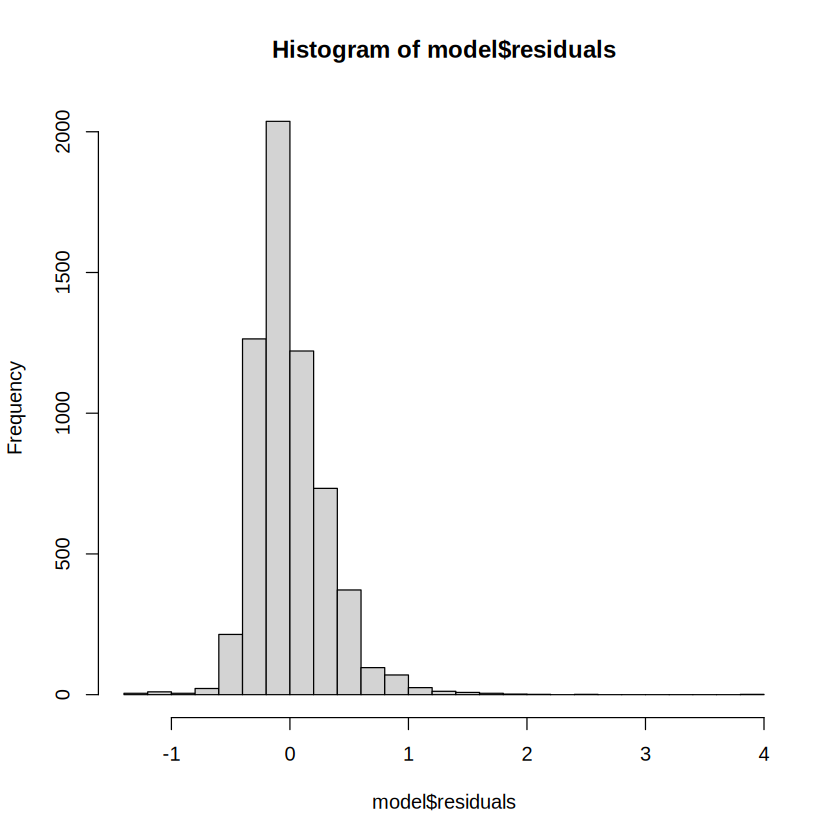


	studentized Breusch-Pagan test

data:  model
BP = 1088.7, df = 8, p-value < 2.2e-16

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


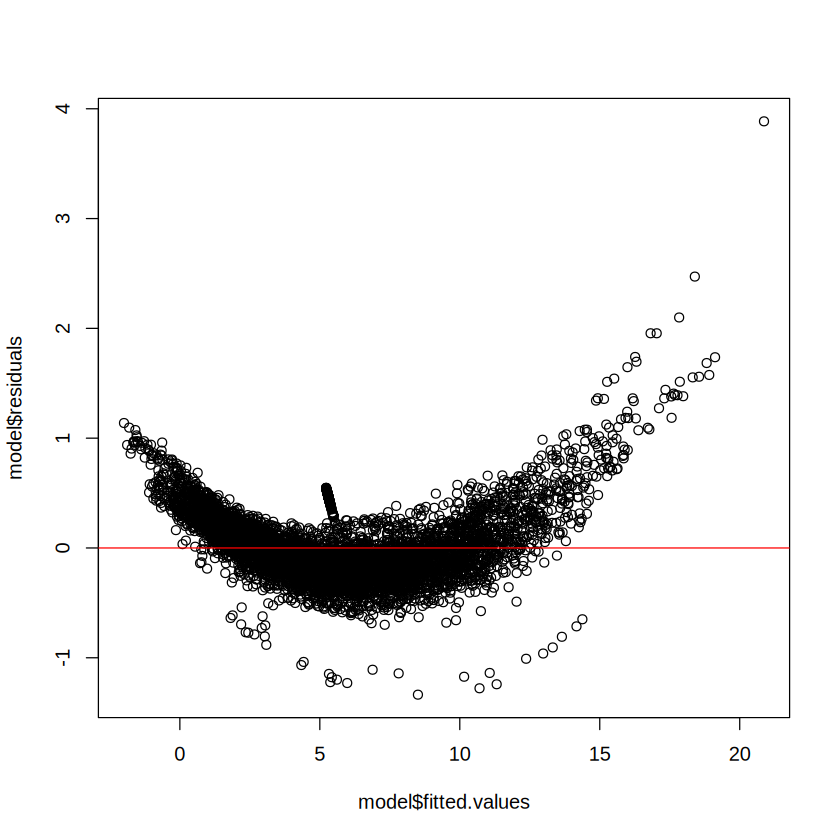

In [96]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_air.2)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_air.3 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_air.3)

# Shapiro-Wilk normality test
CheckNormal(best_model_air.3)

# Breusch-Pagan Test
CheckHomos(best_model_air.3)



Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3138 -0.2009 -0.0543  0.1611  3.9055 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -1.430e+01  1.748e-01  -81.82   <2e-16 ***
PT08.S2.NMHC.  1.087e-01  5.285e-04  205.62   <2e-16 ***
NOx.GT.        8.774e-03  2.735e-04   32.08   <2e-16 ***
PT08.S3.NOx.   1.044e-02  3.328e-04   31.36   <2e-16 ***
NO2.GT.       -1.730e-02  7.979e-04  -21.68   <2e-16 ***
PT08.S4.NO2.   6.157e-03  3.736e-04   16.48   <2e-16 ***
T             -8.998e-02  7.540e-03  -11.94   <2e-16 ***
RH            -4.046e-02  3.646e-03  -11.10   <2e-16 ***
AH             5.151e-01  5.005e-02   10.29   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3137 on 6157 degrees of freedom
Multiple R-squared:  0.9922,	Adjusted R-squared:  0.9922 
F-statistic: 9.837e+04 on 8 and 6157 DF,  p-va


	Shapiro-Wilk normality test

data:  model$residuals[3:5000]
W = 0.95024, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


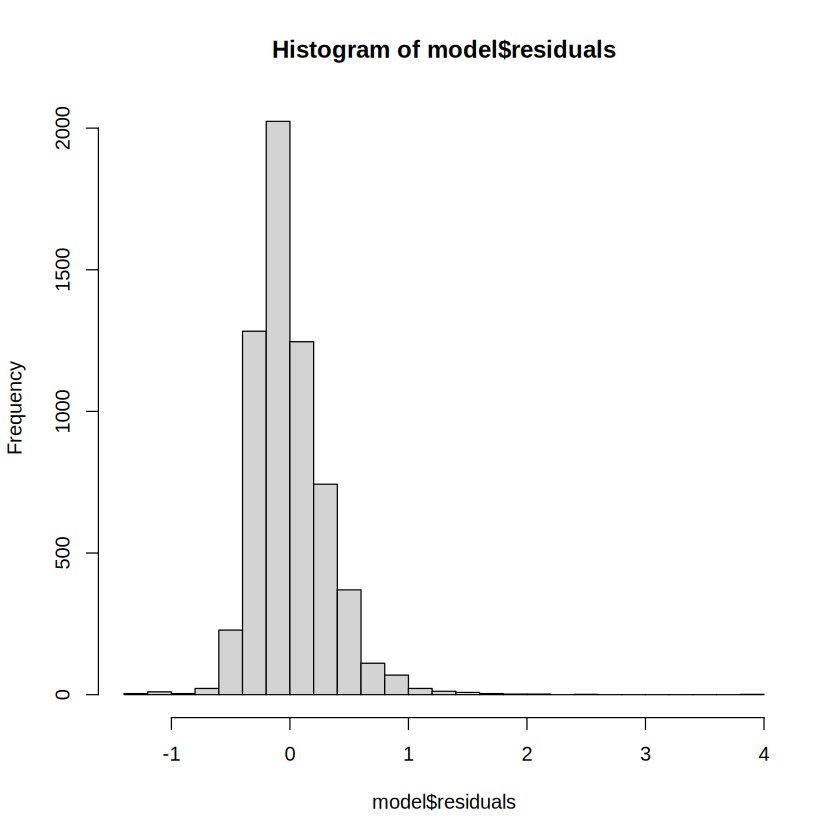


	studentized Breusch-Pagan test

data:  model
BP = 1042, df = 8, p-value < 2.2e-16

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


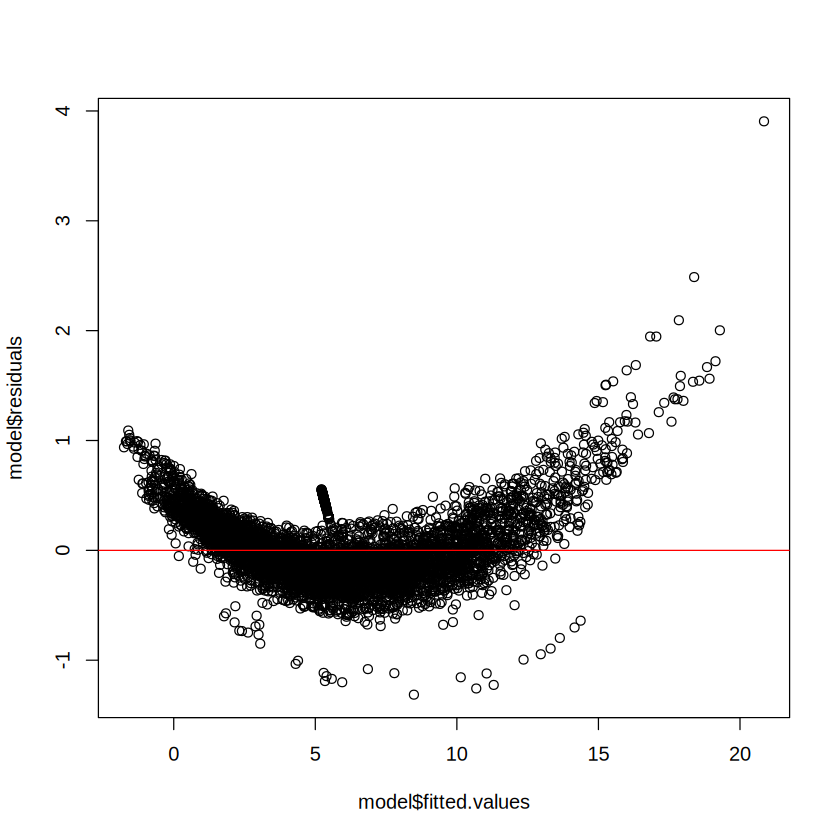

In [97]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_air.3)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_air.4 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_air.4)

# Shapiro-Wilk normality test
CheckNormal(best_model_air.4)

# Breusch-Pagan Test
CheckHomos(best_model_air.4)



Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3138 -0.2009 -0.0543  0.1611  3.9055 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -1.430e+01  1.748e-01  -81.82   <2e-16 ***
PT08.S2.NMHC.  1.087e-01  5.285e-04  205.62   <2e-16 ***
NOx.GT.        8.774e-03  2.735e-04   32.08   <2e-16 ***
PT08.S3.NOx.   1.044e-02  3.328e-04   31.36   <2e-16 ***
NO2.GT.       -1.730e-02  7.979e-04  -21.68   <2e-16 ***
PT08.S4.NO2.   6.157e-03  3.736e-04   16.48   <2e-16 ***
T             -8.998e-02  7.540e-03  -11.94   <2e-16 ***
RH            -4.046e-02  3.646e-03  -11.10   <2e-16 ***
AH             5.151e-01  5.005e-02   10.29   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3137 on 6157 degrees of freedom
Multiple R-squared:  0.9922,	Adjusted R-squared:  0.9922 
F-statistic: 9.837e+04 on 8 and 6157 DF,  p-va


	Shapiro-Wilk normality test

data:  model$residuals[3:5000]
W = 0.95024, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


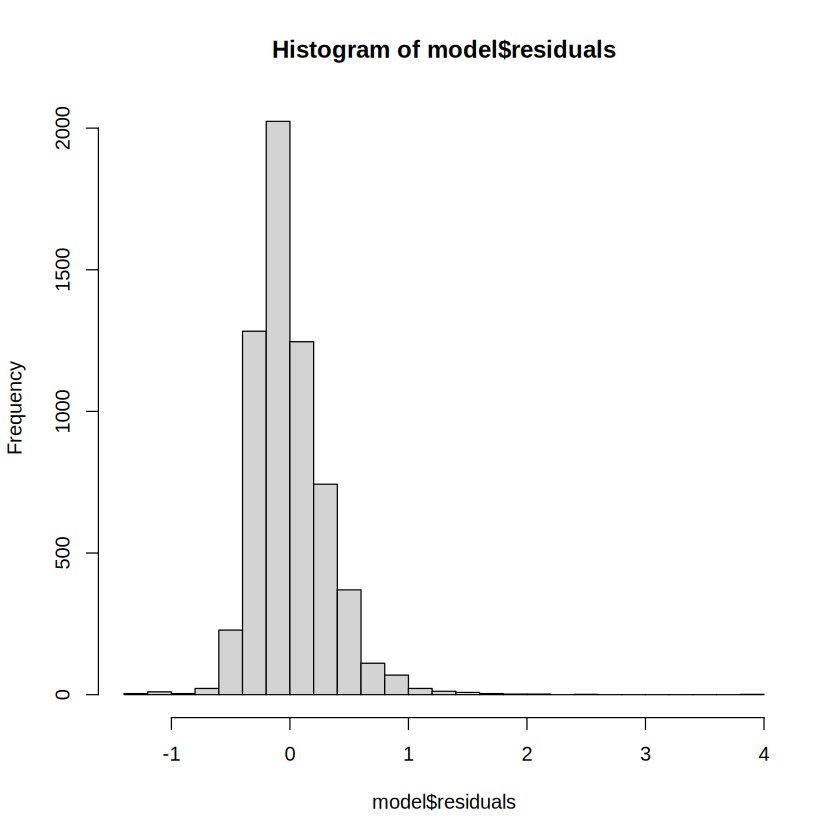


	studentized Breusch-Pagan test

data:  model
BP = 1042, df = 8, p-value < 2.2e-16

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


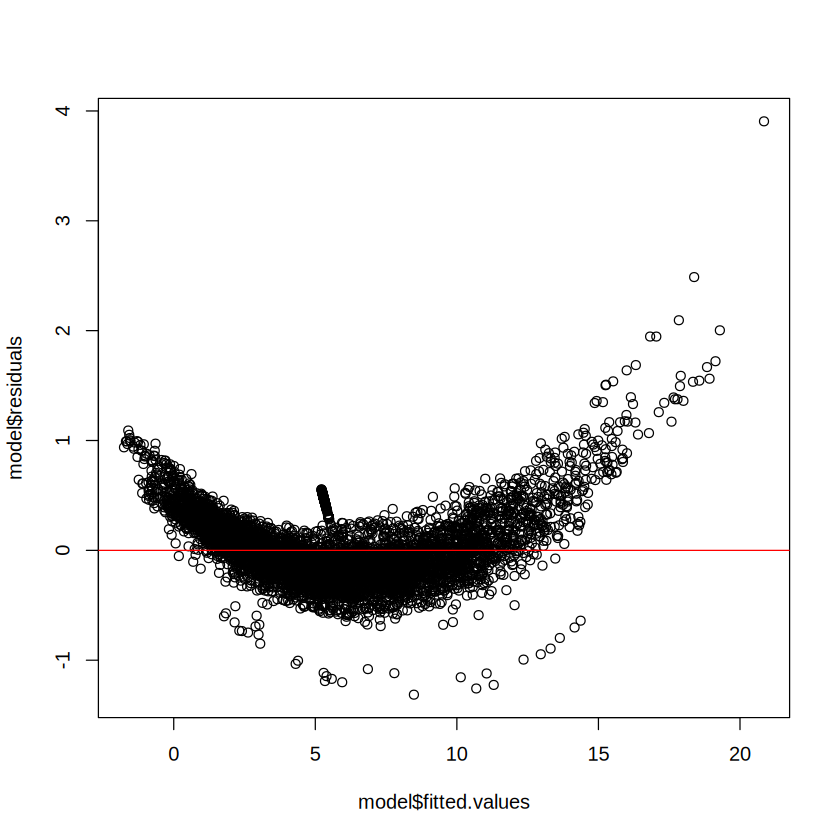

In [98]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_air.4)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_air.5 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_air.4)

# Shapiro-Wilk normality test
CheckNormal(best_model_air.4)

# Breusch-Pagan Test
CheckHomos(best_model_air.4)


Bằng cách loại bỏ các điểm ảnh hưởng dựa trên Cook Distance, ta thử nghiệm việc loại bỏ các giá trị này để xem liệu mô hình có thỏa mãn các điều kiện của mô hình hồi quy tuyến tính hay không. Tuy nhiên, các lần thử nghiệm cho đều cho thấy phân phối của biến thặng dư không chuẩn. Do đó, các phân tích về sau có thể không đảm bảo được tính tin cậy.

#### Dự đoán và đánh giá kết quả

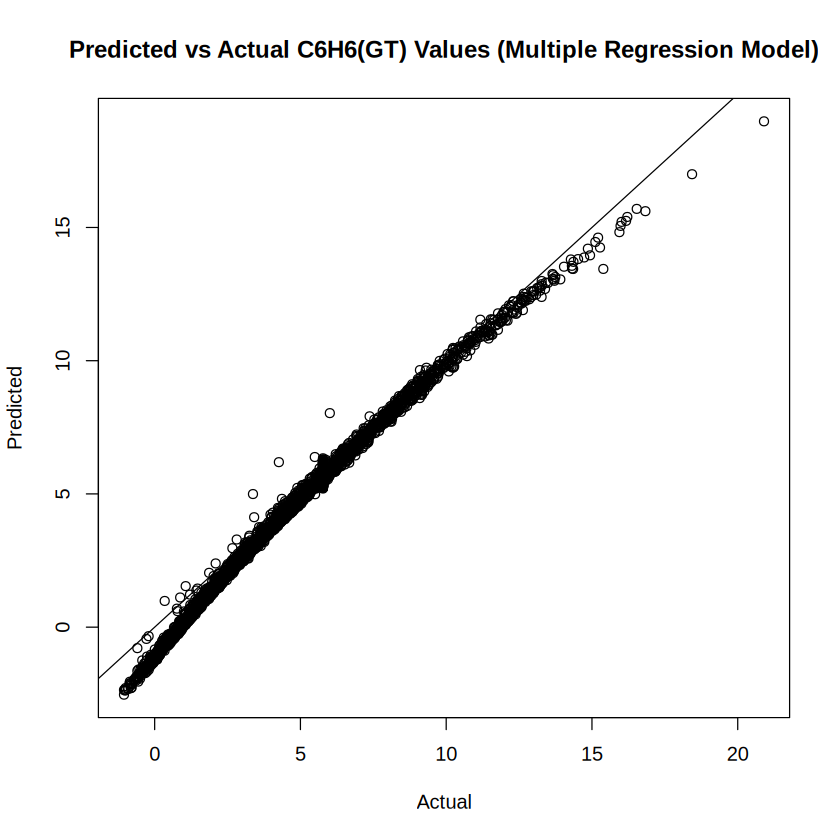

In [99]:
# Predict using the model and evaluate on the test set
predictions <- predict(best_model_air.5, test)

# Compare predictions with actual values
plot(test$`C6H6.GT.`, predictions, xlab = "Actual", ylab = "Predicted", main = "Predicted vs Actual C6H6(GT) Values (Multiple Regression Model)")  # Plot actual vs predicted values
abline(0, 1)  # Add a diagonal line for reference

In [100]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse <- sqrt(mean((test$`C6H6.GT.` - predictions)^2))  # Calculate RMSE between actual and predicted values
print(paste("RMSE: ", rmse)) 


[1] "RMSE:  0.520176239781131"


In [101]:
# Calculate the sum of squares of residuals
ss_res <- sum((test$`C6H6.GT.` - predictions)^2)

# Calculate the total sum of squares
ss_tot <- sum((test$`C6H6.GT.` - mean(test$`C6H6.GT.`))^2)

# Calculate R-squared
r_squared <- 1 - (ss_res / ss_tot)

# Print R-squared
print(paste("R-squared: ", r_squared))

[1] "R-squared:  0.974160108813221"


## Mô hình hóa bằng PCR

In [102]:
# Fitting the PCR model on the training data
pcr_model <- pcr(`C6H6.GT.` ~ ., data = train, scale = TRUE, validation = "CV") # Fit PCR model with cross-validation

In [103]:
summary(pcr_model)

Data: 	X dimension: 6549 12 
	Y dimension: 6549 1
Fit method: svdpc
Number of components considered: 12

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           3.559    1.063    1.053    1.016    1.001   0.7721   0.7637
adjCV        3.559    1.063    1.053    1.016    1.001   0.7721   0.7637
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps
CV      0.7315   0.7142   0.5740    0.5741    0.3266    0.3129
adjCV   0.7314   0.7141   0.5738    0.5740    0.3265    0.3128

TRAINING: % variance explained
          1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps
X           51.80    68.66    80.52    87.53    92.94    95.34    97.08
C6H6.GT.    91.09    91.26    91.86    92.10    95.30    95.41    95.79
          8 comps  9 comps  10 comps  11 comps  12 comps
X           98.14    98.95     99.65     99.89    100.00
C6H6.GT.    95.99    97.41     97.41     99.17     99.23


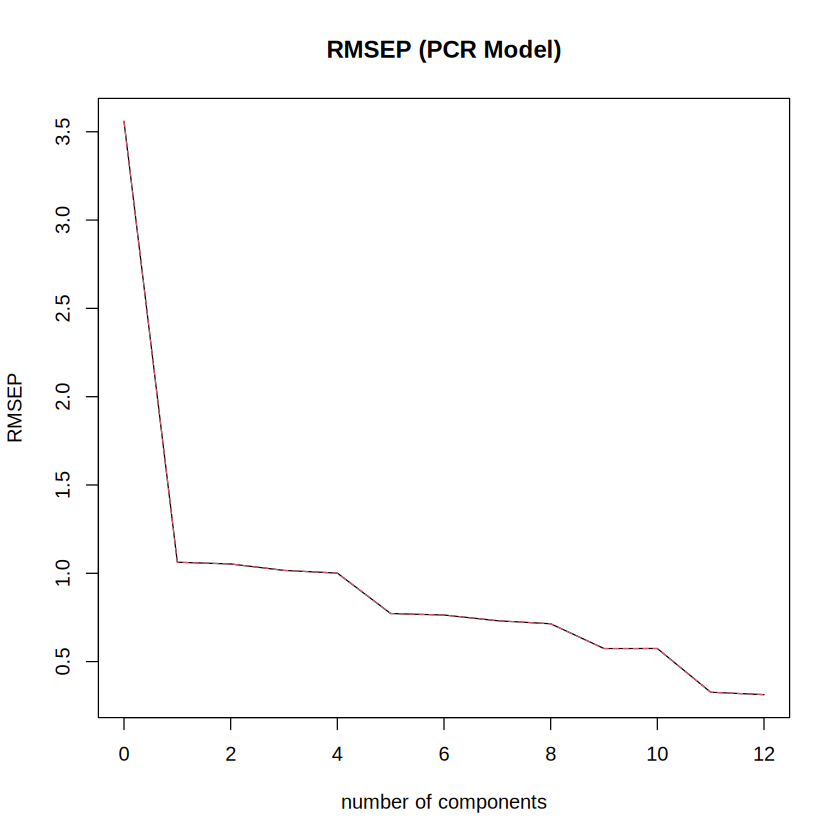

In [104]:
# Plotting the RMSEP (Root Mean Squared Error of Prediction) to find the optimal number of components
validationplot(pcr_model, val.type = "RMSEP", main = "RMSEP (PCR Model)")

In [105]:
# Predict using the model and evaluate on the test set with optimal number of components
optimal_number_of_components <- 12  # Optimal number of components based on the RMSEP plot and summary
predictions <- predict(pcr_model, ncomp = optimal_number_of_components, newdata = test)  

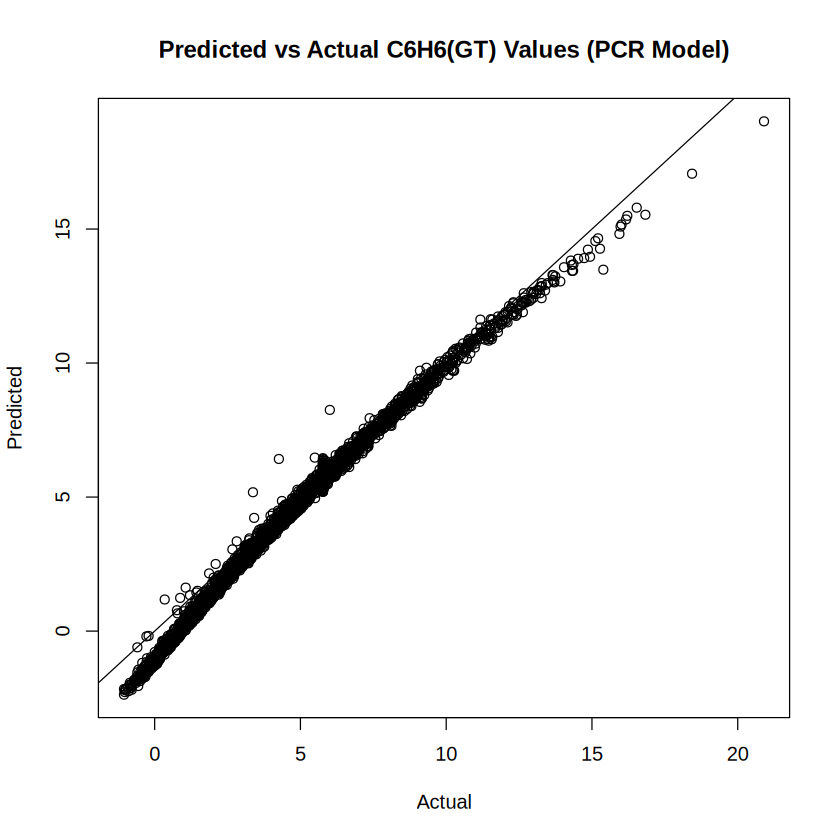

In [106]:
# Compare predictions with actual values
plot(test$`C6H6.GT.`, predictions, xlab = "Actual", ylab = "Predicted", main = "Predicted vs Actual C6H6(GT) Values (PCR Model)")  # Plot actual vs predicted values
abline(0, 1)  # Add a diagonal line for reference

In [107]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse <- sqrt(mean((test$`C6H6.GT.` - predictions)^2))  # Calculate RMSE between actual and predicted values
print(paste("RMSE: ", rmse)) 

[1] "RMSE:  0.517225894818149"


In [108]:
# Calculate the sum of squares of residuals
ss_res <- sum((test$`C6H6.GT.` - predictions)^2)

# Calculate the total sum of squares
ss_tot <- sum((test$`C6H6.GT.` - mean(test$`C6H6.GT.`))^2)

# Calculate R-squared
r_squared <- 1 - (ss_res / ss_tot)

# Print R-squared
print(paste("R-squared: ", r_squared))

[1] "R-squared:  0.97445239587654"


## Mô hình hóa bằng PLS

In [109]:
# Fitting the PLS model on the training data
pls_model <- plsr(`C6H6.GT.` ~ ., data = train, scale = TRUE, validation = "CV")

summary(pls_model)

Data: 	X dimension: 6549 12 
	Y dimension: 6549 1
Fit method: kernelpls
Number of components considered: 12

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           3.559   0.9928   0.7452   0.6638   0.6035   0.4785   0.4408
adjCV        3.559   0.9928   0.7450   0.6638   0.6035   0.4783   0.4407
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps
CV      0.3843   0.3322   0.3156    0.3145     0.313    0.3131
adjCV   0.3842   0.3321   0.3156    0.3144     0.313    0.3130

TRAINING: % variance explained
          1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps
X           51.76    60.82    72.13    82.96    87.34    92.87    95.43
C6H6.GT.    92.23    95.63    96.54    97.14    98.21    98.48    98.84
          8 comps  9 comps  10 comps  11 comps  12 comps
X           96.64    98.12     99.15     99.30    100.00
C6H6.GT.    99.14    99.22     99.23     99.23     99.23


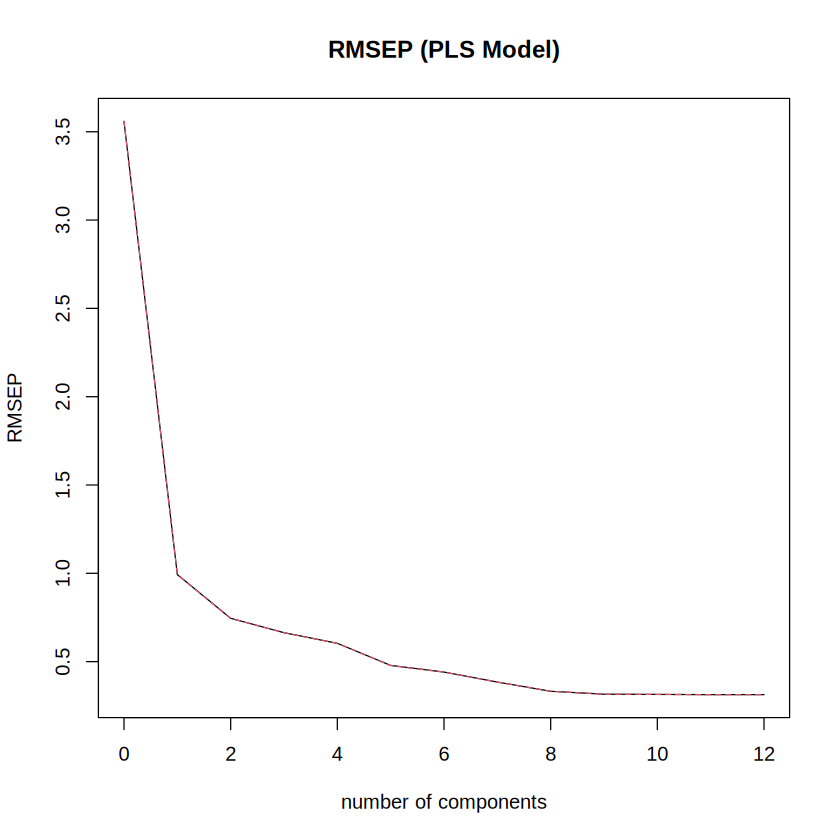

In [110]:
# Plotting the RMSEP (Root Mean Squared Error of Prediction) to find the optimal number of components
validationplot(pls_model, val.type = "RMSEP", main = "RMSEP (PLS Model)")

In [111]:
# Predict using the model and evaluate on the test set with optimal number of components
optimal_number_of_components <- 11  # Optimal number of components based on the RMSEP plot and summary
predictions2 <- predict(pls_model, ncomp = optimal_number_of_components, newdata = test)  

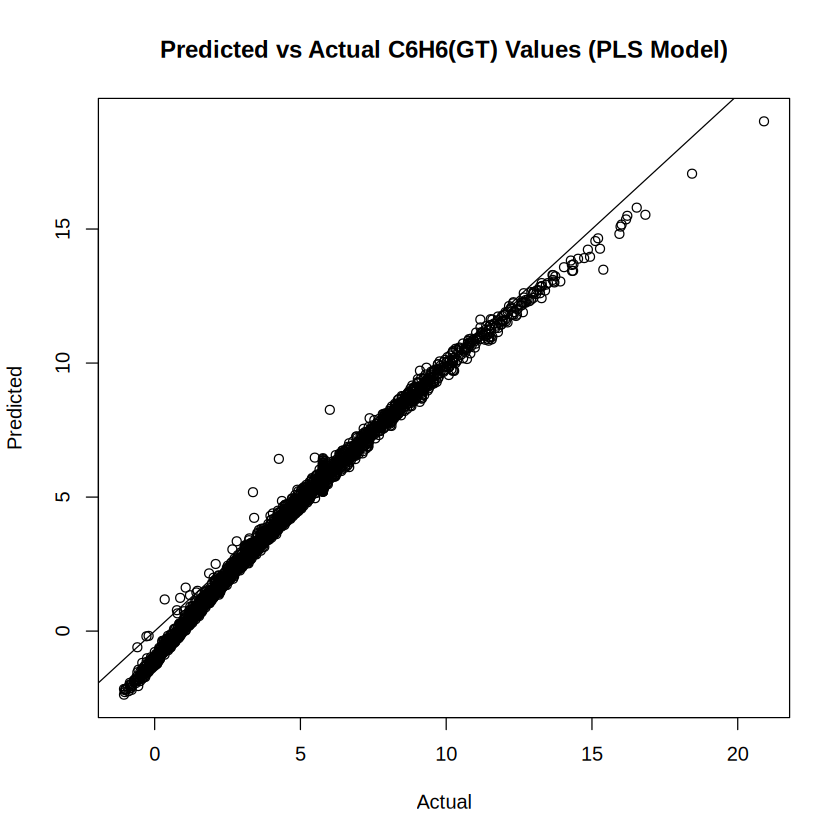

In [112]:
# Compare predictions with actual values
plot(test$`C6H6.GT.`, predictions2, xlab = "Actual", ylab = "Predicted", main = "Predicted vs Actual C6H6(GT) Values (PLS Model)")  # Plot actual vs predicted values
abline(0, 1)  # Add a diagonal line for reference

In [113]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse2 <- sqrt(mean((test$`C6H6.GT.` - predictions2)^2))  # Calculate RMSE between actual and predicted values
print(paste("RMSE: ", rmse2)) 

[1] "RMSE:  0.517942615593671"


In [114]:
# Calculate the sum of squares of residuals
ss_res2 <- sum((test$`C6H6.GT.` - predictions2)^2)

# Calculate the total sum of squares
ss_tot2 <- sum((test$`C6H6.GT.` - mean(test$`C6H6.GT.`))^2)

# Calculate R-squared
r_squared2 <- 1 - (ss_res2 / ss_tot2)

# Print R-squared
print(paste("R-squared: ", r_squared2))

[1] "R-squared:  0.97438154410648"


## Random forest

In [115]:
library(randomForest)

set.seed(123)
model_rf <- randomForest(x = train[,-c(4)],
                         y = train$`C6H6.GT.`, 
                         ntree = 500)

model_rf

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine





Call:
 randomForest(x = train[, -c(4)], y = train$C6H6.GT., ntree = 500) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 4

          Mean of squared residuals: 0.02391061
                    % Var explained: 99.81

In [117]:
library(MLmetrics)
library(performance)

pred_rf_val <- predict(object = model_rf, newdata = test)

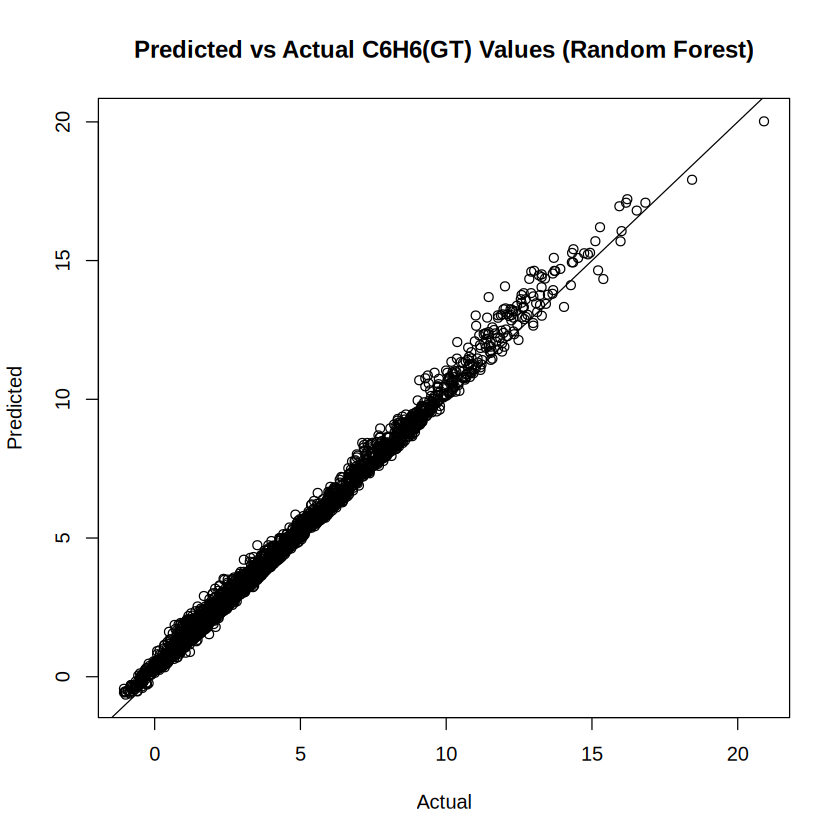

In [118]:
# Compare predictions with actual values
plot(test$`C6H6.GT.`, pred_rf_val, xlab = "Actual", ylab = "Predicted", main = "Predicted vs Actual C6H6(GT) Values (Random Forest)")  # Plot actual vs predicted values
abline(0, 1)  # Add a diagonal line for reference

In [119]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse2 <- sqrt(mean((test$`C6H6.GT.` - pred_rf_val)^2))  # Calculate RMSE between actual and predicted values
print(paste("RMSE: ", rmse2)) 

[1] "RMSE:  0.414118902326439"


In [120]:
# Calculate the sum of squares of residuals
ss_res2 <- sum((test$`C6H6.GT.` - pred_rf_val)^2)

# Calculate the total sum of squares
ss_tot2 <- sum((test$`C6H6.GT.` - mean(test$`C6H6.GT.`))^2)

# Calculate R-squared
r_squared2 <- 1 - (ss_res2 / ss_tot2)

# Print R-squared
print(paste("R-squared: ", r_squared2))

[1] "R-squared:  0.98362279569018"


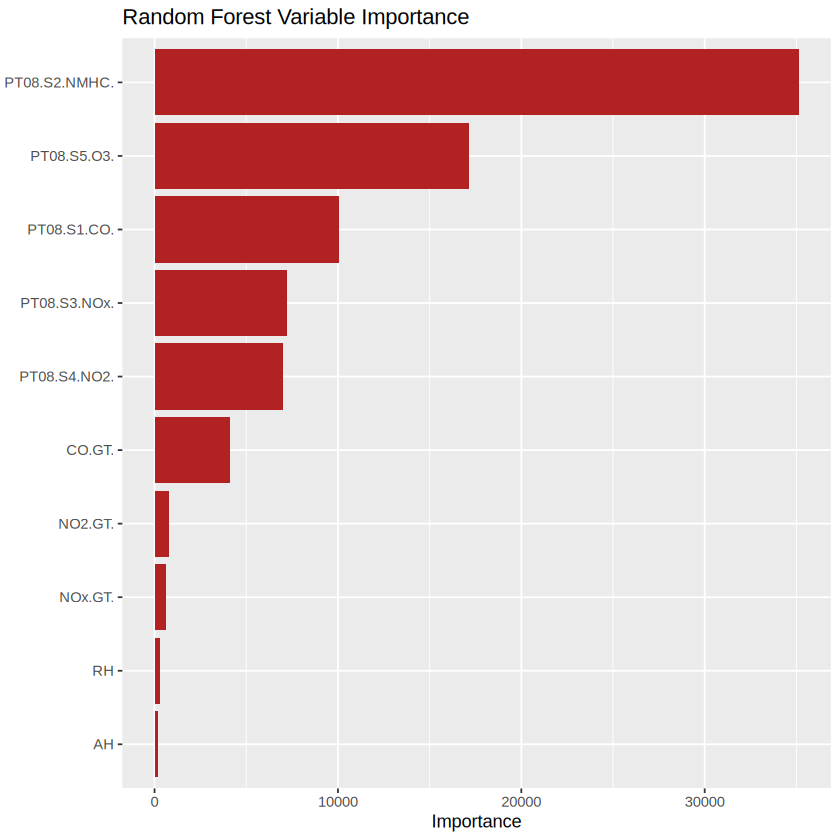

In [121]:
library("tibble")
model_rf$importance %>% 
  as.data.frame() %>% 
  arrange(-IncNodePurity) %>% 
  rownames_to_column("variable") %>% 
  head(10) %>% 
  ggplot(aes(IncNodePurity, 
             reorder(variable, IncNodePurity))
         ) +
  geom_col(fill = "firebrick") +
  labs(x = "Importance",
       y = NULL,
       title = "Random Forest Variable Importance")

In [123]:
library(lime)

set.seed(123)
explainer <- lime(x = test[,-c(4)],
                  model = model_rf)

model_type.randomForest <- function(x){
  return("regression") # for regression problem
}

predict_model.randomForest <- function(x, newdata, type = "response") {

    # return prediction value
    predict(x, newdata) %>% as.data.frame()
    
}

#  Select only the first 4 observations
selected_data <- test[,-c(4)] %>% 
  slice(1:4)

#  Explain the model
set.seed(123)
explanation <- explain(x = selected_data, 
                       explainer = explainer,
                       n_features = 27 #  Number of features to explain the model
                       )

Warning message:
“Data contains numeric columns with zero variance”


Warning message in gower_work(x = x, y = y, pair_x = pair_x, pair_y = pair_y, n = NULL, :
“skipping variable with zero or non-finite range.”
Warning message in gower_work(x = x, y = y, pair_x = pair_x, pair_y = pair_y, n = NULL, :
“skipping variable with zero or non-finite range.”
Warning message in gower_work(x = x, y = y, pair_x = pair_x, pair_y = pair_y, n = NULL, :
“skipping variable with zero or non-finite range.”
Warning message in gower_work(x = x, y = y, pair_x = pair_x, pair_y = pair_y, n = NULL, :
“skipping variable with zero or non-finite range.”


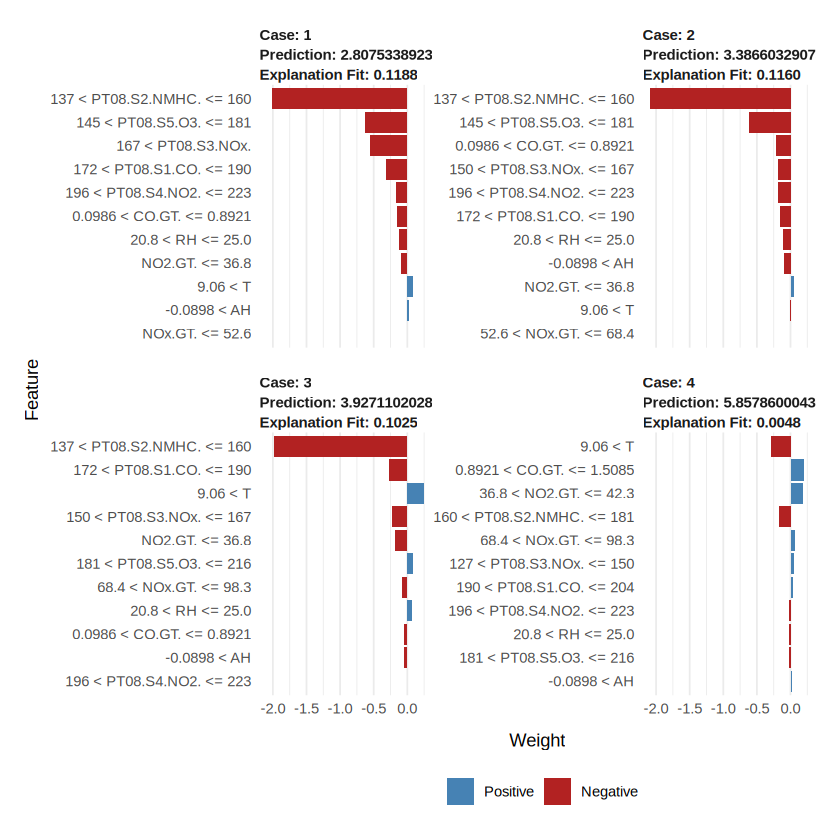

In [125]:
library(plotly)

plot_features(explanation = explanation)

## Support Vector Machine

In [126]:
library(e1071)
model_svm <- svm(`C6H6.GT.` ~ ., data = train)
pred_svm_val <- predict(object = model_svm, newdata = test)

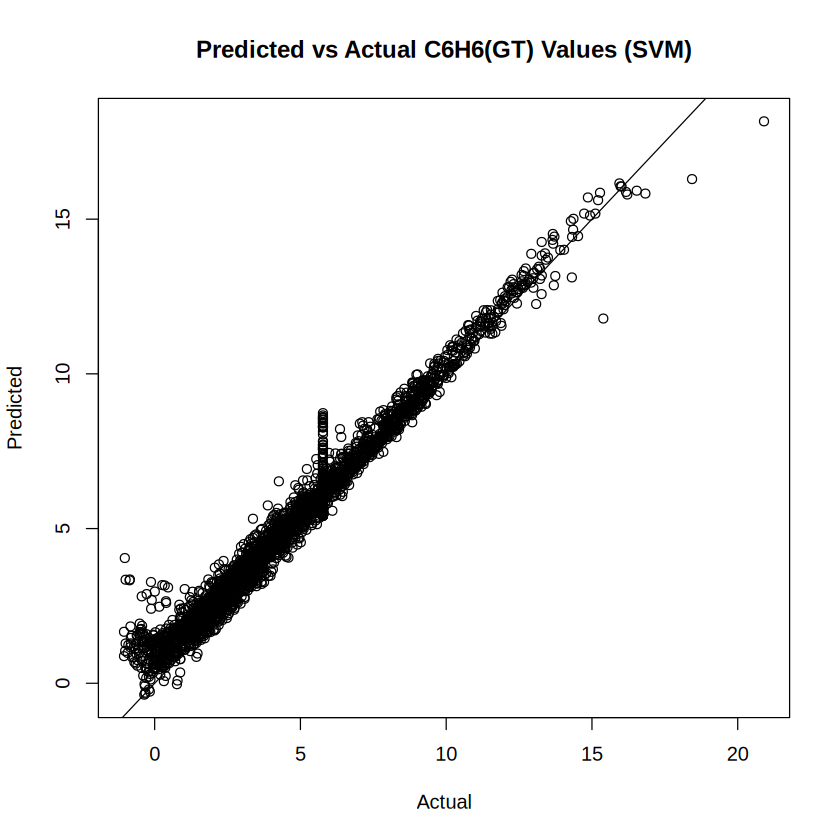

In [127]:
# Compare predictions with actual values
plot(test$`C6H6.GT.`, pred_svm_val, xlab = "Actual", ylab = "Predicted", main = "Predicted vs Actual C6H6(GT) Values (SVM)")  # Plot actual vs predicted values
abline(0, 1)  # Add a diagonal line for reference

In [128]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse2 <- sqrt(mean((test$`C6H6.GT.` - pred_svm_val)^2))  # Calculate RMSE between actual and predicted values
print(paste("RMSE: ", rmse2)) 

[1] "RMSE:  0.731968766359617"


In [129]:
# Calculate the sum of squares of residuals
ss_res2 <- sum((test$`C6H6.GT.` - pred_svm_val)^2)

# Calculate the total sum of squares
ss_tot2 <- sum((test$`C6H6.GT.` - mean(test$`C6H6.GT.`))^2)

# Calculate R-squared
r_squared2 <- 1 - (ss_res2 / ss_tot2)

# Print R-squared
print(paste("R-squared: ", r_squared2))

[1] "R-squared:  0.948834790325647"


Lime Interpretation

In [130]:
library(lime)

# create the explanation for the SVR model.
set.seed(123)
explainer_svm <- lime(x = train[,-c(4)], 
                  model = model_svm)

# Create SVR model specification for lime.
model_type.svm <- function(x){
  return("regression") # for regression problem
}

predict_model.svm <- function(x, newdata, type = "response") {

    # return prediction value
    predict(x, newdata) %>% as.data.frame()
    
}

In [131]:
set.seed(123)
explanation_svm <- explain(x = selected_data, 
                       explainer = explainer_svm,
                       kernel_width = 1,
                       feature_select = "auto", # Method of feature selection for lime
                       n_features = 10 # Number of features to explain the model
                       )


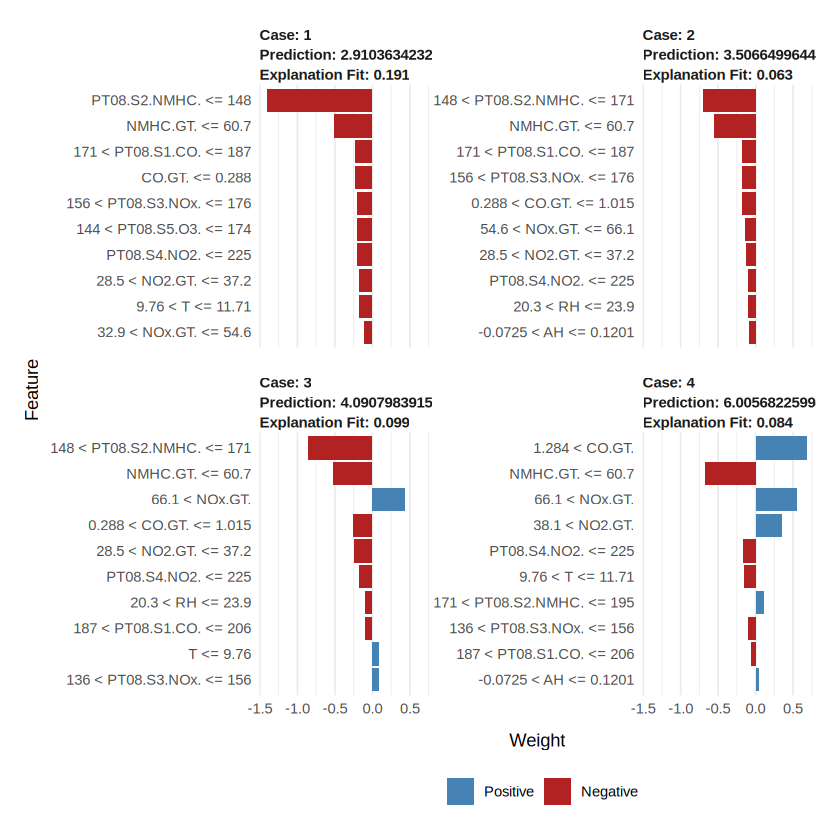

In [132]:
set.seed(123)
explanation_svm <- explain(x = selected_data, 
                       explainer = explainer_svm,
                       kernel_width = 1,
                       feature_select = "auto", # Method of feature selection for lime
                       n_features = 10 # Number of features to explain the model
                       )

plot_features(explanation_svm)

## So sánh các mô hình

## Kết luận